In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 3")
    device_num = 3
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

num_folds = 15

num_classes = 3

net_dims = 2
net_in_channels = 4

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-StdDevExtended-PR"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 3
Num images / labels = 62 62


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.nii.gz
../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.interpolated-overlay.nii.gz


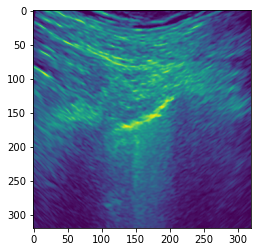

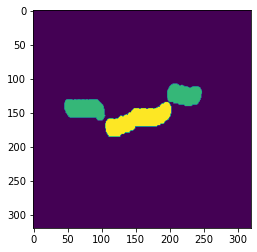

In [4]:
imgnum = 40 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[0,0,1],
            roi_end=[320,320,61],
            keys=["image", "label"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[0,0,1],
            roi_end=[320,320,61],
            keys=["image", "label"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


torch.Size([4, 4, 320, 320])
torch.Size([4, 320, 320])
image shape: torch.Size([4, 320, 320]), label shape: torch.Size([1, 320, 320])


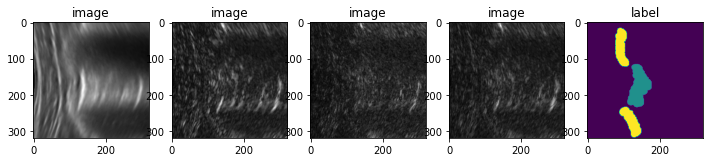

tensor(0.) tensor(2.)


In [7]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("max std")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("mid std")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("min std")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2])/2
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'.last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [10]:
for i in range(0,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.8070
2/0, train_loss: 0.8043
3/0, train_loss: 0.8025
4/0, train_loss: 0.7903
0 epoch 1 average loss: 0.8010
----------
0: epoch 2/500
1/0, train_loss: 0.7920
2/0, train_loss: 0.7882
3/0, train_loss: 0.7881
4/0, train_loss: 0.7941
0 epoch 2 average loss: 0.7906
current epoch: 2 current mean dice: 0.0577
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/500
1/0, train_loss: 0.7887
2/0, train_loss: 0.7832
3/0, train_loss: 0.7742
4/0, train_loss: 0.7726
0 epoch 3 average loss: 0.7797
----------
0: epoch 4/500
1/0, train_loss: 0.7773
2/0, train_loss: 0.7710
3/0, train_loss: 0.7767
4/0, train_loss: 0.7763
0 epoch 4 average loss: 0.7753
current epoch: 4 current mean dice: 0.0814
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 5/500
1/0, train_loss: 0.7757
2/0, train_loss: 0.7729
3/0, train_loss: 0.7678
4/0, train_loss: 0.7602
0 epoch 5 average loss: 0.7692
----------
0: epoch 6/500
1/0, train_loss: 0.7661
2/0, train_loss: 0.7624
3

1/0, train_loss: 0.7211
2/0, train_loss: 0.7071
3/0, train_loss: 0.7017
4/0, train_loss: 0.7218
0 epoch 43 average loss: 0.7129
----------
0: epoch 44/500
1/0, train_loss: 0.7138
2/0, train_loss: 0.7083
3/0, train_loss: 0.7129
4/0, train_loss: 0.7091
0 epoch 44 average loss: 0.7110
current epoch: 44 current mean dice: 0.2593
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 45/500
1/0, train_loss: 0.7130
2/0, train_loss: 0.7093
3/0, train_loss: 0.7057
4/0, train_loss: 0.7156
0 epoch 45 average loss: 0.7109
----------
0: epoch 46/500
1/0, train_loss: 0.7140
2/0, train_loss: 0.6968
3/0, train_loss: 0.7076
4/0, train_loss: 0.7266
0 epoch 46 average loss: 0.7113
current epoch: 46 current mean dice: 0.1923
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 47/500
1/0, train_loss: 0.7155
2/0, train_loss: 0.7081
3/0, train_loss: 0.7062
4/0, train_loss: 0.7086
0 epoch 47 average loss: 0.7096
----------
0: epoch 48/500
1/0, train_loss: 0.7096
2/0, train_loss: 0.7076
3/0, train_loss

1/0, train_loss: 0.6896
2/0, train_loss: 0.6778
3/0, train_loss: 0.6680
4/0, train_loss: 0.6719
0 epoch 85 average loss: 0.6768
----------
0: epoch 86/500
1/0, train_loss: 0.6750
2/0, train_loss: 0.6787
3/0, train_loss: 0.6694
4/0, train_loss: 0.6710
0 epoch 86 average loss: 0.6735
current epoch: 86 current mean dice: 0.3128
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 87/500
1/0, train_loss: 0.6797
2/0, train_loss: 0.6734
3/0, train_loss: 0.6707
4/0, train_loss: 0.6664
0 epoch 87 average loss: 0.6725
----------
0: epoch 88/500
1/0, train_loss: 0.6812
2/0, train_loss: 0.6670
3/0, train_loss: 0.6738
4/0, train_loss: 0.6742
0 epoch 88 average loss: 0.6741
current epoch: 88 current mean dice: 0.3288
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 89/500
1/0, train_loss: 0.6784
2/0, train_loss: 0.6694
3/0, train_loss: 0.6761
4/0, train_loss: 0.6770
0 epoch 89 average loss: 0.6753
----------
0: epoch 90/500
1/0, train_loss: 0.6793
2/0, train_loss: 0.6678
3/0, train_loss

0 epoch 126 average loss: 0.6346
current epoch: 126 current mean dice: 0.3628
best mean dice: 0.3657 at epoch: 122
----------
0: epoch 127/500
1/0, train_loss: 0.6429
2/0, train_loss: 0.6279
3/0, train_loss: 0.6328
4/0, train_loss: 0.6373
0 epoch 127 average loss: 0.6352
----------
0: epoch 128/500
1/0, train_loss: 0.6491
2/0, train_loss: 0.6356
3/0, train_loss: 0.6240
4/0, train_loss: 0.6393
0 epoch 128 average loss: 0.6370
current epoch: 128 current mean dice: 0.2834
best mean dice: 0.3657 at epoch: 122
----------
0: epoch 129/500
1/0, train_loss: 0.6320
2/0, train_loss: 0.6385
3/0, train_loss: 0.6345
4/0, train_loss: 0.6474
0 epoch 129 average loss: 0.6381
----------
0: epoch 130/500
1/0, train_loss: 0.6348
2/0, train_loss: 0.6339
3/0, train_loss: 0.6334
4/0, train_loss: 0.6414
0 epoch 130 average loss: 0.6359
current epoch: 130 current mean dice: 0.2706
best mean dice: 0.3657 at epoch: 122
----------
0: epoch 131/500
1/0, train_loss: 0.6297
2/0, train_loss: 0.6287
3/0, train_loss: 

1/0, train_loss: 0.5847
2/0, train_loss: 0.5960
3/0, train_loss: 0.6116
4/0, train_loss: 0.5909
0 epoch 168 average loss: 0.5958
current epoch: 168 current mean dice: 0.3318
best mean dice: 0.3657 at epoch: 122
----------
0: epoch 169/500
1/0, train_loss: 0.5938
2/0, train_loss: 0.5839
3/0, train_loss: 0.6087
4/0, train_loss: 0.5833
0 epoch 169 average loss: 0.5924
----------
0: epoch 170/500
1/0, train_loss: 0.5929
2/0, train_loss: 0.6048
3/0, train_loss: 0.5810
4/0, train_loss: 0.5869
0 epoch 170 average loss: 0.5914
current epoch: 170 current mean dice: 0.3525
best mean dice: 0.3657 at epoch: 122
----------
0: epoch 171/500
1/0, train_loss: 0.5892
2/0, train_loss: 0.5988
3/0, train_loss: 0.5959
4/0, train_loss: 0.5765
0 epoch 171 average loss: 0.5901
----------
0: epoch 172/500
1/0, train_loss: 0.5936
2/0, train_loss: 0.5886
3/0, train_loss: 0.5949
4/0, train_loss: 0.6002
0 epoch 172 average loss: 0.5943
current epoch: 172 current mean dice: 0.3615
best mean dice: 0.3657 at epoch: 1

1/0, train_loss: 0.5646
2/0, train_loss: 0.5436
3/0, train_loss: 0.5487
4/0, train_loss: 0.5632
0 epoch 209 average loss: 0.5550
----------
0: epoch 210/500
1/0, train_loss: 0.5538
2/0, train_loss: 0.5499
3/0, train_loss: 0.5573
4/0, train_loss: 0.5578
0 epoch 210 average loss: 0.5547
current epoch: 210 current mean dice: 0.3943
best mean dice: 0.4237 at epoch: 208
----------
0: epoch 211/500
1/0, train_loss: 0.5483
2/0, train_loss: 0.5524
3/0, train_loss: 0.5527
4/0, train_loss: 0.5654
0 epoch 211 average loss: 0.5547
----------
0: epoch 212/500
1/0, train_loss: 0.5496
2/0, train_loss: 0.5529
3/0, train_loss: 0.5629
4/0, train_loss: 0.5721
0 epoch 212 average loss: 0.5594
current epoch: 212 current mean dice: 0.3713
best mean dice: 0.4237 at epoch: 208
----------
0: epoch 213/500
1/0, train_loss: 0.5425
2/0, train_loss: 0.5594
3/0, train_loss: 0.5568
4/0, train_loss: 0.5361
0 epoch 213 average loss: 0.5487
----------
0: epoch 214/500
1/0, train_loss: 0.5544
2/0, train_loss: 0.5454
3/0

current epoch: 250 current mean dice: 0.3903
best mean dice: 0.4237 at epoch: 208
----------
0: epoch 251/500
1/0, train_loss: 0.5147
2/0, train_loss: 0.5159
3/0, train_loss: 0.4913
4/0, train_loss: 0.5090
0 epoch 251 average loss: 0.5077
----------
0: epoch 252/500
1/0, train_loss: 0.5182
2/0, train_loss: 0.5107
3/0, train_loss: 0.5135
4/0, train_loss: 0.4943
0 epoch 252 average loss: 0.5092
current epoch: 252 current mean dice: 0.3816
best mean dice: 0.4237 at epoch: 208
----------
0: epoch 253/500
1/0, train_loss: 0.5158
2/0, train_loss: 0.5080
3/0, train_loss: 0.4996
4/0, train_loss: 0.4983
0 epoch 253 average loss: 0.5054
----------
0: epoch 254/500
1/0, train_loss: 0.5002
2/0, train_loss: 0.5079
3/0, train_loss: 0.5054
4/0, train_loss: 0.5195
0 epoch 254 average loss: 0.5082
current epoch: 254 current mean dice: 0.3386
best mean dice: 0.4237 at epoch: 208
----------
0: epoch 255/500
1/0, train_loss: 0.5120
2/0, train_loss: 0.5058
3/0, train_loss: 0.5070
4/0, train_loss: 0.4810
0 

1/0, train_loss: 0.4824
2/0, train_loss: 0.4650
3/0, train_loss: 0.4858
4/0, train_loss: 0.4426
0 epoch 292 average loss: 0.4690
current epoch: 292 current mean dice: 0.4268
best mean dice: 0.4594 at epoch: 264
----------
0: epoch 293/500
1/0, train_loss: 0.4758
2/0, train_loss: 0.4817
3/0, train_loss: 0.4781
4/0, train_loss: 0.4516
0 epoch 293 average loss: 0.4718
----------
0: epoch 294/500
1/0, train_loss: 0.4606
2/0, train_loss: 0.4708
3/0, train_loss: 0.4824
4/0, train_loss: 0.4630
0 epoch 294 average loss: 0.4692
current epoch: 294 current mean dice: 0.4331
best mean dice: 0.4594 at epoch: 264
----------
0: epoch 295/500
1/0, train_loss: 0.4693
2/0, train_loss: 0.4672
3/0, train_loss: 0.4568
4/0, train_loss: 0.5023
0 epoch 295 average loss: 0.4739
----------
0: epoch 296/500
1/0, train_loss: 0.4764
2/0, train_loss: 0.4768
3/0, train_loss: 0.4503
4/0, train_loss: 0.4541
0 epoch 296 average loss: 0.4644
current epoch: 296 current mean dice: 0.4017
best mean dice: 0.4594 at epoch: 2

3/0, train_loss: 0.4409
4/0, train_loss: 0.4202
0 epoch 333 average loss: 0.4345
----------
0: epoch 334/500
1/0, train_loss: 0.4467
2/0, train_loss: 0.4381
3/0, train_loss: 0.4368
4/0, train_loss: 0.4335
0 epoch 334 average loss: 0.4388
current epoch: 334 current mean dice: 0.4076
best mean dice: 0.4594 at epoch: 264
----------
0: epoch 335/500
1/0, train_loss: 0.4443
2/0, train_loss: 0.4485
3/0, train_loss: 0.4395
4/0, train_loss: 0.4517
0 epoch 335 average loss: 0.4460
----------
0: epoch 336/500
1/0, train_loss: 0.4454
2/0, train_loss: 0.4370
3/0, train_loss: 0.4468
4/0, train_loss: 0.4151
0 epoch 336 average loss: 0.4361
current epoch: 336 current mean dice: 0.4464
best mean dice: 0.4594 at epoch: 264
----------
0: epoch 337/500
1/0, train_loss: 0.4115
2/0, train_loss: 0.4511
3/0, train_loss: 0.4426
4/0, train_loss: 0.4387
0 epoch 337 average loss: 0.4360
----------
0: epoch 338/500
1/0, train_loss: 0.4215
2/0, train_loss: 0.4250
3/0, train_loss: 0.4454
4/0, train_loss: 0.4449
0 e

1/0, train_loss: 0.4079
2/0, train_loss: 0.4343
3/0, train_loss: 0.4141
4/0, train_loss: 0.3878
0 epoch 375 average loss: 0.4110
----------
0: epoch 376/500
1/0, train_loss: 0.4089
2/0, train_loss: 0.4230
3/0, train_loss: 0.4178
4/0, train_loss: 0.4032
0 epoch 376 average loss: 0.4132
current epoch: 376 current mean dice: 0.4209
best mean dice: 0.4594 at epoch: 264
----------
0: epoch 377/500
1/0, train_loss: 0.4303
2/0, train_loss: 0.4102
3/0, train_loss: 0.4167
4/0, train_loss: 0.3685
0 epoch 377 average loss: 0.4064
----------
0: epoch 378/500
1/0, train_loss: 0.4187
2/0, train_loss: 0.4167
3/0, train_loss: 0.4000
4/0, train_loss: 0.4365
0 epoch 378 average loss: 0.4180
saved new best metric model
current epoch: 378 current mean dice: 0.4645
best mean dice: 0.4645 at epoch: 378
----------
0: epoch 379/500
1/0, train_loss: 0.4111
2/0, train_loss: 0.4090
3/0, train_loss: 0.4061
4/0, train_loss: 0.4129
0 epoch 379 average loss: 0.4098
----------
0: epoch 380/500
1/0, train_loss: 0.4068

0 epoch 416 average loss: 0.3886
current epoch: 416 current mean dice: 0.4298
best mean dice: 0.4645 at epoch: 378
----------
0: epoch 417/500
1/0, train_loss: 0.3974
2/0, train_loss: 0.3887
3/0, train_loss: 0.3898
4/0, train_loss: 0.3730
0 epoch 417 average loss: 0.3872
----------
0: epoch 418/500
1/0, train_loss: 0.4060
2/0, train_loss: 0.3732
3/0, train_loss: 0.3949
4/0, train_loss: 0.3640
0 epoch 418 average loss: 0.3845
current epoch: 418 current mean dice: 0.4191
best mean dice: 0.4645 at epoch: 378
----------
0: epoch 419/500
1/0, train_loss: 0.3843
2/0, train_loss: 0.3931
3/0, train_loss: 0.3808
4/0, train_loss: 0.3923
0 epoch 419 average loss: 0.3876
----------
0: epoch 420/500
1/0, train_loss: 0.3860
2/0, train_loss: 0.3833
3/0, train_loss: 0.3971
4/0, train_loss: 0.3974
0 epoch 420 average loss: 0.3910
current epoch: 420 current mean dice: 0.4410
best mean dice: 0.4645 at epoch: 378
----------
0: epoch 421/500
1/0, train_loss: 0.3915
2/0, train_loss: 0.3740
3/0, train_loss: 

1/0, train_loss: 0.3761
2/0, train_loss: 0.3762
3/0, train_loss: 0.3763
4/0, train_loss: 0.3407
0 epoch 458 average loss: 0.3673
current epoch: 458 current mean dice: 0.4089
best mean dice: 0.4645 at epoch: 378
----------
0: epoch 459/500
1/0, train_loss: 0.3734
2/0, train_loss: 0.3740
3/0, train_loss: 0.3606
4/0, train_loss: 0.3666
0 epoch 459 average loss: 0.3686
----------
0: epoch 460/500
1/0, train_loss: 0.3587
2/0, train_loss: 0.3713
3/0, train_loss: 0.3730
4/0, train_loss: 0.4163
0 epoch 460 average loss: 0.3798
current epoch: 460 current mean dice: 0.4274
best mean dice: 0.4645 at epoch: 378
----------
0: epoch 461/500
1/0, train_loss: 0.3640
2/0, train_loss: 0.3852
3/0, train_loss: 0.4010
4/0, train_loss: 0.3908
0 epoch 461 average loss: 0.3853
----------
0: epoch 462/500
1/0, train_loss: 0.3757
2/0, train_loss: 0.3612
3/0, train_loss: 0.3614
4/0, train_loss: 0.3840
0 epoch 462 average loss: 0.3706
current epoch: 462 current mean dice: 0.4282
best mean dice: 0.4645 at epoch: 3

3/0, train_loss: 0.3537
4/0, train_loss: 0.3874
0 epoch 499 average loss: 0.3629
----------
0: epoch 500/500
1/0, train_loss: 0.3632
2/0, train_loss: 0.3464
3/0, train_loss: 0.3701
4/0, train_loss: 0.3770
0 epoch 500 average loss: 0.3642
current epoch: 500 current mean dice: 0.4310
best mean dice: 0.4645 at epoch: 378
----------
1: epoch 1/500
1/0, train_loss: 0.7972
2/0, train_loss: 0.7910
3/0, train_loss: 0.7871
4/0, train_loss: 0.7882
1 epoch 1 average loss: 0.7909
----------
1: epoch 2/500
1/0, train_loss: 0.7837
2/0, train_loss: 0.7740
3/0, train_loss: 0.7783
4/0, train_loss: 0.7659
1 epoch 2 average loss: 0.7755
current epoch: 2 current mean dice: 0.0388
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 3/500
1/0, train_loss: 0.7759
2/0, train_loss: 0.7691
3/0, train_loss: 0.7668
4/0, train_loss: 0.7595
1 epoch 3 average loss: 0.7678
----------
1: epoch 4/500
1/0, train_loss: 0.7699
2/0, train_loss: 0.7629
3/0, train_loss: 0.7578
4/0, train_loss: 0.7565
1 epoch 4 average l

3/0, train_loss: 0.7003
4/0, train_loss: 0.7173
1 epoch 41 average loss: 0.7072
----------
1: epoch 42/500
1/0, train_loss: 0.6967
2/0, train_loss: 0.7060
3/0, train_loss: 0.7046
4/0, train_loss: 0.6873
1 epoch 42 average loss: 0.6986
current epoch: 42 current mean dice: 0.1361
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 43/500
1/0, train_loss: 0.6980
2/0, train_loss: 0.7100
3/0, train_loss: 0.6978
4/0, train_loss: 0.7039
1 epoch 43 average loss: 0.7024
----------
1: epoch 44/500
1/0, train_loss: 0.7078
2/0, train_loss: 0.6966
3/0, train_loss: 0.6983
4/0, train_loss: 0.7091
1 epoch 44 average loss: 0.7029
current epoch: 44 current mean dice: 0.1244
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 45/500
1/0, train_loss: 0.7000
2/0, train_loss: 0.6996
3/0, train_loss: 0.7014
4/0, train_loss: 0.7148
1 epoch 45 average loss: 0.7040
----------
1: epoch 46/500
1/0, train_loss: 0.7024
2/0, train_loss: 0.6965
3/0, train_loss: 0.6983
4/0, train_loss: 0.6989
1 epoch 46 aver

3/0, train_loss: 0.6754
4/0, train_loss: 0.6690
1 epoch 83 average loss: 0.6716
----------
1: epoch 84/500
1/0, train_loss: 0.6768
2/0, train_loss: 0.6606
3/0, train_loss: 0.6668
4/0, train_loss: 0.7077
1 epoch 84 average loss: 0.6780
current epoch: 84 current mean dice: 0.1229
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 85/500
1/0, train_loss: 0.6637
2/0, train_loss: 0.6613
3/0, train_loss: 0.6818
4/0, train_loss: 0.6978
1 epoch 85 average loss: 0.6761
----------
1: epoch 86/500
1/0, train_loss: 0.6813
2/0, train_loss: 0.6765
3/0, train_loss: 0.6629
4/0, train_loss: 0.6394
1 epoch 86 average loss: 0.6650
current epoch: 86 current mean dice: 0.1670
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 87/500
1/0, train_loss: 0.6581
2/0, train_loss: 0.6840
3/0, train_loss: 0.6587
4/0, train_loss: 0.6809
1 epoch 87 average loss: 0.6704
----------
1: epoch 88/500
1/0, train_loss: 0.6598
2/0, train_loss: 0.6738
3/0, train_loss: 0.6666
4/0, train_loss: 0.6697
1 epoch 88 aver

current epoch: 124 current mean dice: 0.1608
best mean dice: 0.1777 at epoch: 120
----------
1: epoch 125/500
1/0, train_loss: 0.6465
2/0, train_loss: 0.6298
3/0, train_loss: 0.6490
4/0, train_loss: 0.6273
1 epoch 125 average loss: 0.6382
----------
1: epoch 126/500
1/0, train_loss: 0.6342
2/0, train_loss: 0.6380
3/0, train_loss: 0.6454
4/0, train_loss: 0.6387
1 epoch 126 average loss: 0.6390
current epoch: 126 current mean dice: 0.1568
best mean dice: 0.1777 at epoch: 120
----------
1: epoch 127/500
1/0, train_loss: 0.6377
2/0, train_loss: 0.6510
3/0, train_loss: 0.6283
4/0, train_loss: 0.6384
1 epoch 127 average loss: 0.6388
----------
1: epoch 128/500
1/0, train_loss: 0.6379
2/0, train_loss: 0.6342
3/0, train_loss: 0.6538
4/0, train_loss: 0.6031
1 epoch 128 average loss: 0.6322
current epoch: 128 current mean dice: 0.1548
best mean dice: 0.1777 at epoch: 120
----------
1: epoch 129/500
1/0, train_loss: 0.6272
2/0, train_loss: 0.6437
3/0, train_loss: 0.6484
4/0, train_loss: 0.6313
1 

1 epoch 165 average loss: 0.6135
----------
1: epoch 166/500
1/0, train_loss: 0.6262
2/0, train_loss: 0.5930
3/0, train_loss: 0.6148
4/0, train_loss: 0.5941
1 epoch 166 average loss: 0.6070
current epoch: 166 current mean dice: 0.2072
best mean dice: 0.2170 at epoch: 160
----------
1: epoch 167/500
1/0, train_loss: 0.6018
2/0, train_loss: 0.6204
3/0, train_loss: 0.6123
4/0, train_loss: 0.5882
1 epoch 167 average loss: 0.6057
----------
1: epoch 168/500
1/0, train_loss: 0.6071
2/0, train_loss: 0.5999
3/0, train_loss: 0.6146
4/0, train_loss: 0.5910
1 epoch 168 average loss: 0.6031
current epoch: 168 current mean dice: 0.2107
best mean dice: 0.2170 at epoch: 160
----------
1: epoch 169/500
1/0, train_loss: 0.6120
2/0, train_loss: 0.6106
3/0, train_loss: 0.6011
4/0, train_loss: 0.6027
1 epoch 169 average loss: 0.6066
----------
1: epoch 170/500
1/0, train_loss: 0.6026
2/0, train_loss: 0.6109
3/0, train_loss: 0.5997
4/0, train_loss: 0.6195
1 epoch 170 average loss: 0.6081
current epoch: 170

1/0, train_loss: 0.5618
2/0, train_loss: 0.5606
3/0, train_loss: 0.5611
4/0, train_loss: 0.5704
1 epoch 207 average loss: 0.5635
----------
1: epoch 208/500
1/0, train_loss: 0.5641
2/0, train_loss: 0.5650
3/0, train_loss: 0.5582
4/0, train_loss: 0.5334
1 epoch 208 average loss: 0.5552
current epoch: 208 current mean dice: 0.2166
best mean dice: 0.2396 at epoch: 200
----------
1: epoch 209/500
1/0, train_loss: 0.5698
2/0, train_loss: 0.5609
3/0, train_loss: 0.5582
4/0, train_loss: 0.5441
1 epoch 209 average loss: 0.5583
----------
1: epoch 210/500
1/0, train_loss: 0.5664
2/0, train_loss: 0.5651
3/0, train_loss: 0.5463
4/0, train_loss: 0.5385
1 epoch 210 average loss: 0.5541
current epoch: 210 current mean dice: 0.1982
best mean dice: 0.2396 at epoch: 200
----------
1: epoch 211/500
1/0, train_loss: 0.5587
2/0, train_loss: 0.5664
3/0, train_loss: 0.5440
4/0, train_loss: 0.5584
1 epoch 211 average loss: 0.5569
----------
1: epoch 212/500
1/0, train_loss: 0.5610
2/0, train_loss: 0.5542
3/0

2/0, train_loss: 0.5066
3/0, train_loss: 0.5079
4/0, train_loss: 0.4616
1 epoch 248 average loss: 0.4960
current epoch: 248 current mean dice: 0.2602
best mean dice: 0.2696 at epoch: 246
----------
1: epoch 249/500
1/0, train_loss: 0.4890
2/0, train_loss: 0.5137
3/0, train_loss: 0.5047
4/0, train_loss: 0.4763
1 epoch 249 average loss: 0.4959
----------
1: epoch 250/500
1/0, train_loss: 0.4853
2/0, train_loss: 0.4973
3/0, train_loss: 0.5030
4/0, train_loss: 0.5037
1 epoch 250 average loss: 0.4973
current epoch: 250 current mean dice: 0.2550
best mean dice: 0.2696 at epoch: 246
----------
1: epoch 251/500
1/0, train_loss: 0.4870
2/0, train_loss: 0.4989
3/0, train_loss: 0.4942
4/0, train_loss: 0.5213
1 epoch 251 average loss: 0.5003
----------
1: epoch 252/500
1/0, train_loss: 0.4711
2/0, train_loss: 0.4794
3/0, train_loss: 0.5038
4/0, train_loss: 0.5174
1 epoch 252 average loss: 0.4929
saved new best metric model
current epoch: 252 current mean dice: 0.2967
best mean dice: 0.2967 at epoc

2/0, train_loss: 0.4346
3/0, train_loss: 0.4119
4/0, train_loss: 0.4612
1 epoch 289 average loss: 0.4376
----------
1: epoch 290/500
1/0, train_loss: 0.4415
2/0, train_loss: 0.4204
3/0, train_loss: 0.4237
4/0, train_loss: 0.4274
1 epoch 290 average loss: 0.4282
current epoch: 290 current mean dice: 0.2525
best mean dice: 0.3135 at epoch: 276
----------
1: epoch 291/500
1/0, train_loss: 0.4564
2/0, train_loss: 0.4093
3/0, train_loss: 0.4142
4/0, train_loss: 0.4401
1 epoch 291 average loss: 0.4300
----------
1: epoch 292/500
1/0, train_loss: 0.4348
2/0, train_loss: 0.4309
3/0, train_loss: 0.4213
4/0, train_loss: 0.3653
1 epoch 292 average loss: 0.4131
current epoch: 292 current mean dice: 0.3060
best mean dice: 0.3135 at epoch: 276
----------
1: epoch 293/500
1/0, train_loss: 0.4351
2/0, train_loss: 0.4193
3/0, train_loss: 0.4388
4/0, train_loss: 0.3702
1 epoch 293 average loss: 0.4158
----------
1: epoch 294/500
1/0, train_loss: 0.4232
2/0, train_loss: 0.4036
3/0, train_loss: 0.4173
4/0

3/0, train_loss: 0.3847
4/0, train_loss: 0.3758
1 epoch 330 average loss: 0.3767
current epoch: 330 current mean dice: 0.3440
best mean dice: 0.3535 at epoch: 324
----------
1: epoch 331/500
1/0, train_loss: 0.3914
2/0, train_loss: 0.3852
3/0, train_loss: 0.3748
4/0, train_loss: 0.3567
1 epoch 331 average loss: 0.3770
----------
1: epoch 332/500
1/0, train_loss: 0.3828
2/0, train_loss: 0.3784
3/0, train_loss: 0.3721
4/0, train_loss: 0.3987
1 epoch 332 average loss: 0.3830
current epoch: 332 current mean dice: 0.3331
best mean dice: 0.3535 at epoch: 324
----------
1: epoch 333/500
1/0, train_loss: 0.3641
2/0, train_loss: 0.4212
3/0, train_loss: 0.3725
4/0, train_loss: 0.4057
1 epoch 333 average loss: 0.3909
----------
1: epoch 334/500
1/0, train_loss: 0.3641
2/0, train_loss: 0.3802
3/0, train_loss: 0.3899
4/0, train_loss: 0.3774
1 epoch 334 average loss: 0.3779
current epoch: 334 current mean dice: 0.2965
best mean dice: 0.3535 at epoch: 324
----------
1: epoch 335/500
1/0, train_loss: 

1 epoch 371 average loss: 0.3432
----------
1: epoch 372/500
1/0, train_loss: 0.3307
2/0, train_loss: 0.3328
3/0, train_loss: 0.3589
4/0, train_loss: 0.3578
1 epoch 372 average loss: 0.3451
current epoch: 372 current mean dice: 0.2826
best mean dice: 0.3541 at epoch: 370
----------
1: epoch 373/500
1/0, train_loss: 0.3406
2/0, train_loss: 0.3468
3/0, train_loss: 0.3558
4/0, train_loss: 0.3383
1 epoch 373 average loss: 0.3454
----------
1: epoch 374/500
1/0, train_loss: 0.3471
2/0, train_loss: 0.3195
3/0, train_loss: 0.3485
4/0, train_loss: 0.3491
1 epoch 374 average loss: 0.3411
current epoch: 374 current mean dice: 0.2254
best mean dice: 0.3541 at epoch: 370
----------
1: epoch 375/500
1/0, train_loss: 0.3399
2/0, train_loss: 0.3331
3/0, train_loss: 0.3267
4/0, train_loss: 0.3782
1 epoch 375 average loss: 0.3445
----------
1: epoch 376/500
1/0, train_loss: 0.3318
2/0, train_loss: 0.3458
3/0, train_loss: 0.3488
4/0, train_loss: 0.3061
1 epoch 376 average loss: 0.3331
current epoch: 376

1/0, train_loss: 0.3118
2/0, train_loss: 0.3203
3/0, train_loss: 0.3238
4/0, train_loss: 0.2879
1 epoch 413 average loss: 0.3110
----------
1: epoch 414/500
1/0, train_loss: 0.3010
2/0, train_loss: 0.3029
3/0, train_loss: 0.3075
4/0, train_loss: 0.3289
1 epoch 414 average loss: 0.3101
current epoch: 414 current mean dice: 0.2958
best mean dice: 0.3749 at epoch: 410
----------
1: epoch 415/500
1/0, train_loss: 0.3085
2/0, train_loss: 0.3029
3/0, train_loss: 0.3243
4/0, train_loss: 0.3295
1 epoch 415 average loss: 0.3163
----------
1: epoch 416/500
1/0, train_loss: 0.2980
2/0, train_loss: 0.3363
3/0, train_loss: 0.2814
4/0, train_loss: 0.3543
1 epoch 416 average loss: 0.3175
current epoch: 416 current mean dice: 0.3140
best mean dice: 0.3749 at epoch: 410
----------
1: epoch 417/500
1/0, train_loss: 0.3327
2/0, train_loss: 0.3004
3/0, train_loss: 0.3173
4/0, train_loss: 0.3045
1 epoch 417 average loss: 0.3137
----------
1: epoch 418/500
1/0, train_loss: 0.3189
2/0, train_loss: 0.2887
3/0

current epoch: 454 current mean dice: 0.3000
best mean dice: 0.3749 at epoch: 410
----------
1: epoch 455/500
1/0, train_loss: 0.3069
2/0, train_loss: 0.2584
3/0, train_loss: 0.3049
4/0, train_loss: 0.2521
1 epoch 455 average loss: 0.2806
----------
1: epoch 456/500
1/0, train_loss: 0.2828
2/0, train_loss: 0.2762
3/0, train_loss: 0.3171
4/0, train_loss: 0.3006
1 epoch 456 average loss: 0.2942
current epoch: 456 current mean dice: 0.2612
best mean dice: 0.3749 at epoch: 410
----------
1: epoch 457/500
1/0, train_loss: 0.2826
2/0, train_loss: 0.3279
3/0, train_loss: 0.2635
4/0, train_loss: 0.2755
1 epoch 457 average loss: 0.2874
----------
1: epoch 458/500
1/0, train_loss: 0.2936
2/0, train_loss: 0.2840
3/0, train_loss: 0.2860
4/0, train_loss: 0.2884
1 epoch 458 average loss: 0.2880
current epoch: 458 current mean dice: 0.3381
best mean dice: 0.3749 at epoch: 410
----------
1: epoch 459/500
1/0, train_loss: 0.2683
2/0, train_loss: 0.2929
3/0, train_loss: 0.2865
4/0, train_loss: 0.3241
1 

2/0, train_loss: 0.2628
3/0, train_loss: 0.2852
4/0, train_loss: 0.3102
1 epoch 496 average loss: 0.2808
current epoch: 496 current mean dice: 0.3223
best mean dice: 0.3749 at epoch: 410
----------
1: epoch 497/500
1/0, train_loss: 0.2801
2/0, train_loss: 0.2594
3/0, train_loss: 0.2912
4/0, train_loss: 0.2675
1 epoch 497 average loss: 0.2745
----------
1: epoch 498/500
1/0, train_loss: 0.2603
2/0, train_loss: 0.2663
3/0, train_loss: 0.2868
4/0, train_loss: 0.2568
1 epoch 498 average loss: 0.2676
current epoch: 498 current mean dice: 0.3069
best mean dice: 0.3749 at epoch: 410
----------
1: epoch 499/500
1/0, train_loss: 0.2700
2/0, train_loss: 0.2772
3/0, train_loss: 0.2616
4/0, train_loss: 0.2844
1 epoch 499 average loss: 0.2733
----------
1: epoch 500/500
1/0, train_loss: 0.2715
2/0, train_loss: 0.2474
3/0, train_loss: 0.2963
4/0, train_loss: 0.2302
1 epoch 500 average loss: 0.2613
current epoch: 500 current mean dice: 0.2712
best mean dice: 0.3749 at epoch: 410
----------
2: epoch 1

2/0, train_loss: 0.6582
3/0, train_loss: 0.6733
4/0, train_loss: 0.6823
2 epoch 38 average loss: 0.6653
current epoch: 38 current mean dice: 0.2002
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 39/500
1/0, train_loss: 0.6598
2/0, train_loss: 0.6662
3/0, train_loss: 0.6504
4/0, train_loss: 0.6707
2 epoch 39 average loss: 0.6618
----------
2: epoch 40/500
1/0, train_loss: 0.6569
2/0, train_loss: 0.6653
3/0, train_loss: 0.6604
4/0, train_loss: 0.6473
2 epoch 40 average loss: 0.6575
current epoch: 40 current mean dice: 0.2290
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 41/500
1/0, train_loss: 0.6545
2/0, train_loss: 0.6637
3/0, train_loss: 0.6558
4/0, train_loss: 0.6498
2 epoch 41 average loss: 0.6559
----------
2: epoch 42/500
1/0, train_loss: 0.6484
2/0, train_loss: 0.6544
3/0, train_loss: 0.6642
4/0, train_loss: 0.6618
2 epoch 42 average loss: 0.6572
current epoch: 42 current mean dice: 0.2436
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 43/500
1/0, t

2/0, train_loss: 0.6184
3/0, train_loss: 0.6179
4/0, train_loss: 0.6025
2 epoch 80 average loss: 0.6213
current epoch: 80 current mean dice: 0.2510
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 81/500
1/0, train_loss: 0.6271
2/0, train_loss: 0.6291
3/0, train_loss: 0.6240
4/0, train_loss: 0.6326
2 epoch 81 average loss: 0.6282
----------
2: epoch 82/500
1/0, train_loss: 0.6209
2/0, train_loss: 0.6198
3/0, train_loss: 0.6205
4/0, train_loss: 0.6164
2 epoch 82 average loss: 0.6194
current epoch: 82 current mean dice: 0.2757
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 83/500
1/0, train_loss: 0.6192
2/0, train_loss: 0.6318
3/0, train_loss: 0.6169
4/0, train_loss: 0.6366
2 epoch 83 average loss: 0.6261
----------
2: epoch 84/500
1/0, train_loss: 0.6143
2/0, train_loss: 0.6198
3/0, train_loss: 0.6376
4/0, train_loss: 0.6291
2 epoch 84 average loss: 0.6252
current epoch: 84 current mean dice: 0.2564
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 85/500
1/0, t

2 epoch 121 average loss: 0.5928
----------
2: epoch 122/500
1/0, train_loss: 0.6086
2/0, train_loss: 0.5789
3/0, train_loss: 0.5842
4/0, train_loss: 0.5865
2 epoch 122 average loss: 0.5895
current epoch: 122 current mean dice: 0.2704
best mean dice: 0.3180 at epoch: 102
----------
2: epoch 123/500
1/0, train_loss: 0.6100
2/0, train_loss: 0.5920
3/0, train_loss: 0.5759
4/0, train_loss: 0.5856
2 epoch 123 average loss: 0.5909
----------
2: epoch 124/500
1/0, train_loss: 0.5883
2/0, train_loss: 0.5903
3/0, train_loss: 0.5939
4/0, train_loss: 0.5922
2 epoch 124 average loss: 0.5912
current epoch: 124 current mean dice: 0.2925
best mean dice: 0.3180 at epoch: 102
----------
2: epoch 125/500
1/0, train_loss: 0.5924
2/0, train_loss: 0.5972
3/0, train_loss: 0.5791
4/0, train_loss: 0.5800
2 epoch 125 average loss: 0.5872
----------
2: epoch 126/500
1/0, train_loss: 0.5973
2/0, train_loss: 0.5943
3/0, train_loss: 0.5860
4/0, train_loss: 0.5816
2 epoch 126 average loss: 0.5898
current epoch: 126

saved new best metric model
current epoch: 162 current mean dice: 0.3427
best mean dice: 0.3427 at epoch: 162
----------
2: epoch 163/500
1/0, train_loss: 0.5460
2/0, train_loss: 0.5620
3/0, train_loss: 0.5603
4/0, train_loss: 0.5642
2 epoch 163 average loss: 0.5581
----------
2: epoch 164/500
1/0, train_loss: 0.5671
2/0, train_loss: 0.5555
3/0, train_loss: 0.5698
4/0, train_loss: 0.5546
2 epoch 164 average loss: 0.5617
current epoch: 164 current mean dice: 0.3370
best mean dice: 0.3427 at epoch: 162
----------
2: epoch 165/500
1/0, train_loss: 0.5618
2/0, train_loss: 0.5590
3/0, train_loss: 0.5580
4/0, train_loss: 0.5919
2 epoch 165 average loss: 0.5677
----------
2: epoch 166/500
1/0, train_loss: 0.5564
2/0, train_loss: 0.5411
3/0, train_loss: 0.5686
4/0, train_loss: 0.5799
2 epoch 166 average loss: 0.5615
current epoch: 166 current mean dice: 0.3095
best mean dice: 0.3427 at epoch: 162
----------
2: epoch 167/500
1/0, train_loss: 0.5461
2/0, train_loss: 0.5481
3/0, train_loss: 0.556

1/0, train_loss: 0.5420
2/0, train_loss: 0.5299
3/0, train_loss: 0.5013
4/0, train_loss: 0.5110
2 epoch 204 average loss: 0.5210
current epoch: 204 current mean dice: 0.3141
best mean dice: 0.3474 at epoch: 200
----------
2: epoch 205/500
1/0, train_loss: 0.5162
2/0, train_loss: 0.5520
3/0, train_loss: 0.5131
4/0, train_loss: 0.5258
2 epoch 205 average loss: 0.5267
----------
2: epoch 206/500
1/0, train_loss: 0.5524
2/0, train_loss: 0.5326
3/0, train_loss: 0.5165
4/0, train_loss: 0.4770
2 epoch 206 average loss: 0.5196
current epoch: 206 current mean dice: 0.3241
best mean dice: 0.3474 at epoch: 200
----------
2: epoch 207/500
1/0, train_loss: 0.5040
2/0, train_loss: 0.5194
3/0, train_loss: 0.5444
4/0, train_loss: 0.5390
2 epoch 207 average loss: 0.5267
----------
2: epoch 208/500
1/0, train_loss: 0.5189
2/0, train_loss: 0.5240
3/0, train_loss: 0.5231
4/0, train_loss: 0.5176
2 epoch 208 average loss: 0.5209
current epoch: 208 current mean dice: 0.3255
best mean dice: 0.3474 at epoch: 2

1/0, train_loss: 0.4909
2/0, train_loss: 0.4878
3/0, train_loss: 0.4918
4/0, train_loss: 0.5075
2 epoch 245 average loss: 0.4945
----------
2: epoch 246/500
1/0, train_loss: 0.5193
2/0, train_loss: 0.4719
3/0, train_loss: 0.4906
4/0, train_loss: 0.5068
2 epoch 246 average loss: 0.4971
current epoch: 246 current mean dice: 0.3522
best mean dice: 0.3533 at epoch: 244
----------
2: epoch 247/500
1/0, train_loss: 0.5124
2/0, train_loss: 0.4892
3/0, train_loss: 0.4889
4/0, train_loss: 0.5485
2 epoch 247 average loss: 0.5098
----------
2: epoch 248/500
1/0, train_loss: 0.5048
2/0, train_loss: 0.4901
3/0, train_loss: 0.5192
4/0, train_loss: 0.4358
2 epoch 248 average loss: 0.4875
current epoch: 248 current mean dice: 0.3423
best mean dice: 0.3533 at epoch: 244
----------
2: epoch 249/500
1/0, train_loss: 0.4910
2/0, train_loss: 0.4977
3/0, train_loss: 0.4919
4/0, train_loss: 0.5035
2 epoch 249 average loss: 0.4960
----------
2: epoch 250/500
1/0, train_loss: 0.4942
2/0, train_loss: 0.4794
3/0

2 epoch 286 average loss: 0.4744
current epoch: 286 current mean dice: 0.3203
best mean dice: 0.3548 at epoch: 276
----------
2: epoch 287/500
1/0, train_loss: 0.4659
2/0, train_loss: 0.4641
3/0, train_loss: 0.4990
4/0, train_loss: 0.4856
2 epoch 287 average loss: 0.4787
----------
2: epoch 288/500
1/0, train_loss: 0.4563
2/0, train_loss: 0.4612
3/0, train_loss: 0.4984
4/0, train_loss: 0.4895
2 epoch 288 average loss: 0.4764
current epoch: 288 current mean dice: 0.3485
best mean dice: 0.3548 at epoch: 276
----------
2: epoch 289/500
1/0, train_loss: 0.4749
2/0, train_loss: 0.4929
3/0, train_loss: 0.4415
4/0, train_loss: 0.4925
2 epoch 289 average loss: 0.4754
----------
2: epoch 290/500
1/0, train_loss: 0.4599
2/0, train_loss: 0.4933
3/0, train_loss: 0.4612
4/0, train_loss: 0.4347
2 epoch 290 average loss: 0.4622
saved new best metric model
current epoch: 290 current mean dice: 0.3652
best mean dice: 0.3652 at epoch: 290
----------
2: epoch 291/500
1/0, train_loss: 0.4605
2/0, train_lo

2 epoch 327 average loss: 0.4407
----------
2: epoch 328/500
1/0, train_loss: 0.4366
2/0, train_loss: 0.4560
3/0, train_loss: 0.4587
4/0, train_loss: 0.4206
2 epoch 328 average loss: 0.4430
current epoch: 328 current mean dice: 0.3633
best mean dice: 0.3728 at epoch: 292
----------
2: epoch 329/500
1/0, train_loss: 0.4397
2/0, train_loss: 0.4459
3/0, train_loss: 0.4468
4/0, train_loss: 0.3845
2 epoch 329 average loss: 0.4292
----------
2: epoch 330/500
1/0, train_loss: 0.4388
2/0, train_loss: 0.4475
3/0, train_loss: 0.4301
4/0, train_loss: 0.4283
2 epoch 330 average loss: 0.4362
current epoch: 330 current mean dice: 0.3714
best mean dice: 0.3728 at epoch: 292
----------
2: epoch 331/500
1/0, train_loss: 0.4542
2/0, train_loss: 0.4389
3/0, train_loss: 0.4462
4/0, train_loss: 0.4010
2 epoch 331 average loss: 0.4351
----------
2: epoch 332/500
1/0, train_loss: 0.4452
2/0, train_loss: 0.4406
3/0, train_loss: 0.4345
4/0, train_loss: 0.4569
2 epoch 332 average loss: 0.4443
current epoch: 332

1/0, train_loss: 0.4375
2/0, train_loss: 0.4039
3/0, train_loss: 0.4094
4/0, train_loss: 0.4108
2 epoch 369 average loss: 0.4154
----------
2: epoch 370/500
1/0, train_loss: 0.4194
2/0, train_loss: 0.4266
3/0, train_loss: 0.4251
4/0, train_loss: 0.4049
2 epoch 370 average loss: 0.4190
current epoch: 370 current mean dice: 0.3483
best mean dice: 0.3933 at epoch: 354
----------
2: epoch 371/500
1/0, train_loss: 0.4070
2/0, train_loss: 0.4210
3/0, train_loss: 0.4397
4/0, train_loss: 0.3950
2 epoch 371 average loss: 0.4157
----------
2: epoch 372/500
1/0, train_loss: 0.4002
2/0, train_loss: 0.3870
3/0, train_loss: 0.4572
4/0, train_loss: 0.4411
2 epoch 372 average loss: 0.4214
current epoch: 372 current mean dice: 0.3847
best mean dice: 0.3933 at epoch: 354
----------
2: epoch 373/500
1/0, train_loss: 0.4105
2/0, train_loss: 0.4127
3/0, train_loss: 0.4232
4/0, train_loss: 0.4355
2 epoch 373 average loss: 0.4205
----------
2: epoch 374/500
1/0, train_loss: 0.4240
2/0, train_loss: 0.4107
3/0

2 epoch 410 average loss: 0.3971
current epoch: 410 current mean dice: 0.3652
best mean dice: 0.3984 at epoch: 384
----------
2: epoch 411/500
1/0, train_loss: 0.4026
2/0, train_loss: 0.3905
3/0, train_loss: 0.3634
4/0, train_loss: 0.4276
2 epoch 411 average loss: 0.3960
----------
2: epoch 412/500
1/0, train_loss: 0.3655
2/0, train_loss: 0.4023
3/0, train_loss: 0.4130
4/0, train_loss: 0.4123
2 epoch 412 average loss: 0.3983
current epoch: 412 current mean dice: 0.3638
best mean dice: 0.3984 at epoch: 384
----------
2: epoch 413/500
1/0, train_loss: 0.4015
2/0, train_loss: 0.3931
3/0, train_loss: 0.3863
4/0, train_loss: 0.4146
2 epoch 413 average loss: 0.3989
----------
2: epoch 414/500
1/0, train_loss: 0.4043
2/0, train_loss: 0.3948
3/0, train_loss: 0.3812
4/0, train_loss: 0.3973
2 epoch 414 average loss: 0.3944
current epoch: 414 current mean dice: 0.3621
best mean dice: 0.3984 at epoch: 384
----------
2: epoch 415/500
1/0, train_loss: 0.3779
2/0, train_loss: 0.3916
3/0, train_loss: 

2 epoch 451 average loss: 0.3708
----------
2: epoch 452/500
1/0, train_loss: 0.3829
2/0, train_loss: 0.3922
3/0, train_loss: 0.3526
4/0, train_loss: 0.3335
2 epoch 452 average loss: 0.3653
current epoch: 452 current mean dice: 0.3473
best mean dice: 0.4058 at epoch: 440
----------
2: epoch 453/500
1/0, train_loss: 0.3570
2/0, train_loss: 0.3746
3/0, train_loss: 0.3754
4/0, train_loss: 0.3727
2 epoch 453 average loss: 0.3699
----------
2: epoch 454/500
1/0, train_loss: 0.3941
2/0, train_loss: 0.3589
3/0, train_loss: 0.3600
4/0, train_loss: 0.3877
2 epoch 454 average loss: 0.3752
current epoch: 454 current mean dice: 0.3874
best mean dice: 0.4058 at epoch: 440
----------
2: epoch 455/500
1/0, train_loss: 0.3444
2/0, train_loss: 0.3759
3/0, train_loss: 0.3741
4/0, train_loss: 0.3960
2 epoch 455 average loss: 0.3726
----------
2: epoch 456/500
1/0, train_loss: 0.3712
2/0, train_loss: 0.3645
3/0, train_loss: 0.3679
4/0, train_loss: 0.3583
2 epoch 456 average loss: 0.3655
current epoch: 456

1/0, train_loss: 0.3241
2/0, train_loss: 0.3626
3/0, train_loss: 0.3585
4/0, train_loss: 0.3514
2 epoch 493 average loss: 0.3492
----------
2: epoch 494/500
1/0, train_loss: 0.3317
2/0, train_loss: 0.3413
3/0, train_loss: 0.3640
4/0, train_loss: 0.3634
2 epoch 494 average loss: 0.3501
current epoch: 494 current mean dice: 0.3618
best mean dice: 0.4058 at epoch: 440
----------
2: epoch 495/500
1/0, train_loss: 0.3645
2/0, train_loss: 0.3397
3/0, train_loss: 0.3329
4/0, train_loss: 0.3417
2 epoch 495 average loss: 0.3447
----------
2: epoch 496/500
1/0, train_loss: 0.3667
2/0, train_loss: 0.3314
3/0, train_loss: 0.3256
4/0, train_loss: 0.3475
2 epoch 496 average loss: 0.3428
current epoch: 496 current mean dice: 0.3672
best mean dice: 0.4058 at epoch: 440
----------
2: epoch 497/500
1/0, train_loss: 0.3492
2/0, train_loss: 0.3523
3/0, train_loss: 0.3480
4/0, train_loss: 0.3506
2 epoch 497 average loss: 0.3500
----------
2: epoch 498/500
1/0, train_loss: 0.3304
2/0, train_loss: 0.3427
3/0

1/0, train_loss: 0.7023
2/0, train_loss: 0.7018
3/0, train_loss: 0.6961
4/0, train_loss: 0.7267
3 epoch 35 average loss: 0.7067
----------
3: epoch 36/500
1/0, train_loss: 0.6913
2/0, train_loss: 0.7043
3/0, train_loss: 0.6981
4/0, train_loss: 0.7080
3 epoch 36 average loss: 0.7004
current epoch: 36 current mean dice: 0.3294
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 37/500
1/0, train_loss: 0.7119
2/0, train_loss: 0.6955
3/0, train_loss: 0.7052
4/0, train_loss: 0.6675
3 epoch 37 average loss: 0.6950
----------
3: epoch 38/500
1/0, train_loss: 0.6981
2/0, train_loss: 0.7008
3/0, train_loss: 0.6927
4/0, train_loss: 0.7235
3 epoch 38 average loss: 0.7038
current epoch: 38 current mean dice: 0.3533
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 39/500
1/0, train_loss: 0.7186
2/0, train_loss: 0.6875
3/0, train_loss: 0.6980
4/0, train_loss: 0.6864
3 epoch 39 average loss: 0.6976
----------
3: epoch 40/500
1/0, train_loss: 0.6952
2/0, train_loss: 0.6944
3/0, train_loss

1/0, train_loss: 0.6679
2/0, train_loss: 0.6532
3/0, train_loss: 0.6857
4/0, train_loss: 0.6508
3 epoch 77 average loss: 0.6644
----------
3: epoch 78/500
1/0, train_loss: 0.6576
2/0, train_loss: 0.6872
3/0, train_loss: 0.6562
4/0, train_loss: 0.6697
3 epoch 78 average loss: 0.6676
current epoch: 78 current mean dice: 0.3479
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 79/500
1/0, train_loss: 0.6672
2/0, train_loss: 0.6726
3/0, train_loss: 0.6640
4/0, train_loss: 0.6695
3 epoch 79 average loss: 0.6683
----------
3: epoch 80/500
1/0, train_loss: 0.6673
2/0, train_loss: 0.6782
3/0, train_loss: 0.6482
4/0, train_loss: 0.6948
3 epoch 80 average loss: 0.6721
current epoch: 80 current mean dice: 0.3383
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 81/500
1/0, train_loss: 0.6504
2/0, train_loss: 0.6737
3/0, train_loss: 0.6693
4/0, train_loss: 0.6639
3 epoch 81 average loss: 0.6643
----------
3: epoch 82/500
1/0, train_loss: 0.6630
2/0, train_loss: 0.6670
3/0, train_loss

current epoch: 118 current mean dice: 0.3412
best mean dice: 0.3787 at epoch: 106
----------
3: epoch 119/500
1/0, train_loss: 0.6389
2/0, train_loss: 0.6269
3/0, train_loss: 0.6473
4/0, train_loss: 0.6443
3 epoch 119 average loss: 0.6393
----------
3: epoch 120/500
1/0, train_loss: 0.6275
2/0, train_loss: 0.6227
3/0, train_loss: 0.6421
4/0, train_loss: 0.6431
3 epoch 120 average loss: 0.6339
current epoch: 120 current mean dice: 0.3489
best mean dice: 0.3787 at epoch: 106
----------
3: epoch 121/500
1/0, train_loss: 0.6326
2/0, train_loss: 0.6424
3/0, train_loss: 0.6296
4/0, train_loss: 0.6440
3 epoch 121 average loss: 0.6371
----------
3: epoch 122/500
1/0, train_loss: 0.6228
2/0, train_loss: 0.6287
3/0, train_loss: 0.6340
4/0, train_loss: 0.6216
3 epoch 122 average loss: 0.6268
current epoch: 122 current mean dice: 0.3588
best mean dice: 0.3787 at epoch: 106
----------
3: epoch 123/500
1/0, train_loss: 0.6226
2/0, train_loss: 0.6370
3/0, train_loss: 0.6273
4/0, train_loss: 0.6432
3 

1/0, train_loss: 0.6218
2/0, train_loss: 0.5808
3/0, train_loss: 0.6090
4/0, train_loss: 0.5974
3 epoch 160 average loss: 0.6023
current epoch: 160 current mean dice: 0.3720
best mean dice: 0.3880 at epoch: 126
----------
3: epoch 161/500
1/0, train_loss: 0.5864
2/0, train_loss: 0.6077
3/0, train_loss: 0.5874
4/0, train_loss: 0.6208
3 epoch 161 average loss: 0.6006
----------
3: epoch 162/500
1/0, train_loss: 0.5667
2/0, train_loss: 0.6078
3/0, train_loss: 0.6296
4/0, train_loss: 0.5993
3 epoch 162 average loss: 0.6008
current epoch: 162 current mean dice: 0.3597
best mean dice: 0.3880 at epoch: 126
----------
3: epoch 163/500
1/0, train_loss: 0.6131
2/0, train_loss: 0.5911
3/0, train_loss: 0.5967
4/0, train_loss: 0.5904
3 epoch 163 average loss: 0.5979
----------
3: epoch 164/500
1/0, train_loss: 0.6007
2/0, train_loss: 0.5796
3/0, train_loss: 0.5987
4/0, train_loss: 0.6140
3 epoch 164 average loss: 0.5983
current epoch: 164 current mean dice: 0.3678
best mean dice: 0.3880 at epoch: 1

2/0, train_loss: 0.5598
3/0, train_loss: 0.5708
4/0, train_loss: 0.5325
3 epoch 201 average loss: 0.5594
----------
3: epoch 202/500
1/0, train_loss: 0.5525
2/0, train_loss: 0.5372
3/0, train_loss: 0.5775
4/0, train_loss: 0.5974
3 epoch 202 average loss: 0.5661
current epoch: 202 current mean dice: 0.3781
best mean dice: 0.3885 at epoch: 180
----------
3: epoch 203/500
1/0, train_loss: 0.5753
2/0, train_loss: 0.5510
3/0, train_loss: 0.5701
4/0, train_loss: 0.5506
3 epoch 203 average loss: 0.5617
----------
3: epoch 204/500
1/0, train_loss: 0.5609
2/0, train_loss: 0.5773
3/0, train_loss: 0.5612
4/0, train_loss: 0.5419
3 epoch 204 average loss: 0.5603
current epoch: 204 current mean dice: 0.3879
best mean dice: 0.3885 at epoch: 180
----------
3: epoch 205/500
1/0, train_loss: 0.5271
2/0, train_loss: 0.5592
3/0, train_loss: 0.5816
4/0, train_loss: 0.5706
3 epoch 205 average loss: 0.5596
----------
3: epoch 206/500
1/0, train_loss: 0.5576
2/0, train_loss: 0.5633
3/0, train_loss: 0.5664
4/0

3 epoch 242 average loss: 0.5343
current epoch: 242 current mean dice: 0.3962
best mean dice: 0.4075 at epoch: 224
----------
3: epoch 243/500
1/0, train_loss: 0.5416
2/0, train_loss: 0.5427
3/0, train_loss: 0.5239
4/0, train_loss: 0.5386
3 epoch 243 average loss: 0.5367
----------
3: epoch 244/500
1/0, train_loss: 0.5307
2/0, train_loss: 0.5356
3/0, train_loss: 0.5430
4/0, train_loss: 0.4664
3 epoch 244 average loss: 0.5189
current epoch: 244 current mean dice: 0.3998
best mean dice: 0.4075 at epoch: 224
----------
3: epoch 245/500
1/0, train_loss: 0.5276
2/0, train_loss: 0.5376
3/0, train_loss: 0.5306
4/0, train_loss: 0.5144
3 epoch 245 average loss: 0.5275
----------
3: epoch 246/500
1/0, train_loss: 0.5466
2/0, train_loss: 0.5345
3/0, train_loss: 0.5081
4/0, train_loss: 0.5017
3 epoch 246 average loss: 0.5227
current epoch: 246 current mean dice: 0.3786
best mean dice: 0.4075 at epoch: 224
----------
3: epoch 247/500
1/0, train_loss: 0.5228
2/0, train_loss: 0.5366
3/0, train_loss: 

1/0, train_loss: 0.5096
2/0, train_loss: 0.5169
3/0, train_loss: 0.4913
4/0, train_loss: 0.4811
3 epoch 284 average loss: 0.4997
current epoch: 284 current mean dice: 0.3552
best mean dice: 0.4075 at epoch: 224
----------
3: epoch 285/500
1/0, train_loss: 0.4791
2/0, train_loss: 0.5037
3/0, train_loss: 0.5060
4/0, train_loss: 0.5082
3 epoch 285 average loss: 0.4992
----------
3: epoch 286/500
1/0, train_loss: 0.4939
2/0, train_loss: 0.5156
3/0, train_loss: 0.4944
4/0, train_loss: 0.5333
3 epoch 286 average loss: 0.5093
current epoch: 286 current mean dice: 0.3509
best mean dice: 0.4075 at epoch: 224
----------
3: epoch 287/500
1/0, train_loss: 0.4923
2/0, train_loss: 0.5037
3/0, train_loss: 0.5077
4/0, train_loss: 0.4756
3 epoch 287 average loss: 0.4948
----------
3: epoch 288/500
1/0, train_loss: 0.5018
2/0, train_loss: 0.5030
3/0, train_loss: 0.4982
4/0, train_loss: 0.4837
3 epoch 288 average loss: 0.4967
current epoch: 288 current mean dice: 0.3737
best mean dice: 0.4075 at epoch: 2

2/0, train_loss: 0.4864
3/0, train_loss: 0.4677
4/0, train_loss: 0.4765
3 epoch 325 average loss: 0.4742
----------
3: epoch 326/500
1/0, train_loss: 0.5011
2/0, train_loss: 0.4617
3/0, train_loss: 0.4591
4/0, train_loss: 0.4744
3 epoch 326 average loss: 0.4741
current epoch: 326 current mean dice: 0.3776
best mean dice: 0.4198 at epoch: 312
----------
3: epoch 327/500
1/0, train_loss: 0.4884
2/0, train_loss: 0.4568
3/0, train_loss: 0.4734
4/0, train_loss: 0.4686
3 epoch 327 average loss: 0.4718
----------
3: epoch 328/500
1/0, train_loss: 0.4642
2/0, train_loss: 0.4743
3/0, train_loss: 0.4620
4/0, train_loss: 0.5009
3 epoch 328 average loss: 0.4754
current epoch: 328 current mean dice: 0.3830
best mean dice: 0.4198 at epoch: 312
----------
3: epoch 329/500
1/0, train_loss: 0.4639
2/0, train_loss: 0.4863
3/0, train_loss: 0.4767
4/0, train_loss: 0.4626
3 epoch 329 average loss: 0.4724
----------
3: epoch 330/500
1/0, train_loss: 0.4503
2/0, train_loss: 0.4627
3/0, train_loss: 0.4890
4/0

1/0, train_loss: 0.4455
2/0, train_loss: 0.4346
3/0, train_loss: 0.4471
4/0, train_loss: 0.4595
3 epoch 367 average loss: 0.4467
----------
3: epoch 368/500
1/0, train_loss: 0.4448
2/0, train_loss: 0.4459
3/0, train_loss: 0.4603
4/0, train_loss: 0.4389
3 epoch 368 average loss: 0.4475
current epoch: 368 current mean dice: 0.3947
best mean dice: 0.4198 at epoch: 312
----------
3: epoch 369/500
1/0, train_loss: 0.4613
2/0, train_loss: 0.4369
3/0, train_loss: 0.4317
4/0, train_loss: 0.4651
3 epoch 369 average loss: 0.4488
----------
3: epoch 370/500
1/0, train_loss: 0.4417
2/0, train_loss: 0.4108
3/0, train_loss: 0.4476
4/0, train_loss: 0.4813
3 epoch 370 average loss: 0.4453
current epoch: 370 current mean dice: 0.3915
best mean dice: 0.4198 at epoch: 312
----------
3: epoch 371/500
1/0, train_loss: 0.4599
2/0, train_loss: 0.4384
3/0, train_loss: 0.4363
4/0, train_loss: 0.4085
3 epoch 371 average loss: 0.4358
----------
3: epoch 372/500
1/0, train_loss: 0.4194
2/0, train_loss: 0.4478
3/0

3 epoch 408 average loss: 0.4200
current epoch: 408 current mean dice: 0.4131
best mean dice: 0.4202 at epoch: 406
----------
3: epoch 409/500
1/0, train_loss: 0.4362
2/0, train_loss: 0.4287
3/0, train_loss: 0.3981
4/0, train_loss: 0.4306
3 epoch 409 average loss: 0.4234
----------
3: epoch 410/500
1/0, train_loss: 0.4160
2/0, train_loss: 0.4394
3/0, train_loss: 0.3989
4/0, train_loss: 0.4144
3 epoch 410 average loss: 0.4172
current epoch: 410 current mean dice: 0.4107
best mean dice: 0.4202 at epoch: 406
----------
3: epoch 411/500
1/0, train_loss: 0.4385
2/0, train_loss: 0.4091
3/0, train_loss: 0.4148
4/0, train_loss: 0.3693
3 epoch 411 average loss: 0.4079
----------
3: epoch 412/500
1/0, train_loss: 0.4212
2/0, train_loss: 0.4110
3/0, train_loss: 0.4128
4/0, train_loss: 0.4076
3 epoch 412 average loss: 0.4131
current epoch: 412 current mean dice: 0.4134
best mean dice: 0.4202 at epoch: 406
----------
3: epoch 413/500
1/0, train_loss: 0.4084
2/0, train_loss: 0.4326
3/0, train_loss: 

3 epoch 449 average loss: 0.3916
----------
3: epoch 450/500
1/0, train_loss: 0.3995
2/0, train_loss: 0.4054
3/0, train_loss: 0.3876
4/0, train_loss: 0.3530
3 epoch 450 average loss: 0.3864
current epoch: 450 current mean dice: 0.4089
best mean dice: 0.4581 at epoch: 418
----------
3: epoch 451/500
1/0, train_loss: 0.4088
2/0, train_loss: 0.3841
3/0, train_loss: 0.3956
4/0, train_loss: 0.3505
3 epoch 451 average loss: 0.3848
----------
3: epoch 452/500
1/0, train_loss: 0.3945
2/0, train_loss: 0.4189
3/0, train_loss: 0.3705
4/0, train_loss: 0.3548
3 epoch 452 average loss: 0.3847
current epoch: 452 current mean dice: 0.4298
best mean dice: 0.4581 at epoch: 418
----------
3: epoch 453/500
1/0, train_loss: 0.3830
2/0, train_loss: 0.3831
3/0, train_loss: 0.3771
4/0, train_loss: 0.3796
3 epoch 453 average loss: 0.3807
----------
3: epoch 454/500
1/0, train_loss: 0.3728
2/0, train_loss: 0.4020
3/0, train_loss: 0.3931
4/0, train_loss: 0.3617
3 epoch 454 average loss: 0.3824
current epoch: 454

1/0, train_loss: 0.3553
2/0, train_loss: 0.3752
3/0, train_loss: 0.3612
4/0, train_loss: 0.3822
3 epoch 491 average loss: 0.3685
----------
3: epoch 492/500
1/0, train_loss: 0.3572
2/0, train_loss: 0.3746
3/0, train_loss: 0.3707
4/0, train_loss: 0.3907
3 epoch 492 average loss: 0.3733
current epoch: 492 current mean dice: 0.4158
best mean dice: 0.4581 at epoch: 418
----------
3: epoch 493/500
1/0, train_loss: 0.3688
2/0, train_loss: 0.3442
3/0, train_loss: 0.3674
4/0, train_loss: 0.3401
3 epoch 493 average loss: 0.3552
----------
3: epoch 494/500
1/0, train_loss: 0.3424
2/0, train_loss: 0.3682
3/0, train_loss: 0.3660
4/0, train_loss: 0.3814
3 epoch 494 average loss: 0.3645
current epoch: 494 current mean dice: 0.3933
best mean dice: 0.4581 at epoch: 418
----------
3: epoch 495/500
1/0, train_loss: 0.3664
2/0, train_loss: 0.3597
3/0, train_loss: 0.3680
4/0, train_loss: 0.3496
3 epoch 495 average loss: 0.3609
----------
3: epoch 496/500
1/0, train_loss: 0.3605
2/0, train_loss: 0.3593
3/0

1/0, train_loss: 0.6898
2/0, train_loss: 0.7018
3/0, train_loss: 0.6957
4/0, train_loss: 0.7228
4 epoch 33 average loss: 0.7025
----------
4: epoch 34/500
1/0, train_loss: 0.6905
2/0, train_loss: 0.7092
3/0, train_loss: 0.7065
4/0, train_loss: 0.6678
4 epoch 34 average loss: 0.6935
current epoch: 34 current mean dice: 0.3059
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 35/500
1/0, train_loss: 0.7130
2/0, train_loss: 0.6943
3/0, train_loss: 0.6937
4/0, train_loss: 0.6734
4 epoch 35 average loss: 0.6936
----------
4: epoch 36/500
1/0, train_loss: 0.6978
2/0, train_loss: 0.6945
3/0, train_loss: 0.6940
4/0, train_loss: 0.7048
4 epoch 36 average loss: 0.6978
current epoch: 36 current mean dice: 0.2767
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 37/500
1/0, train_loss: 0.6864
2/0, train_loss: 0.6893
3/0, train_loss: 0.7026
4/0, train_loss: 0.6892
4 epoch 37 average loss: 0.6919
----------
4: epoch 38/500
1/0, train_loss: 0.6906
2/0, train_loss: 0.6871
3/0, train_loss

1/0, train_loss: 0.6552
2/0, train_loss: 0.6541
3/0, train_loss: 0.6698
4/0, train_loss: 0.6639
4 epoch 75 average loss: 0.6607
----------
4: epoch 76/500
1/0, train_loss: 0.6581
2/0, train_loss: 0.6655
3/0, train_loss: 0.6549
4/0, train_loss: 0.6684
4 epoch 76 average loss: 0.6617
current epoch: 76 current mean dice: 0.3136
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 77/500
1/0, train_loss: 0.6624
2/0, train_loss: 0.6567
3/0, train_loss: 0.6622
4/0, train_loss: 0.6554
4 epoch 77 average loss: 0.6592
----------
4: epoch 78/500
1/0, train_loss: 0.6641
2/0, train_loss: 0.6593
3/0, train_loss: 0.6532
4/0, train_loss: 0.6451
4 epoch 78 average loss: 0.6555
current epoch: 78 current mean dice: 0.3218
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 79/500
1/0, train_loss: 0.6581
2/0, train_loss: 0.6613
3/0, train_loss: 0.6592
4/0, train_loss: 0.6427
4 epoch 79 average loss: 0.6553
----------
4: epoch 80/500
1/0, train_loss: 0.6559
2/0, train_loss: 0.6587
3/0, train_loss

4 epoch 116 average loss: 0.6293
current epoch: 116 current mean dice: 0.3442
best mean dice: 0.3516 at epoch: 108
----------
4: epoch 117/500
1/0, train_loss: 0.6142
2/0, train_loss: 0.6236
3/0, train_loss: 0.6370
4/0, train_loss: 0.6076
4 epoch 117 average loss: 0.6206
----------
4: epoch 118/500
1/0, train_loss: 0.6260
2/0, train_loss: 0.6122
3/0, train_loss: 0.6381
4/0, train_loss: 0.6348
4 epoch 118 average loss: 0.6278
current epoch: 118 current mean dice: 0.3122
best mean dice: 0.3516 at epoch: 108
----------
4: epoch 119/500
1/0, train_loss: 0.6242
2/0, train_loss: 0.6326
3/0, train_loss: 0.6169
4/0, train_loss: 0.6104
4 epoch 119 average loss: 0.6210
----------
4: epoch 120/500
1/0, train_loss: 0.6184
2/0, train_loss: 0.6355
3/0, train_loss: 0.6277
4/0, train_loss: 0.6085
4 epoch 120 average loss: 0.6225
current epoch: 120 current mean dice: 0.3307
best mean dice: 0.3516 at epoch: 108
----------
4: epoch 121/500
1/0, train_loss: 0.6219
2/0, train_loss: 0.6255
3/0, train_loss: 

2/0, train_loss: 0.6014
3/0, train_loss: 0.5880
4/0, train_loss: 0.5854
4 epoch 157 average loss: 0.5908
----------
4: epoch 158/500
1/0, train_loss: 0.5703
2/0, train_loss: 0.5986
3/0, train_loss: 0.5977
4/0, train_loss: 0.5963
4 epoch 158 average loss: 0.5907
current epoch: 158 current mean dice: 0.3822
best mean dice: 0.3908 at epoch: 156
----------
4: epoch 159/500
1/0, train_loss: 0.5818
2/0, train_loss: 0.5994
3/0, train_loss: 0.6055
4/0, train_loss: 0.5842
4 epoch 159 average loss: 0.5927
----------
4: epoch 160/500
1/0, train_loss: 0.5868
2/0, train_loss: 0.5824
3/0, train_loss: 0.5812
4/0, train_loss: 0.6049
4 epoch 160 average loss: 0.5888
current epoch: 160 current mean dice: 0.3677
best mean dice: 0.3908 at epoch: 156
----------
4: epoch 161/500
1/0, train_loss: 0.6016
2/0, train_loss: 0.5970
3/0, train_loss: 0.5817
4/0, train_loss: 0.5701
4 epoch 161 average loss: 0.5876
----------
4: epoch 162/500
1/0, train_loss: 0.5849
2/0, train_loss: 0.5882
3/0, train_loss: 0.5943
4/0

4 epoch 198 average loss: 0.5646
current epoch: 198 current mean dice: 0.3791
best mean dice: 0.4058 at epoch: 180
----------
4: epoch 199/500
1/0, train_loss: 0.5563
2/0, train_loss: 0.5591
3/0, train_loss: 0.5671
4/0, train_loss: 0.5623
4 epoch 199 average loss: 0.5612
----------
4: epoch 200/500
1/0, train_loss: 0.5524
2/0, train_loss: 0.5478
3/0, train_loss: 0.5564
4/0, train_loss: 0.5559
4 epoch 200 average loss: 0.5531
current epoch: 200 current mean dice: 0.3880
best mean dice: 0.4058 at epoch: 180
----------
4: epoch 201/500
1/0, train_loss: 0.5507
2/0, train_loss: 0.5605
3/0, train_loss: 0.5429
4/0, train_loss: 0.5670
4 epoch 201 average loss: 0.5553
----------
4: epoch 202/500
1/0, train_loss: 0.5536
2/0, train_loss: 0.5512
3/0, train_loss: 0.5684
4/0, train_loss: 0.5176
4 epoch 202 average loss: 0.5477
current epoch: 202 current mean dice: 0.3781
best mean dice: 0.4058 at epoch: 180
----------
4: epoch 203/500
1/0, train_loss: 0.5578
2/0, train_loss: 0.5459
3/0, train_loss: 

1/0, train_loss: 0.5200
2/0, train_loss: 0.5305
3/0, train_loss: 0.5333
4/0, train_loss: 0.5047
4 epoch 240 average loss: 0.5221
current epoch: 240 current mean dice: 0.3704
best mean dice: 0.4234 at epoch: 236
----------
4: epoch 241/500
1/0, train_loss: 0.5338
2/0, train_loss: 0.5274
3/0, train_loss: 0.5371
4/0, train_loss: 0.5089
4 epoch 241 average loss: 0.5268
----------
4: epoch 242/500
1/0, train_loss: 0.5322
2/0, train_loss: 0.5345
3/0, train_loss: 0.5195
4/0, train_loss: 0.5433
4 epoch 242 average loss: 0.5324
current epoch: 242 current mean dice: 0.3917
best mean dice: 0.4234 at epoch: 236
----------
4: epoch 243/500
1/0, train_loss: 0.5137
2/0, train_loss: 0.5263
3/0, train_loss: 0.5282
4/0, train_loss: 0.5370
4 epoch 243 average loss: 0.5263
----------
4: epoch 244/500
1/0, train_loss: 0.5351
2/0, train_loss: 0.5223
3/0, train_loss: 0.5369
4/0, train_loss: 0.5337
4 epoch 244 average loss: 0.5320
current epoch: 244 current mean dice: 0.4005
best mean dice: 0.4234 at epoch: 2

3/0, train_loss: 0.5144
4/0, train_loss: 0.4863
4 epoch 281 average loss: 0.5008
----------
4: epoch 282/500
1/0, train_loss: 0.4929
2/0, train_loss: 0.5016
3/0, train_loss: 0.5033
4/0, train_loss: 0.5008
4 epoch 282 average loss: 0.4997
current epoch: 282 current mean dice: 0.4045
best mean dice: 0.4234 at epoch: 236
----------
4: epoch 283/500
1/0, train_loss: 0.5013
2/0, train_loss: 0.4952
3/0, train_loss: 0.5018
4/0, train_loss: 0.5073
4 epoch 283 average loss: 0.5014
----------
4: epoch 284/500
1/0, train_loss: 0.5043
2/0, train_loss: 0.4948
3/0, train_loss: 0.4999
4/0, train_loss: 0.4723
4 epoch 284 average loss: 0.4928
current epoch: 284 current mean dice: 0.4034
best mean dice: 0.4234 at epoch: 236
----------
4: epoch 285/500
1/0, train_loss: 0.4996
2/0, train_loss: 0.5089
3/0, train_loss: 0.4949
4/0, train_loss: 0.4809
4 epoch 285 average loss: 0.4961
----------
4: epoch 286/500
1/0, train_loss: 0.4948
2/0, train_loss: 0.4971
3/0, train_loss: 0.5177
4/0, train_loss: 0.4809
4 e

1/0, train_loss: 0.4702
2/0, train_loss: 0.4865
3/0, train_loss: 0.4891
4/0, train_loss: 0.5172
4 epoch 323 average loss: 0.4907
----------
4: epoch 324/500
1/0, train_loss: 0.4880
2/0, train_loss: 0.4931
3/0, train_loss: 0.4509
4/0, train_loss: 0.4878
4 epoch 324 average loss: 0.4800
current epoch: 324 current mean dice: 0.3894
best mean dice: 0.4259 at epoch: 312
----------
4: epoch 325/500
1/0, train_loss: 0.4846
2/0, train_loss: 0.4795
3/0, train_loss: 0.4896
4/0, train_loss: 0.4860
4 epoch 325 average loss: 0.4849
----------
4: epoch 326/500
1/0, train_loss: 0.4743
2/0, train_loss: 0.4936
3/0, train_loss: 0.4855
4/0, train_loss: 0.4775
4 epoch 326 average loss: 0.4827
current epoch: 326 current mean dice: 0.3802
best mean dice: 0.4259 at epoch: 312
----------
4: epoch 327/500
1/0, train_loss: 0.4864
2/0, train_loss: 0.4745
3/0, train_loss: 0.4938
4/0, train_loss: 0.4612
4 epoch 327 average loss: 0.4789
----------
4: epoch 328/500
1/0, train_loss: 0.4923
2/0, train_loss: 0.4565
3/0

4 epoch 364 average loss: 0.4624
current epoch: 364 current mean dice: 0.4150
best mean dice: 0.4434 at epoch: 348
----------
4: epoch 365/500
1/0, train_loss: 0.4535
2/0, train_loss: 0.4612
3/0, train_loss: 0.4678
4/0, train_loss: 0.4513
4 epoch 365 average loss: 0.4584
----------
4: epoch 366/500
1/0, train_loss: 0.4528
2/0, train_loss: 0.4650
3/0, train_loss: 0.4538
4/0, train_loss: 0.4932
4 epoch 366 average loss: 0.4662
current epoch: 366 current mean dice: 0.4234
best mean dice: 0.4434 at epoch: 348
----------
4: epoch 367/500
1/0, train_loss: 0.4512
2/0, train_loss: 0.4576
3/0, train_loss: 0.4699
4/0, train_loss: 0.4426
4 epoch 367 average loss: 0.4553
----------
4: epoch 368/500
1/0, train_loss: 0.4567
2/0, train_loss: 0.4336
3/0, train_loss: 0.4610
4/0, train_loss: 0.4508
4 epoch 368 average loss: 0.4505
current epoch: 368 current mean dice: 0.4069
best mean dice: 0.4434 at epoch: 348
----------
4: epoch 369/500
1/0, train_loss: 0.4684
2/0, train_loss: 0.4510
3/0, train_loss: 

4 epoch 405 average loss: 0.4397
----------
4: epoch 406/500
1/0, train_loss: 0.4458
2/0, train_loss: 0.4370
3/0, train_loss: 0.4291
4/0, train_loss: 0.4173
4 epoch 406 average loss: 0.4323
current epoch: 406 current mean dice: 0.4274
best mean dice: 0.4455 at epoch: 376
----------
4: epoch 407/500
1/0, train_loss: 0.4383
2/0, train_loss: 0.4498
3/0, train_loss: 0.4282
4/0, train_loss: 0.4385
4 epoch 407 average loss: 0.4387
----------
4: epoch 408/500
1/0, train_loss: 0.4517
2/0, train_loss: 0.4391
3/0, train_loss: 0.4355
4/0, train_loss: 0.4225
4 epoch 408 average loss: 0.4372
current epoch: 408 current mean dice: 0.4402
best mean dice: 0.4455 at epoch: 376
----------
4: epoch 409/500
1/0, train_loss: 0.4566
2/0, train_loss: 0.4208
3/0, train_loss: 0.4323
4/0, train_loss: 0.4609
4 epoch 409 average loss: 0.4427
----------
4: epoch 410/500
1/0, train_loss: 0.4457
2/0, train_loss: 0.4250
3/0, train_loss: 0.4526
4/0, train_loss: 0.4212
4 epoch 410 average loss: 0.4361
current epoch: 410

1/0, train_loss: 0.4309
2/0, train_loss: 0.4181
3/0, train_loss: 0.4094
4/0, train_loss: 0.4450
4 epoch 447 average loss: 0.4259
----------
4: epoch 448/500
1/0, train_loss: 0.4248
2/0, train_loss: 0.4235
3/0, train_loss: 0.4122
4/0, train_loss: 0.4322
4 epoch 448 average loss: 0.4232
current epoch: 448 current mean dice: 0.4284
best mean dice: 0.4645 at epoch: 424
----------
4: epoch 449/500
1/0, train_loss: 0.4352
2/0, train_loss: 0.4241
3/0, train_loss: 0.4193
4/0, train_loss: 0.3947
4 epoch 449 average loss: 0.4183
----------
4: epoch 450/500
1/0, train_loss: 0.4165
2/0, train_loss: 0.4185
3/0, train_loss: 0.4155
4/0, train_loss: 0.4240
4 epoch 450 average loss: 0.4186
current epoch: 450 current mean dice: 0.4527
best mean dice: 0.4645 at epoch: 424
----------
4: epoch 451/500
1/0, train_loss: 0.4109
2/0, train_loss: 0.4043
3/0, train_loss: 0.4309
4/0, train_loss: 0.4432
4 epoch 451 average loss: 0.4223
----------
4: epoch 452/500
1/0, train_loss: 0.4201
2/0, train_loss: 0.4182
3/0

4 epoch 488 average loss: 0.4046
current epoch: 488 current mean dice: 0.4369
best mean dice: 0.4711 at epoch: 452
----------
4: epoch 489/500
1/0, train_loss: 0.4053
2/0, train_loss: 0.4032
3/0, train_loss: 0.3894
4/0, train_loss: 0.3872
4 epoch 489 average loss: 0.3963
----------
4: epoch 490/500
1/0, train_loss: 0.4020
2/0, train_loss: 0.4111
3/0, train_loss: 0.3798
4/0, train_loss: 0.4216
4 epoch 490 average loss: 0.4036
current epoch: 490 current mean dice: 0.4374
best mean dice: 0.4711 at epoch: 452
----------
4: epoch 491/500
1/0, train_loss: 0.4090
2/0, train_loss: 0.3972
3/0, train_loss: 0.3927
4/0, train_loss: 0.3884
4 epoch 491 average loss: 0.3968
----------
4: epoch 492/500
1/0, train_loss: 0.3972
2/0, train_loss: 0.3817
3/0, train_loss: 0.3966
4/0, train_loss: 0.3939
4 epoch 492 average loss: 0.3924
current epoch: 492 current mean dice: 0.4332
best mean dice: 0.4711 at epoch: 452
----------
4: epoch 493/500
1/0, train_loss: 0.3857
2/0, train_loss: 0.4052
3/0, train_loss: 

4/0, train_loss: 0.7172
5 epoch 30 average loss: 0.7235
current epoch: 30 current mean dice: 0.1222
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 31/500
1/0, train_loss: 0.7299
2/0, train_loss: 0.7242
3/0, train_loss: 0.7266
4/0, train_loss: 0.7155
5 epoch 31 average loss: 0.7241
----------
5: epoch 32/500
1/0, train_loss: 0.7213
2/0, train_loss: 0.7283
3/0, train_loss: 0.7237
4/0, train_loss: 0.7370
5 epoch 32 average loss: 0.7276
current epoch: 32 current mean dice: 0.1296
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 33/500
1/0, train_loss: 0.7280
2/0, train_loss: 0.7218
3/0, train_loss: 0.7198
4/0, train_loss: 0.7040
5 epoch 33 average loss: 0.7184
----------
5: epoch 34/500
1/0, train_loss: 0.7204
2/0, train_loss: 0.7094
3/0, train_loss: 0.7262
4/0, train_loss: 0.7185
5 epoch 34 average loss: 0.7186
current epoch: 34 current mean dice: 0.1332
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 35/500
1/0, train_loss: 0.7187
2/0, train_loss: 0.7214
3/0, t

5 epoch 72 average loss: 0.6799
current epoch: 72 current mean dice: 0.2176
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 73/500
1/0, train_loss: 0.6856
2/0, train_loss: 0.6825
3/0, train_loss: 0.6785
4/0, train_loss: 0.6649
5 epoch 73 average loss: 0.6779
----------
5: epoch 74/500
1/0, train_loss: 0.6748
2/0, train_loss: 0.6643
3/0, train_loss: 0.6935
4/0, train_loss: 0.7001
5 epoch 74 average loss: 0.6832
current epoch: 74 current mean dice: 0.2464
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 75/500
1/0, train_loss: 0.6732
2/0, train_loss: 0.6843
3/0, train_loss: 0.6748
4/0, train_loss: 0.6822
5 epoch 75 average loss: 0.6786
----------
5: epoch 76/500
1/0, train_loss: 0.6823
2/0, train_loss: 0.6774
3/0, train_loss: 0.6695
4/0, train_loss: 0.6860
5 epoch 76 average loss: 0.6788
current epoch: 76 current mean dice: 0.2454
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 77/500
1/0, train_loss: 0.6727
2/0, train_loss: 0.6712
3/0, train_loss: 0.6727
4/0, t

4/0, train_loss: 0.6692
5 epoch 113 average loss: 0.6494
----------
5: epoch 114/500
1/0, train_loss: 0.6575
2/0, train_loss: 0.6394
3/0, train_loss: 0.6507
4/0, train_loss: 0.6457
5 epoch 114 average loss: 0.6483
current epoch: 114 current mean dice: 0.2281
best mean dice: 0.2484 at epoch: 110
----------
5: epoch 115/500
1/0, train_loss: 0.6535
2/0, train_loss: 0.6487
3/0, train_loss: 0.6500
4/0, train_loss: 0.6379
5 epoch 115 average loss: 0.6475
----------
5: epoch 116/500
1/0, train_loss: 0.6434
2/0, train_loss: 0.6347
3/0, train_loss: 0.6525
4/0, train_loss: 0.6535
5 epoch 116 average loss: 0.6460
current epoch: 116 current mean dice: 0.2259
best mean dice: 0.2484 at epoch: 110
----------
5: epoch 117/500
1/0, train_loss: 0.6437
2/0, train_loss: 0.6509
3/0, train_loss: 0.6550
4/0, train_loss: 0.6233
5 epoch 117 average loss: 0.6432
----------
5: epoch 118/500
1/0, train_loss: 0.6364
2/0, train_loss: 0.6689
3/0, train_loss: 0.6326
4/0, train_loss: 0.6307
5 epoch 118 average loss: 0

1/0, train_loss: 0.5987
2/0, train_loss: 0.6342
3/0, train_loss: 0.6025
4/0, train_loss: 0.6337
5 epoch 155 average loss: 0.6173
----------
5: epoch 156/500
1/0, train_loss: 0.6232
2/0, train_loss: 0.6036
3/0, train_loss: 0.6241
4/0, train_loss: 0.6217
5 epoch 156 average loss: 0.6181
current epoch: 156 current mean dice: 0.2343
best mean dice: 0.2657 at epoch: 132
----------
5: epoch 157/500
1/0, train_loss: 0.6210
2/0, train_loss: 0.5969
3/0, train_loss: 0.6115
4/0, train_loss: 0.6250
5 epoch 157 average loss: 0.6136
----------
5: epoch 158/500
1/0, train_loss: 0.6129
2/0, train_loss: 0.6164
3/0, train_loss: 0.6009
4/0, train_loss: 0.6299
5 epoch 158 average loss: 0.6150
current epoch: 158 current mean dice: 0.2195
best mean dice: 0.2657 at epoch: 132
----------
5: epoch 159/500
1/0, train_loss: 0.5882
2/0, train_loss: 0.6263
3/0, train_loss: 0.6007
4/0, train_loss: 0.6264
5 epoch 159 average loss: 0.6104
----------
5: epoch 160/500
1/0, train_loss: 0.6082
2/0, train_loss: 0.6093
3/0

3/0, train_loss: 0.5836
4/0, train_loss: 0.5588
5 epoch 196 average loss: 0.5766
current epoch: 196 current mean dice: 0.2406
best mean dice: 0.2899 at epoch: 194
----------
5: epoch 197/500
1/0, train_loss: 0.5647
2/0, train_loss: 0.5873
3/0, train_loss: 0.5842
4/0, train_loss: 0.5661
5 epoch 197 average loss: 0.5756
----------
5: epoch 198/500
1/0, train_loss: 0.5990
2/0, train_loss: 0.5758
3/0, train_loss: 0.5588
4/0, train_loss: 0.6125
5 epoch 198 average loss: 0.5865
current epoch: 198 current mean dice: 0.2138
best mean dice: 0.2899 at epoch: 194
----------
5: epoch 199/500
1/0, train_loss: 0.5652
2/0, train_loss: 0.5791
3/0, train_loss: 0.5994
4/0, train_loss: 0.5922
5 epoch 199 average loss: 0.5840
----------
5: epoch 200/500
1/0, train_loss: 0.5790
2/0, train_loss: 0.5797
3/0, train_loss: 0.5810
4/0, train_loss: 0.5637
5 epoch 200 average loss: 0.5759
current epoch: 200 current mean dice: 0.2416
best mean dice: 0.2899 at epoch: 194
----------
5: epoch 201/500
1/0, train_loss: 

5 epoch 237 average loss: 0.5494
----------
5: epoch 238/500
1/0, train_loss: 0.5420
2/0, train_loss: 0.5692
3/0, train_loss: 0.5350
4/0, train_loss: 0.5472
5 epoch 238 average loss: 0.5483
current epoch: 238 current mean dice: 0.2470
best mean dice: 0.2899 at epoch: 194
----------
5: epoch 239/500
1/0, train_loss: 0.5438
2/0, train_loss: 0.5549
3/0, train_loss: 0.5431
4/0, train_loss: 0.5393
5 epoch 239 average loss: 0.5453
----------
5: epoch 240/500
1/0, train_loss: 0.5219
2/0, train_loss: 0.5565
3/0, train_loss: 0.5563
4/0, train_loss: 0.5370
5 epoch 240 average loss: 0.5429
current epoch: 240 current mean dice: 0.2458
best mean dice: 0.2899 at epoch: 194
----------
5: epoch 241/500
1/0, train_loss: 0.5597
2/0, train_loss: 0.5420
3/0, train_loss: 0.5511
4/0, train_loss: 0.5140
5 epoch 241 average loss: 0.5417
----------
5: epoch 242/500
1/0, train_loss: 0.5386
2/0, train_loss: 0.5546
3/0, train_loss: 0.5648
4/0, train_loss: 0.5201
5 epoch 242 average loss: 0.5445
current epoch: 242

current epoch: 278 current mean dice: 0.2940
best mean dice: 0.2968 at epoch: 276
----------
5: epoch 279/500
1/0, train_loss: 0.5376
2/0, train_loss: 0.5280
3/0, train_loss: 0.5075
4/0, train_loss: 0.4620
5 epoch 279 average loss: 0.5088
----------
5: epoch 280/500
1/0, train_loss: 0.5029
2/0, train_loss: 0.5150
3/0, train_loss: 0.5379
4/0, train_loss: 0.4610
5 epoch 280 average loss: 0.5042
saved new best metric model
current epoch: 280 current mean dice: 0.2983
best mean dice: 0.2983 at epoch: 280
----------
5: epoch 281/500
1/0, train_loss: 0.5037
2/0, train_loss: 0.4944
3/0, train_loss: 0.5281
4/0, train_loss: 0.5118
5 epoch 281 average loss: 0.5095
----------
5: epoch 282/500
1/0, train_loss: 0.5167
2/0, train_loss: 0.5237
3/0, train_loss: 0.4996
4/0, train_loss: 0.4975
5 epoch 282 average loss: 0.5093
saved new best metric model
current epoch: 282 current mean dice: 0.3120
best mean dice: 0.3120 at epoch: 282
----------
5: epoch 283/500
1/0, train_loss: 0.5244
2/0, train_loss: 0

2/0, train_loss: 0.4904
3/0, train_loss: 0.4575
4/0, train_loss: 0.4744
5 epoch 319 average loss: 0.4758
----------
5: epoch 320/500
1/0, train_loss: 0.4549
2/0, train_loss: 0.4853
3/0, train_loss: 0.4743
4/0, train_loss: 0.5196
5 epoch 320 average loss: 0.4835
current epoch: 320 current mean dice: 0.3043
best mean dice: 0.3272 at epoch: 302
----------
5: epoch 321/500
1/0, train_loss: 0.4738
2/0, train_loss: 0.4933
3/0, train_loss: 0.4666
4/0, train_loss: 0.4828
5 epoch 321 average loss: 0.4791
----------
5: epoch 322/500
1/0, train_loss: 0.4440
2/0, train_loss: 0.4897
3/0, train_loss: 0.4746
4/0, train_loss: 0.5185
5 epoch 322 average loss: 0.4817
current epoch: 322 current mean dice: 0.3036
best mean dice: 0.3272 at epoch: 302
----------
5: epoch 323/500
1/0, train_loss: 0.4912
2/0, train_loss: 0.4842
3/0, train_loss: 0.4651
4/0, train_loss: 0.4647
5 epoch 323 average loss: 0.4763
----------
5: epoch 324/500
1/0, train_loss: 0.4728
2/0, train_loss: 0.4618
3/0, train_loss: 0.4780
4/0

5 epoch 360 average loss: 0.4474
current epoch: 360 current mean dice: 0.3445
best mean dice: 0.3636 at epoch: 338
----------
5: epoch 361/500
1/0, train_loss: 0.4137
2/0, train_loss: 0.4372
3/0, train_loss: 0.4587
4/0, train_loss: 0.4536
5 epoch 361 average loss: 0.4408
----------
5: epoch 362/500
1/0, train_loss: 0.4576
2/0, train_loss: 0.4216
3/0, train_loss: 0.4320
4/0, train_loss: 0.4698
5 epoch 362 average loss: 0.4452
current epoch: 362 current mean dice: 0.3331
best mean dice: 0.3636 at epoch: 338
----------
5: epoch 363/500
1/0, train_loss: 0.4324
2/0, train_loss: 0.4395
3/0, train_loss: 0.4617
4/0, train_loss: 0.4106
5 epoch 363 average loss: 0.4361
----------
5: epoch 364/500
1/0, train_loss: 0.4489
2/0, train_loss: 0.4308
3/0, train_loss: 0.4512
4/0, train_loss: 0.4455
5 epoch 364 average loss: 0.4441
current epoch: 364 current mean dice: 0.3302
best mean dice: 0.3636 at epoch: 338
----------
5: epoch 365/500
1/0, train_loss: 0.4457
2/0, train_loss: 0.4156
3/0, train_loss: 

2/0, train_loss: 0.4023
3/0, train_loss: 0.3842
4/0, train_loss: 0.4279
5 epoch 401 average loss: 0.4022
----------
5: epoch 402/500
1/0, train_loss: 0.4208
2/0, train_loss: 0.3637
3/0, train_loss: 0.4008
4/0, train_loss: 0.3730
5 epoch 402 average loss: 0.3896
current epoch: 402 current mean dice: 0.3904
best mean dice: 0.4099 at epoch: 400
----------
5: epoch 403/500
1/0, train_loss: 0.4033
2/0, train_loss: 0.3808
3/0, train_loss: 0.3746
4/0, train_loss: 0.4026
5 epoch 403 average loss: 0.3903
----------
5: epoch 404/500
1/0, train_loss: 0.3657
2/0, train_loss: 0.3959
3/0, train_loss: 0.3881
4/0, train_loss: 0.4073
5 epoch 404 average loss: 0.3892
current epoch: 404 current mean dice: 0.3746
best mean dice: 0.4099 at epoch: 400
----------
5: epoch 405/500
1/0, train_loss: 0.3843
2/0, train_loss: 0.3884
3/0, train_loss: 0.3846
4/0, train_loss: 0.3952
5 epoch 405 average loss: 0.3881
----------
5: epoch 406/500
1/0, train_loss: 0.3624
2/0, train_loss: 0.4015
3/0, train_loss: 0.3836
4/0

5 epoch 442 average loss: 0.3281
current epoch: 442 current mean dice: 0.3908
best mean dice: 0.4462 at epoch: 430
----------
5: epoch 443/500
1/0, train_loss: 0.3415
2/0, train_loss: 0.3262
3/0, train_loss: 0.3160
4/0, train_loss: 0.3382
5 epoch 443 average loss: 0.3305
----------
5: epoch 444/500
1/0, train_loss: 0.3314
2/0, train_loss: 0.3232
3/0, train_loss: 0.3054
4/0, train_loss: 0.3583
5 epoch 444 average loss: 0.3296
current epoch: 444 current mean dice: 0.3701
best mean dice: 0.4462 at epoch: 430
----------
5: epoch 445/500
1/0, train_loss: 0.3236
2/0, train_loss: 0.3015
3/0, train_loss: 0.3360
4/0, train_loss: 0.3347
5 epoch 445 average loss: 0.3239
----------
5: epoch 446/500
1/0, train_loss: 0.3300
2/0, train_loss: 0.3258
3/0, train_loss: 0.3243
4/0, train_loss: 0.3071
5 epoch 446 average loss: 0.3218
current epoch: 446 current mean dice: 0.4035
best mean dice: 0.4462 at epoch: 430
----------
5: epoch 447/500
1/0, train_loss: 0.3323
2/0, train_loss: 0.3399
3/0, train_loss: 

1/0, train_loss: 0.3112
2/0, train_loss: 0.2877
3/0, train_loss: 0.2852
4/0, train_loss: 0.3292
5 epoch 484 average loss: 0.3033
current epoch: 484 current mean dice: 0.3795
best mean dice: 0.4462 at epoch: 430
----------
5: epoch 485/500
1/0, train_loss: 0.2874
2/0, train_loss: 0.3010
3/0, train_loss: 0.3187
4/0, train_loss: 0.2600
5 epoch 485 average loss: 0.2918
----------
5: epoch 486/500
1/0, train_loss: 0.2766
2/0, train_loss: 0.2897
3/0, train_loss: 0.3116
4/0, train_loss: 0.2984
5 epoch 486 average loss: 0.2941
current epoch: 486 current mean dice: 0.3419
best mean dice: 0.4462 at epoch: 430
----------
5: epoch 487/500
1/0, train_loss: 0.2960
2/0, train_loss: 0.3292
3/0, train_loss: 0.3030
4/0, train_loss: 0.2921
5 epoch 487 average loss: 0.3051
----------
5: epoch 488/500
1/0, train_loss: 0.2930
2/0, train_loss: 0.2959
3/0, train_loss: 0.3300
4/0, train_loss: 0.3605
5 epoch 488 average loss: 0.3199
current epoch: 488 current mean dice: 0.3760
best mean dice: 0.4462 at epoch: 4

1/0, train_loss: 0.6854
2/0, train_loss: 0.6880
3/0, train_loss: 0.6908
4/0, train_loss: 0.7092
6 epoch 26 average loss: 0.6933
current epoch: 26 current mean dice: 0.2613
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 27/500
1/0, train_loss: 0.7047
2/0, train_loss: 0.6957
3/0, train_loss: 0.6851
4/0, train_loss: 0.6712
6 epoch 27 average loss: 0.6892
----------
6: epoch 28/500
1/0, train_loss: 0.6992
2/0, train_loss: 0.6982
3/0, train_loss: 0.6802
4/0, train_loss: 0.6841
6 epoch 28 average loss: 0.6904
current epoch: 28 current mean dice: 0.2308
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 29/500
1/0, train_loss: 0.6902
2/0, train_loss: 0.6877
3/0, train_loss: 0.6925
4/0, train_loss: 0.6815
6 epoch 29 average loss: 0.6880
----------
6: epoch 30/500
1/0, train_loss: 0.6931
2/0, train_loss: 0.6867
3/0, train_loss: 0.6942
4/0, train_loss: 0.6886
6 epoch 30 average loss: 0.6907
current epoch: 30 current mean dice: 0.2926
best mean dice: -1.0000 at epoch: -1
---------

1/0, train_loss: 0.6636
2/0, train_loss: 0.6758
3/0, train_loss: 0.6632
4/0, train_loss: 0.6562
6 epoch 68 average loss: 0.6647
current epoch: 68 current mean dice: 0.3351
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 69/500
1/0, train_loss: 0.6570
2/0, train_loss: 0.6694
3/0, train_loss: 0.6628
4/0, train_loss: 0.6639
6 epoch 69 average loss: 0.6633
----------
6: epoch 70/500
1/0, train_loss: 0.6653
2/0, train_loss: 0.6638
3/0, train_loss: 0.6721
4/0, train_loss: 0.6660
6 epoch 70 average loss: 0.6668
current epoch: 70 current mean dice: 0.2920
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 71/500
1/0, train_loss: 0.6712
2/0, train_loss: 0.6563
3/0, train_loss: 0.6614
4/0, train_loss: 0.6484
6 epoch 71 average loss: 0.6593
----------
6: epoch 72/500
1/0, train_loss: 0.6676
2/0, train_loss: 0.6592
3/0, train_loss: 0.6581
4/0, train_loss: 0.6627
6 epoch 72 average loss: 0.6619
current epoch: 72 current mean dice: 0.3128
best mean dice: -1.0000 at epoch: -1
---------

6 epoch 109 average loss: 0.6368
----------
6: epoch 110/500
1/0, train_loss: 0.6381
2/0, train_loss: 0.6358
3/0, train_loss: 0.6369
4/0, train_loss: 0.6526
6 epoch 110 average loss: 0.6409
current epoch: 110 current mean dice: 0.3537
best mean dice: 0.3680 at epoch: 102
----------
6: epoch 111/500
1/0, train_loss: 0.6478
2/0, train_loss: 0.6334
3/0, train_loss: 0.6457
4/0, train_loss: 0.6469
6 epoch 111 average loss: 0.6434
----------
6: epoch 112/500
1/0, train_loss: 0.6306
2/0, train_loss: 0.6457
3/0, train_loss: 0.6355
4/0, train_loss: 0.6240
6 epoch 112 average loss: 0.6339
saved new best metric model
current epoch: 112 current mean dice: 0.3732
best mean dice: 0.3732 at epoch: 112
----------
6: epoch 113/500
1/0, train_loss: 0.6403
2/0, train_loss: 0.6409
3/0, train_loss: 0.6347
4/0, train_loss: 0.6397
6 epoch 113 average loss: 0.6389
----------
6: epoch 114/500
1/0, train_loss: 0.6383
2/0, train_loss: 0.6327
3/0, train_loss: 0.6393
4/0, train_loss: 0.6300
6 epoch 114 average los

1/0, train_loss: 0.6064
2/0, train_loss: 0.6020
3/0, train_loss: 0.6124
4/0, train_loss: 0.6283
6 epoch 151 average loss: 0.6123
----------
6: epoch 152/500
1/0, train_loss: 0.6222
2/0, train_loss: 0.5980
3/0, train_loss: 0.6058
4/0, train_loss: 0.6132
6 epoch 152 average loss: 0.6098
current epoch: 152 current mean dice: 0.3553
best mean dice: 0.3986 at epoch: 114
----------
6: epoch 153/500
1/0, train_loss: 0.6194
2/0, train_loss: 0.5986
3/0, train_loss: 0.6104
4/0, train_loss: 0.6155
6 epoch 153 average loss: 0.6110
----------
6: epoch 154/500
1/0, train_loss: 0.6193
2/0, train_loss: 0.6000
3/0, train_loss: 0.6070
4/0, train_loss: 0.5902
6 epoch 154 average loss: 0.6041
current epoch: 154 current mean dice: 0.3351
best mean dice: 0.3986 at epoch: 114
----------
6: epoch 155/500
1/0, train_loss: 0.6051
2/0, train_loss: 0.6105
3/0, train_loss: 0.6184
4/0, train_loss: 0.6005
6 epoch 155 average loss: 0.6086
----------
6: epoch 156/500
1/0, train_loss: 0.5867
2/0, train_loss: 0.6093
3/0

6 epoch 192 average loss: 0.5746
current epoch: 192 current mean dice: 0.3707
best mean dice: 0.4015 at epoch: 168
----------
6: epoch 193/500
1/0, train_loss: 0.5960
2/0, train_loss: 0.5669
3/0, train_loss: 0.5682
4/0, train_loss: 0.5734
6 epoch 193 average loss: 0.5761
----------
6: epoch 194/500
1/0, train_loss: 0.5702
2/0, train_loss: 0.5768
3/0, train_loss: 0.5716
4/0, train_loss: 0.5596
6 epoch 194 average loss: 0.5695
current epoch: 194 current mean dice: 0.3894
best mean dice: 0.4015 at epoch: 168
----------
6: epoch 195/500
1/0, train_loss: 0.5513
2/0, train_loss: 0.5653
3/0, train_loss: 0.5795
4/0, train_loss: 0.5986
6 epoch 195 average loss: 0.5737
----------
6: epoch 196/500
1/0, train_loss: 0.5686
2/0, train_loss: 0.5647
3/0, train_loss: 0.5695
4/0, train_loss: 0.5659
6 epoch 196 average loss: 0.5672
current epoch: 196 current mean dice: 0.3958
best mean dice: 0.4015 at epoch: 168
----------
6: epoch 197/500
1/0, train_loss: 0.5717
2/0, train_loss: 0.5826
3/0, train_loss: 

1/0, train_loss: 0.5468
2/0, train_loss: 0.5457
3/0, train_loss: 0.5409
4/0, train_loss: 0.5312
6 epoch 234 average loss: 0.5412
current epoch: 234 current mean dice: 0.3833
best mean dice: 0.4240 at epoch: 228
----------
6: epoch 235/500
1/0, train_loss: 0.5359
2/0, train_loss: 0.5359
3/0, train_loss: 0.5317
4/0, train_loss: 0.5303
6 epoch 235 average loss: 0.5335
----------
6: epoch 236/500
1/0, train_loss: 0.5237
2/0, train_loss: 0.5452
3/0, train_loss: 0.5540
4/0, train_loss: 0.5311
6 epoch 236 average loss: 0.5385
current epoch: 236 current mean dice: 0.3941
best mean dice: 0.4240 at epoch: 228
----------
6: epoch 237/500
1/0, train_loss: 0.5253
2/0, train_loss: 0.5447
3/0, train_loss: 0.5301
4/0, train_loss: 0.5508
6 epoch 237 average loss: 0.5378
----------
6: epoch 238/500
1/0, train_loss: 0.5430
2/0, train_loss: 0.5345
3/0, train_loss: 0.5288
4/0, train_loss: 0.5239
6 epoch 238 average loss: 0.5325
current epoch: 238 current mean dice: 0.3704
best mean dice: 0.4240 at epoch: 2

2/0, train_loss: 0.4970
3/0, train_loss: 0.4994
4/0, train_loss: 0.5305
6 epoch 275 average loss: 0.5045
----------
6: epoch 276/500
1/0, train_loss: 0.5086
2/0, train_loss: 0.4880
3/0, train_loss: 0.5368
4/0, train_loss: 0.4604
6 epoch 276 average loss: 0.4985
current epoch: 276 current mean dice: 0.3928
best mean dice: 0.4262 at epoch: 256
----------
6: epoch 277/500
1/0, train_loss: 0.4719
2/0, train_loss: 0.5183
3/0, train_loss: 0.5054
4/0, train_loss: 0.4791
6 epoch 277 average loss: 0.4937
----------
6: epoch 278/500
1/0, train_loss: 0.5024
2/0, train_loss: 0.5047
3/0, train_loss: 0.5031
4/0, train_loss: 0.4854
6 epoch 278 average loss: 0.4989
current epoch: 278 current mean dice: 0.3984
best mean dice: 0.4262 at epoch: 256
----------
6: epoch 279/500
1/0, train_loss: 0.4882
2/0, train_loss: 0.5051
3/0, train_loss: 0.4911
4/0, train_loss: 0.5188
6 epoch 279 average loss: 0.5008
----------
6: epoch 280/500
1/0, train_loss: 0.5248
2/0, train_loss: 0.4769
3/0, train_loss: 0.4812
4/0

3/0, train_loss: 0.4566
4/0, train_loss: 0.4498
6 epoch 316 average loss: 0.4573
current epoch: 316 current mean dice: 0.4413
best mean dice: 0.4579 at epoch: 310
----------
6: epoch 317/500
1/0, train_loss: 0.4436
2/0, train_loss: 0.4779
3/0, train_loss: 0.4576
4/0, train_loss: 0.4762
6 epoch 317 average loss: 0.4638
----------
6: epoch 318/500
1/0, train_loss: 0.4737
2/0, train_loss: 0.4596
3/0, train_loss: 0.4416
4/0, train_loss: 0.4717
6 epoch 318 average loss: 0.4617
current epoch: 318 current mean dice: 0.4301
best mean dice: 0.4579 at epoch: 310
----------
6: epoch 319/500
1/0, train_loss: 0.4513
2/0, train_loss: 0.4523
3/0, train_loss: 0.4705
4/0, train_loss: 0.5012
6 epoch 319 average loss: 0.4688
----------
6: epoch 320/500
1/0, train_loss: 0.4926
2/0, train_loss: 0.4567
3/0, train_loss: 0.4270
4/0, train_loss: 0.4769
6 epoch 320 average loss: 0.4633
current epoch: 320 current mean dice: 0.4199
best mean dice: 0.4579 at epoch: 310
----------
6: epoch 321/500
1/0, train_loss: 

4/0, train_loss: 0.4554
6 epoch 357 average loss: 0.4294
----------
6: epoch 358/500
1/0, train_loss: 0.4402
2/0, train_loss: 0.4209
3/0, train_loss: 0.4347
4/0, train_loss: 0.4112
6 epoch 358 average loss: 0.4268
current epoch: 358 current mean dice: 0.4152
best mean dice: 0.4628 at epoch: 354
----------
6: epoch 359/500
1/0, train_loss: 0.4266
2/0, train_loss: 0.4191
3/0, train_loss: 0.4365
4/0, train_loss: 0.4182
6 epoch 359 average loss: 0.4251
----------
6: epoch 360/500
1/0, train_loss: 0.4229
2/0, train_loss: 0.4294
3/0, train_loss: 0.4243
4/0, train_loss: 0.4502
6 epoch 360 average loss: 0.4317
current epoch: 360 current mean dice: 0.4267
best mean dice: 0.4628 at epoch: 354
----------
6: epoch 361/500
1/0, train_loss: 0.4172
2/0, train_loss: 0.4266
3/0, train_loss: 0.4188
4/0, train_loss: 0.4298
6 epoch 361 average loss: 0.4231
----------
6: epoch 362/500
1/0, train_loss: 0.4267
2/0, train_loss: 0.4237
3/0, train_loss: 0.4234
4/0, train_loss: 0.3965
6 epoch 362 average loss: 0

1/0, train_loss: 0.4342
2/0, train_loss: 0.3722
3/0, train_loss: 0.3922
4/0, train_loss: 0.4188
6 epoch 399 average loss: 0.4044
----------
6: epoch 400/500
1/0, train_loss: 0.4097
2/0, train_loss: 0.4262
3/0, train_loss: 0.3888
4/0, train_loss: 0.3957
6 epoch 400 average loss: 0.4051
current epoch: 400 current mean dice: 0.4312
best mean dice: 0.4778 at epoch: 370
----------
6: epoch 401/500
1/0, train_loss: 0.4066
2/0, train_loss: 0.4076
3/0, train_loss: 0.3839
4/0, train_loss: 0.3731
6 epoch 401 average loss: 0.3928
----------
6: epoch 402/500
1/0, train_loss: 0.3915
2/0, train_loss: 0.3925
3/0, train_loss: 0.4060
4/0, train_loss: 0.3532
6 epoch 402 average loss: 0.3858
current epoch: 402 current mean dice: 0.4611
best mean dice: 0.4778 at epoch: 370
----------
6: epoch 403/500
1/0, train_loss: 0.3890
2/0, train_loss: 0.3850
3/0, train_loss: 0.4132
4/0, train_loss: 0.4119
6 epoch 403 average loss: 0.3998
----------
6: epoch 404/500
1/0, train_loss: 0.3829
2/0, train_loss: 0.3756
3/0

current epoch: 440 current mean dice: 0.4546
best mean dice: 0.4778 at epoch: 370
----------
6: epoch 441/500
1/0, train_loss: 0.3796
2/0, train_loss: 0.3558
3/0, train_loss: 0.3889
4/0, train_loss: 0.3396
6 epoch 441 average loss: 0.3660
----------
6: epoch 442/500
1/0, train_loss: 0.3633
2/0, train_loss: 0.3548
3/0, train_loss: 0.3463
4/0, train_loss: 0.3750
6 epoch 442 average loss: 0.3599
current epoch: 442 current mean dice: 0.4664
best mean dice: 0.4778 at epoch: 370
----------
6: epoch 443/500
1/0, train_loss: 0.3652
2/0, train_loss: 0.3619
3/0, train_loss: 0.3681
4/0, train_loss: 0.3373
6 epoch 443 average loss: 0.3581
----------
6: epoch 444/500
1/0, train_loss: 0.3782
2/0, train_loss: 0.3847
3/0, train_loss: 0.3578
4/0, train_loss: 0.3395
6 epoch 444 average loss: 0.3650
saved new best metric model
current epoch: 444 current mean dice: 0.4812
best mean dice: 0.4812 at epoch: 444
----------
6: epoch 445/500
1/0, train_loss: 0.3672
2/0, train_loss: 0.3741
3/0, train_loss: 0.349

6 epoch 481 average loss: 0.3524
----------
6: epoch 482/500
1/0, train_loss: 0.3461
2/0, train_loss: 0.3511
3/0, train_loss: 0.3338
4/0, train_loss: 0.3272
6 epoch 482 average loss: 0.3395
current epoch: 482 current mean dice: 0.4537
best mean dice: 0.4909 at epoch: 456
----------
6: epoch 483/500
1/0, train_loss: 0.3439
2/0, train_loss: 0.3308
3/0, train_loss: 0.3153
4/0, train_loss: 0.4088
6 epoch 483 average loss: 0.3497
----------
6: epoch 484/500
1/0, train_loss: 0.3427
2/0, train_loss: 0.3444
3/0, train_loss: 0.3112
4/0, train_loss: 0.3125
6 epoch 484 average loss: 0.3277
current epoch: 484 current mean dice: 0.4487
best mean dice: 0.4909 at epoch: 456
----------
6: epoch 485/500
1/0, train_loss: 0.3617
2/0, train_loss: 0.3320
3/0, train_loss: 0.3585
4/0, train_loss: 0.3031
6 epoch 485 average loss: 0.3388
----------
6: epoch 486/500
1/0, train_loss: 0.3258
2/0, train_loss: 0.3513
3/0, train_loss: 0.3330
4/0, train_loss: 0.3211
6 epoch 486 average loss: 0.3328
current epoch: 486

7 epoch 23 average loss: 0.7280
----------
7: epoch 24/500
1/0, train_loss: 0.7352
2/0, train_loss: 0.7231
3/0, train_loss: 0.7275
4/0, train_loss: 0.7221
7 epoch 24 average loss: 0.7270
current epoch: 24 current mean dice: 0.2131
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 25/500
1/0, train_loss: 0.7253
2/0, train_loss: 0.7271
3/0, train_loss: 0.7233
4/0, train_loss: 0.7359
7 epoch 25 average loss: 0.7279
----------
7: epoch 26/500
1/0, train_loss: 0.7321
2/0, train_loss: 0.7249
3/0, train_loss: 0.7202
4/0, train_loss: 0.7309
7 epoch 26 average loss: 0.7270
current epoch: 26 current mean dice: 0.2098
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 27/500
1/0, train_loss: 0.7187
2/0, train_loss: 0.7246
3/0, train_loss: 0.7246
4/0, train_loss: 0.7472
7 epoch 27 average loss: 0.7288
----------
7: epoch 28/500
1/0, train_loss: 0.7145
2/0, train_loss: 0.7273
3/0, train_loss: 0.7239
4/0, train_loss: 0.7263
7 epoch 28 average loss: 0.7230
current epoch: 28 current mean 

7 epoch 65 average loss: 0.6919
----------
7: epoch 66/500
1/0, train_loss: 0.6907
2/0, train_loss: 0.6964
3/0, train_loss: 0.6951
4/0, train_loss: 0.6773
7 epoch 66 average loss: 0.6899
current epoch: 66 current mean dice: 0.2091
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 67/500
1/0, train_loss: 0.6896
2/0, train_loss: 0.6887
3/0, train_loss: 0.6889
4/0, train_loss: 0.7043
7 epoch 67 average loss: 0.6929
----------
7: epoch 68/500
1/0, train_loss: 0.6965
2/0, train_loss: 0.6870
3/0, train_loss: 0.6829
4/0, train_loss: 0.6901
7 epoch 68 average loss: 0.6891
current epoch: 68 current mean dice: 0.2549
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 69/500
1/0, train_loss: 0.6900
2/0, train_loss: 0.6915
3/0, train_loss: 0.6942
4/0, train_loss: 0.6680
7 epoch 69 average loss: 0.6859
----------
7: epoch 70/500
1/0, train_loss: 0.6874
2/0, train_loss: 0.6881
3/0, train_loss: 0.6977
4/0, train_loss: 0.6795
7 epoch 70 average loss: 0.6882
current epoch: 70 current mean 

3/0, train_loss: 0.6581
4/0, train_loss: 0.6430
7 epoch 107 average loss: 0.6544
----------
7: epoch 108/500
1/0, train_loss: 0.6630
2/0, train_loss: 0.6499
3/0, train_loss: 0.6665
4/0, train_loss: 0.6572
7 epoch 108 average loss: 0.6592
current epoch: 108 current mean dice: 0.2371
best mean dice: 0.2675 at epoch: 102
----------
7: epoch 109/500
1/0, train_loss: 0.6650
2/0, train_loss: 0.6510
3/0, train_loss: 0.6763
4/0, train_loss: 0.6390
7 epoch 109 average loss: 0.6578
----------
7: epoch 110/500
1/0, train_loss: 0.6500
2/0, train_loss: 0.6539
3/0, train_loss: 0.6617
4/0, train_loss: 0.6596
7 epoch 110 average loss: 0.6563
current epoch: 110 current mean dice: 0.2527
best mean dice: 0.2675 at epoch: 102
----------
7: epoch 111/500
1/0, train_loss: 0.6493
2/0, train_loss: 0.6537
3/0, train_loss: 0.6505
4/0, train_loss: 0.6676
7 epoch 111 average loss: 0.6553
----------
7: epoch 112/500
1/0, train_loss: 0.6540
2/0, train_loss: 0.6509
3/0, train_loss: 0.6542
4/0, train_loss: 0.6448
7 e

1/0, train_loss: 0.6128
2/0, train_loss: 0.6313
3/0, train_loss: 0.6092
4/0, train_loss: 0.6147
7 epoch 149 average loss: 0.6170
----------
7: epoch 150/500
1/0, train_loss: 0.6174
2/0, train_loss: 0.6034
3/0, train_loss: 0.6202
4/0, train_loss: 0.6159
7 epoch 150 average loss: 0.6142
current epoch: 150 current mean dice: 0.2499
best mean dice: 0.2675 at epoch: 102
----------
7: epoch 151/500
1/0, train_loss: 0.6163
2/0, train_loss: 0.6141
3/0, train_loss: 0.6179
4/0, train_loss: 0.6006
7 epoch 151 average loss: 0.6122
----------
7: epoch 152/500
1/0, train_loss: 0.6190
2/0, train_loss: 0.6135
3/0, train_loss: 0.6107
4/0, train_loss: 0.6234
7 epoch 152 average loss: 0.6166
saved new best metric model
current epoch: 152 current mean dice: 0.2701
best mean dice: 0.2701 at epoch: 152
----------
7: epoch 153/500
1/0, train_loss: 0.6226
2/0, train_loss: 0.6111
3/0, train_loss: 0.6033
4/0, train_loss: 0.6199
7 epoch 153 average loss: 0.6142
----------
7: epoch 154/500
1/0, train_loss: 0.6138

3/0, train_loss: 0.5795
4/0, train_loss: 0.5746
7 epoch 190 average loss: 0.5729
current epoch: 190 current mean dice: 0.2636
best mean dice: 0.2774 at epoch: 164
----------
7: epoch 191/500
1/0, train_loss: 0.5708
2/0, train_loss: 0.5733
3/0, train_loss: 0.5863
4/0, train_loss: 0.5623
7 epoch 191 average loss: 0.5732
----------
7: epoch 192/500
1/0, train_loss: 0.5708
2/0, train_loss: 0.5641
3/0, train_loss: 0.5748
4/0, train_loss: 0.5781
7 epoch 192 average loss: 0.5719
current epoch: 192 current mean dice: 0.2618
best mean dice: 0.2774 at epoch: 164
----------
7: epoch 193/500
1/0, train_loss: 0.5597
2/0, train_loss: 0.5845
3/0, train_loss: 0.5605
4/0, train_loss: 0.5730
7 epoch 193 average loss: 0.5694
----------
7: epoch 194/500
1/0, train_loss: 0.5658
2/0, train_loss: 0.5846
3/0, train_loss: 0.5616
4/0, train_loss: 0.5700
7 epoch 194 average loss: 0.5705
current epoch: 194 current mean dice: 0.2652
best mean dice: 0.2774 at epoch: 164
----------
7: epoch 195/500
1/0, train_loss: 

1/0, train_loss: 0.5321
2/0, train_loss: 0.5105
3/0, train_loss: 0.5289
4/0, train_loss: 0.5094
7 epoch 231 average loss: 0.5202
----------
7: epoch 232/500
1/0, train_loss: 0.5168
2/0, train_loss: 0.5339
3/0, train_loss: 0.5099
4/0, train_loss: 0.5250
7 epoch 232 average loss: 0.5214
saved new best metric model
current epoch: 232 current mean dice: 0.2995
best mean dice: 0.2995 at epoch: 232
----------
7: epoch 233/500
1/0, train_loss: 0.5408
2/0, train_loss: 0.5103
3/0, train_loss: 0.5158
4/0, train_loss: 0.5108
7 epoch 233 average loss: 0.5194
----------
7: epoch 234/500
1/0, train_loss: 0.5298
2/0, train_loss: 0.5336
3/0, train_loss: 0.4897
4/0, train_loss: 0.5221
7 epoch 234 average loss: 0.5188
saved new best metric model
current epoch: 234 current mean dice: 0.3016
best mean dice: 0.3016 at epoch: 234
----------
7: epoch 235/500
1/0, train_loss: 0.5162
2/0, train_loss: 0.5126
3/0, train_loss: 0.5189
4/0, train_loss: 0.5329
7 epoch 235 average loss: 0.5201
----------
7: epoch 236

3/0, train_loss: 0.4465
4/0, train_loss: 0.4701
7 epoch 272 average loss: 0.4689
current epoch: 272 current mean dice: 0.2151
best mean dice: 0.3175 at epoch: 248
----------
7: epoch 273/500
1/0, train_loss: 0.4689
2/0, train_loss: 0.4649
3/0, train_loss: 0.4719
4/0, train_loss: 0.4684
7 epoch 273 average loss: 0.4685
----------
7: epoch 274/500
1/0, train_loss: 0.4568
2/0, train_loss: 0.4622
3/0, train_loss: 0.4892
4/0, train_loss: 0.4548
7 epoch 274 average loss: 0.4657
current epoch: 274 current mean dice: 0.2878
best mean dice: 0.3175 at epoch: 248
----------
7: epoch 275/500
1/0, train_loss: 0.4499
2/0, train_loss: 0.4723
3/0, train_loss: 0.4794
4/0, train_loss: 0.4562
7 epoch 275 average loss: 0.4645
----------
7: epoch 276/500
1/0, train_loss: 0.4634
2/0, train_loss: 0.4745
3/0, train_loss: 0.4468
4/0, train_loss: 0.4824
7 epoch 276 average loss: 0.4668
current epoch: 276 current mean dice: 0.2816
best mean dice: 0.3175 at epoch: 248
----------
7: epoch 277/500
1/0, train_loss: 

3/0, train_loss: 0.4138
4/0, train_loss: 0.4570
7 epoch 313 average loss: 0.4293
----------
7: epoch 314/500
1/0, train_loss: 0.4249
2/0, train_loss: 0.4210
3/0, train_loss: 0.4233
4/0, train_loss: 0.4436
7 epoch 314 average loss: 0.4282
current epoch: 314 current mean dice: 0.3084
best mean dice: 0.3328 at epoch: 298
----------
7: epoch 315/500
1/0, train_loss: 0.4017
2/0, train_loss: 0.4294
3/0, train_loss: 0.4322
4/0, train_loss: 0.3901
7 epoch 315 average loss: 0.4134
----------
7: epoch 316/500
1/0, train_loss: 0.4450
2/0, train_loss: 0.4311
3/0, train_loss: 0.4063
4/0, train_loss: 0.3952
7 epoch 316 average loss: 0.4194
current epoch: 316 current mean dice: 0.2930
best mean dice: 0.3328 at epoch: 298
----------
7: epoch 317/500
1/0, train_loss: 0.4113
2/0, train_loss: 0.4235
3/0, train_loss: 0.4072
4/0, train_loss: 0.4268
7 epoch 317 average loss: 0.4172
----------
7: epoch 318/500
1/0, train_loss: 0.4090
2/0, train_loss: 0.4309
3/0, train_loss: 0.4233
4/0, train_loss: 0.3653
7 e

1/0, train_loss: 0.4110
2/0, train_loss: 0.3834
3/0, train_loss: 0.3625
4/0, train_loss: 0.3608
7 epoch 355 average loss: 0.3794
----------
7: epoch 356/500
1/0, train_loss: 0.3686
2/0, train_loss: 0.3765
3/0, train_loss: 0.3931
4/0, train_loss: 0.3832
7 epoch 356 average loss: 0.3803
current epoch: 356 current mean dice: 0.3101
best mean dice: 0.3526 at epoch: 344
----------
7: epoch 357/500
1/0, train_loss: 0.3949
2/0, train_loss: 0.3781
3/0, train_loss: 0.3909
4/0, train_loss: 0.3462
7 epoch 357 average loss: 0.3775
----------
7: epoch 358/500
1/0, train_loss: 0.3508
2/0, train_loss: 0.3889
3/0, train_loss: 0.3749
4/0, train_loss: 0.4062
7 epoch 358 average loss: 0.3802
current epoch: 358 current mean dice: 0.3167
best mean dice: 0.3526 at epoch: 344
----------
7: epoch 359/500
1/0, train_loss: 0.3843
2/0, train_loss: 0.3590
3/0, train_loss: 0.3629
4/0, train_loss: 0.4243
7 epoch 359 average loss: 0.3826
----------
7: epoch 360/500
1/0, train_loss: 0.3849
2/0, train_loss: 0.3644
3/0

7 epoch 396 average loss: 0.3546
current epoch: 396 current mean dice: 0.3348
best mean dice: 0.3588 at epoch: 378
----------
7: epoch 397/500
1/0, train_loss: 0.3541
2/0, train_loss: 0.3675
3/0, train_loss: 0.3227
4/0, train_loss: 0.3586
7 epoch 397 average loss: 0.3507
----------
7: epoch 398/500
1/0, train_loss: 0.3621
2/0, train_loss: 0.3584
3/0, train_loss: 0.3147
4/0, train_loss: 0.4084
7 epoch 398 average loss: 0.3609
current epoch: 398 current mean dice: 0.3166
best mean dice: 0.3588 at epoch: 378
----------
7: epoch 399/500
1/0, train_loss: 0.3441
2/0, train_loss: 0.3559
3/0, train_loss: 0.3265
4/0, train_loss: 0.3831
7 epoch 399 average loss: 0.3524
----------
7: epoch 400/500
1/0, train_loss: 0.3323
2/0, train_loss: 0.3458
3/0, train_loss: 0.3484
4/0, train_loss: 0.3783
7 epoch 400 average loss: 0.3512
current epoch: 400 current mean dice: 0.2963
best mean dice: 0.3588 at epoch: 378
----------
7: epoch 401/500
1/0, train_loss: 0.3522
2/0, train_loss: 0.3474
3/0, train_loss: 

1/0, train_loss: 0.3204
2/0, train_loss: 0.3348
3/0, train_loss: 0.3203
4/0, train_loss: 0.3260
7 epoch 438 average loss: 0.3254
current epoch: 438 current mean dice: 0.3161
best mean dice: 0.3598 at epoch: 404
----------
7: epoch 439/500
1/0, train_loss: 0.3334
2/0, train_loss: 0.3227
3/0, train_loss: 0.3326
4/0, train_loss: 0.3109
7 epoch 439 average loss: 0.3249
----------
7: epoch 440/500
1/0, train_loss: 0.3064
2/0, train_loss: 0.3330
3/0, train_loss: 0.3334
4/0, train_loss: 0.3269
7 epoch 440 average loss: 0.3249
current epoch: 440 current mean dice: 0.3181
best mean dice: 0.3598 at epoch: 404
----------
7: epoch 441/500
1/0, train_loss: 0.3194
2/0, train_loss: 0.2978
3/0, train_loss: 0.3336
4/0, train_loss: 0.3175
7 epoch 441 average loss: 0.3171
----------
7: epoch 442/500
1/0, train_loss: 0.2943
2/0, train_loss: 0.3135
3/0, train_loss: 0.3345
4/0, train_loss: 0.3346
7 epoch 442 average loss: 0.3192
current epoch: 442 current mean dice: 0.3048
best mean dice: 0.3598 at epoch: 4

3/0, train_loss: 0.2965
4/0, train_loss: 0.3355
7 epoch 479 average loss: 0.3047
----------
7: epoch 480/500
1/0, train_loss: 0.3076
2/0, train_loss: 0.2920
3/0, train_loss: 0.3076
4/0, train_loss: 0.3323
7 epoch 480 average loss: 0.3099
current epoch: 480 current mean dice: 0.2856
best mean dice: 0.3598 at epoch: 404
----------
7: epoch 481/500
1/0, train_loss: 0.2890
2/0, train_loss: 0.3098
3/0, train_loss: 0.3210
4/0, train_loss: 0.2608
7 epoch 481 average loss: 0.2951
----------
7: epoch 482/500
1/0, train_loss: 0.3138
2/0, train_loss: 0.2979
3/0, train_loss: 0.3040
4/0, train_loss: 0.3715
7 epoch 482 average loss: 0.3218
current epoch: 482 current mean dice: 0.2929
best mean dice: 0.3598 at epoch: 404
----------
7: epoch 483/500
1/0, train_loss: 0.2947
2/0, train_loss: 0.3099
3/0, train_loss: 0.2868
4/0, train_loss: 0.3302
7 epoch 483 average loss: 0.3054
----------
7: epoch 484/500
1/0, train_loss: 0.3180
2/0, train_loss: 0.3279
3/0, train_loss: 0.3098
4/0, train_loss: 0.2720
7 e

1/0, train_loss: 0.7019
2/0, train_loss: 0.7100
3/0, train_loss: 0.7132
4/0, train_loss: 0.6893
8 epoch 21 average loss: 0.7036
----------
8: epoch 22/500
1/0, train_loss: 0.7043
2/0, train_loss: 0.7069
3/0, train_loss: 0.7078
4/0, train_loss: 0.7017
8 epoch 22 average loss: 0.7052
current epoch: 22 current mean dice: 0.2780
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 23/500
1/0, train_loss: 0.7093
2/0, train_loss: 0.7035
3/0, train_loss: 0.6935
4/0, train_loss: 0.7138
8 epoch 23 average loss: 0.7050
----------
8: epoch 24/500
1/0, train_loss: 0.7053
2/0, train_loss: 0.6916
3/0, train_loss: 0.7049
4/0, train_loss: 0.7051
8 epoch 24 average loss: 0.7017
current epoch: 24 current mean dice: 0.3171
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 25/500
1/0, train_loss: 0.6986
2/0, train_loss: 0.7060
3/0, train_loss: 0.6948
4/0, train_loss: 0.7009
8 epoch 25 average loss: 0.7001
----------
8: epoch 26/500
1/0, train_loss: 0.6992
2/0, train_loss: 0.6936
3/0, train_loss

1/0, train_loss: 0.6430
2/0, train_loss: 0.6559
3/0, train_loss: 0.6716
4/0, train_loss: 0.6839
8 epoch 63 average loss: 0.6636
----------
8: epoch 64/500
1/0, train_loss: 0.6720
2/0, train_loss: 0.6491
3/0, train_loss: 0.6555
4/0, train_loss: 0.6529
8 epoch 64 average loss: 0.6574
current epoch: 64 current mean dice: 0.3550
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 65/500
1/0, train_loss: 0.6610
2/0, train_loss: 0.6663
3/0, train_loss: 0.6499
4/0, train_loss: 0.6511
8 epoch 65 average loss: 0.6571
----------
8: epoch 66/500
1/0, train_loss: 0.6461
2/0, train_loss: 0.6545
3/0, train_loss: 0.6526
4/0, train_loss: 0.6767
8 epoch 66 average loss: 0.6575
current epoch: 66 current mean dice: 0.3682
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 67/500
1/0, train_loss: 0.6563
2/0, train_loss: 0.6608
3/0, train_loss: 0.6554
4/0, train_loss: 0.6753
8 epoch 67 average loss: 0.6620
----------
8: epoch 68/500
1/0, train_loss: 0.6540
2/0, train_loss: 0.6450
3/0, train_loss

1/0, train_loss: 0.6105
2/0, train_loss: 0.6341
3/0, train_loss: 0.6278
4/0, train_loss: 0.6033
8 epoch 105 average loss: 0.6189
----------
8: epoch 106/500
1/0, train_loss: 0.6175
2/0, train_loss: 0.6373
3/0, train_loss: 0.6202
4/0, train_loss: 0.6196
8 epoch 106 average loss: 0.6237
saved new best metric model
current epoch: 106 current mean dice: 0.3980
best mean dice: 0.3980 at epoch: 106
----------
8: epoch 107/500
1/0, train_loss: 0.6260
2/0, train_loss: 0.6253
3/0, train_loss: 0.6236
4/0, train_loss: 0.5950
8 epoch 107 average loss: 0.6175
----------
8: epoch 108/500
1/0, train_loss: 0.6196
2/0, train_loss: 0.6191
3/0, train_loss: 0.6335
4/0, train_loss: 0.5997
8 epoch 108 average loss: 0.6180
current epoch: 108 current mean dice: 0.3934
best mean dice: 0.3980 at epoch: 106
----------
8: epoch 109/500
1/0, train_loss: 0.6233
2/0, train_loss: 0.6181
3/0, train_loss: 0.6145
4/0, train_loss: 0.6412
8 epoch 109 average loss: 0.6242
----------
8: epoch 110/500
1/0, train_loss: 0.6128

3/0, train_loss: 0.5839
4/0, train_loss: 0.5930
8 epoch 146 average loss: 0.5873
current epoch: 146 current mean dice: 0.3980
best mean dice: 0.4356 at epoch: 112
----------
8: epoch 147/500
1/0, train_loss: 0.5808
2/0, train_loss: 0.6027
3/0, train_loss: 0.5842
4/0, train_loss: 0.6041
8 epoch 147 average loss: 0.5930
----------
8: epoch 148/500
1/0, train_loss: 0.5890
2/0, train_loss: 0.5968
3/0, train_loss: 0.5795
4/0, train_loss: 0.6146
8 epoch 148 average loss: 0.5950
current epoch: 148 current mean dice: 0.4238
best mean dice: 0.4356 at epoch: 112
----------
8: epoch 149/500
1/0, train_loss: 0.5846
2/0, train_loss: 0.5782
3/0, train_loss: 0.5981
4/0, train_loss: 0.6071
8 epoch 149 average loss: 0.5920
----------
8: epoch 150/500
1/0, train_loss: 0.5826
2/0, train_loss: 0.5827
3/0, train_loss: 0.5918
4/0, train_loss: 0.5775
8 epoch 150 average loss: 0.5837
current epoch: 150 current mean dice: 0.4059
best mean dice: 0.4356 at epoch: 112
----------
8: epoch 151/500
1/0, train_loss: 

1/0, train_loss: 0.5490
2/0, train_loss: 0.5795
3/0, train_loss: 0.5494
4/0, train_loss: 0.5371
8 epoch 187 average loss: 0.5538
----------
8: epoch 188/500
1/0, train_loss: 0.5377
2/0, train_loss: 0.5539
3/0, train_loss: 0.5880
4/0, train_loss: 0.5403
8 epoch 188 average loss: 0.5549
current epoch: 188 current mean dice: 0.3970
best mean dice: 0.4761 at epoch: 168
----------
8: epoch 189/500
1/0, train_loss: 0.5312
2/0, train_loss: 0.5603
3/0, train_loss: 0.5832
4/0, train_loss: 0.5492
8 epoch 189 average loss: 0.5560
----------
8: epoch 190/500
1/0, train_loss: 0.5458
2/0, train_loss: 0.5616
3/0, train_loss: 0.5501
4/0, train_loss: 0.5343
8 epoch 190 average loss: 0.5479
current epoch: 190 current mean dice: 0.4426
best mean dice: 0.4761 at epoch: 168
----------
8: epoch 191/500
1/0, train_loss: 0.5487
2/0, train_loss: 0.5463
3/0, train_loss: 0.5636
4/0, train_loss: 0.5416
8 epoch 191 average loss: 0.5501
----------
8: epoch 192/500
1/0, train_loss: 0.5409
2/0, train_loss: 0.5533
3/0

current epoch: 228 current mean dice: 0.4292
best mean dice: 0.4761 at epoch: 168
----------
8: epoch 229/500
1/0, train_loss: 0.5271
2/0, train_loss: 0.5075
3/0, train_loss: 0.5152
4/0, train_loss: 0.4841
8 epoch 229 average loss: 0.5085
----------
8: epoch 230/500
1/0, train_loss: 0.4840
2/0, train_loss: 0.5417
3/0, train_loss: 0.5129
4/0, train_loss: 0.4884
8 epoch 230 average loss: 0.5068
current epoch: 230 current mean dice: 0.4389
best mean dice: 0.4761 at epoch: 168
----------
8: epoch 231/500
1/0, train_loss: 0.5118
2/0, train_loss: 0.4991
3/0, train_loss: 0.5307
4/0, train_loss: 0.5195
8 epoch 231 average loss: 0.5153
----------
8: epoch 232/500
1/0, train_loss: 0.5266
2/0, train_loss: 0.5026
3/0, train_loss: 0.5131
4/0, train_loss: 0.5171
8 epoch 232 average loss: 0.5149
current epoch: 232 current mean dice: 0.4335
best mean dice: 0.4761 at epoch: 168
----------
8: epoch 233/500
1/0, train_loss: 0.5059
2/0, train_loss: 0.5289
3/0, train_loss: 0.5148
4/0, train_loss: 0.4910
8 

1/0, train_loss: 0.4843
2/0, train_loss: 0.4807
3/0, train_loss: 0.4848
4/0, train_loss: 0.5177
8 epoch 270 average loss: 0.4919
current epoch: 270 current mean dice: 0.4472
best mean dice: 0.4978 at epoch: 256
----------
8: epoch 271/500
1/0, train_loss: 0.4640
2/0, train_loss: 0.4849
3/0, train_loss: 0.4971
4/0, train_loss: 0.4305
8 epoch 271 average loss: 0.4691
----------
8: epoch 272/500
1/0, train_loss: 0.4639
2/0, train_loss: 0.4946
3/0, train_loss: 0.4885
4/0, train_loss: 0.4800
8 epoch 272 average loss: 0.4818
current epoch: 272 current mean dice: 0.4546
best mean dice: 0.4978 at epoch: 256
----------
8: epoch 273/500
1/0, train_loss: 0.4901
2/0, train_loss: 0.4708
3/0, train_loss: 0.4746
4/0, train_loss: 0.4815
8 epoch 273 average loss: 0.4792
----------
8: epoch 274/500
1/0, train_loss: 0.4580
2/0, train_loss: 0.4984
3/0, train_loss: 0.4814
4/0, train_loss: 0.4842
8 epoch 274 average loss: 0.4805
current epoch: 274 current mean dice: 0.4547
best mean dice: 0.4978 at epoch: 2

1/0, train_loss: 0.4423
2/0, train_loss: 0.4464
3/0, train_loss: 0.4432
4/0, train_loss: 0.4696
8 epoch 311 average loss: 0.4504
----------
8: epoch 312/500
1/0, train_loss: 0.4006
2/0, train_loss: 0.4508
3/0, train_loss: 0.4816
4/0, train_loss: 0.4710
8 epoch 312 average loss: 0.4510
current epoch: 312 current mean dice: 0.4532
best mean dice: 0.5401 at epoch: 284
----------
8: epoch 313/500
1/0, train_loss: 0.4454
2/0, train_loss: 0.4419
3/0, train_loss: 0.4733
4/0, train_loss: 0.4315
8 epoch 313 average loss: 0.4480
----------
8: epoch 314/500
1/0, train_loss: 0.4359
2/0, train_loss: 0.4142
3/0, train_loss: 0.4615
4/0, train_loss: 0.4697
8 epoch 314 average loss: 0.4453
current epoch: 314 current mean dice: 0.5219
best mean dice: 0.5401 at epoch: 284
----------
8: epoch 315/500
1/0, train_loss: 0.4336
2/0, train_loss: 0.4473
3/0, train_loss: 0.4410
4/0, train_loss: 0.4278
8 epoch 315 average loss: 0.4374
----------
8: epoch 316/500
1/0, train_loss: 0.4302
2/0, train_loss: 0.4551
3/0

current epoch: 352 current mean dice: 0.4886
best mean dice: 0.5401 at epoch: 284
----------
8: epoch 353/500
1/0, train_loss: 0.4437
2/0, train_loss: 0.4114
3/0, train_loss: 0.3968
4/0, train_loss: 0.4063
8 epoch 353 average loss: 0.4145
----------
8: epoch 354/500
1/0, train_loss: 0.4252
2/0, train_loss: 0.4288
3/0, train_loss: 0.3953
4/0, train_loss: 0.4564
8 epoch 354 average loss: 0.4264
current epoch: 354 current mean dice: 0.4833
best mean dice: 0.5401 at epoch: 284
----------
8: epoch 355/500
1/0, train_loss: 0.4073
2/0, train_loss: 0.4248
3/0, train_loss: 0.4128
4/0, train_loss: 0.4553
8 epoch 355 average loss: 0.4250
----------
8: epoch 356/500
1/0, train_loss: 0.4154
2/0, train_loss: 0.4015
3/0, train_loss: 0.4161
4/0, train_loss: 0.3736
8 epoch 356 average loss: 0.4017
current epoch: 356 current mean dice: 0.4963
best mean dice: 0.5401 at epoch: 284
----------
8: epoch 357/500
1/0, train_loss: 0.4070
2/0, train_loss: 0.4092
3/0, train_loss: 0.4226
4/0, train_loss: 0.4195
8 

1/0, train_loss: 0.3944
2/0, train_loss: 0.3890
3/0, train_loss: 0.3690
4/0, train_loss: 0.4367
8 epoch 394 average loss: 0.3973
current epoch: 394 current mean dice: 0.4997
best mean dice: 0.5515 at epoch: 372
----------
8: epoch 395/500
1/0, train_loss: 0.3770
2/0, train_loss: 0.4069
3/0, train_loss: 0.3709
4/0, train_loss: 0.4110
8 epoch 395 average loss: 0.3914
----------
8: epoch 396/500
1/0, train_loss: 0.3937
2/0, train_loss: 0.3705
3/0, train_loss: 0.4167
4/0, train_loss: 0.3541
8 epoch 396 average loss: 0.3838
current epoch: 396 current mean dice: 0.5457
best mean dice: 0.5515 at epoch: 372
----------
8: epoch 397/500
1/0, train_loss: 0.3611
2/0, train_loss: 0.3999
3/0, train_loss: 0.3956
4/0, train_loss: 0.4200
8 epoch 397 average loss: 0.3941
----------
8: epoch 398/500
1/0, train_loss: 0.3801
2/0, train_loss: 0.4024
3/0, train_loss: 0.3624
4/0, train_loss: 0.3693
8 epoch 398 average loss: 0.3786
current epoch: 398 current mean dice: 0.5447
best mean dice: 0.5515 at epoch: 3

3/0, train_loss: 0.3767
4/0, train_loss: 0.3477
8 epoch 435 average loss: 0.3536
----------
8: epoch 436/500
1/0, train_loss: 0.3649
2/0, train_loss: 0.3397
3/0, train_loss: 0.3617
4/0, train_loss: 0.3577
8 epoch 436 average loss: 0.3560
current epoch: 436 current mean dice: 0.5276
best mean dice: 0.5515 at epoch: 372
----------
8: epoch 437/500
1/0, train_loss: 0.3562
2/0, train_loss: 0.3607
3/0, train_loss: 0.3596
4/0, train_loss: 0.3517
8 epoch 437 average loss: 0.3570
----------
8: epoch 438/500
1/0, train_loss: 0.3753
2/0, train_loss: 0.3420
3/0, train_loss: 0.3526
4/0, train_loss: 0.3110
8 epoch 438 average loss: 0.3452
current epoch: 438 current mean dice: 0.4885
best mean dice: 0.5515 at epoch: 372
----------
8: epoch 439/500
1/0, train_loss: 0.3722
2/0, train_loss: 0.3515
3/0, train_loss: 0.3677
4/0, train_loss: 0.3151
8 epoch 439 average loss: 0.3516
----------
8: epoch 440/500
1/0, train_loss: 0.3397
2/0, train_loss: 0.3284
3/0, train_loss: 0.3794
4/0, train_loss: 0.3669
8 e

1/0, train_loss: 0.3693
2/0, train_loss: 0.3241
3/0, train_loss: 0.3190
4/0, train_loss: 0.3166
8 epoch 477 average loss: 0.3322
----------
8: epoch 478/500
1/0, train_loss: 0.3433
2/0, train_loss: 0.3335
3/0, train_loss: 0.3317
4/0, train_loss: 0.3396
8 epoch 478 average loss: 0.3370
saved new best metric model
current epoch: 478 current mean dice: 0.5526
best mean dice: 0.5526 at epoch: 478
----------
8: epoch 479/500
1/0, train_loss: 0.3332
2/0, train_loss: 0.3139
3/0, train_loss: 0.3591
4/0, train_loss: 0.3306
8 epoch 479 average loss: 0.3342
----------
8: epoch 480/500
1/0, train_loss: 0.3381
2/0, train_loss: 0.3393
3/0, train_loss: 0.3447
4/0, train_loss: 0.2982
8 epoch 480 average loss: 0.3301
current epoch: 480 current mean dice: 0.5234
best mean dice: 0.5526 at epoch: 478
----------
8: epoch 481/500
1/0, train_loss: 0.3108
2/0, train_loss: 0.3432
3/0, train_loss: 0.3511
4/0, train_loss: 0.3174
8 epoch 481 average loss: 0.3306
----------
8: epoch 482/500
1/0, train_loss: 0.3312

1/0, train_loss: 0.7030
2/0, train_loss: 0.7160
3/0, train_loss: 0.7062
4/0, train_loss: 0.7063
9 epoch 19 average loss: 0.7079
----------
9: epoch 20/500
1/0, train_loss: 0.6909
2/0, train_loss: 0.7090
3/0, train_loss: 0.7170
4/0, train_loss: 0.7060
9 epoch 20 average loss: 0.7057
current epoch: 20 current mean dice: 0.1729
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 21/500
1/0, train_loss: 0.7066
2/0, train_loss: 0.6964
3/0, train_loss: 0.7105
4/0, train_loss: 0.7094
9 epoch 21 average loss: 0.7057
----------
9: epoch 22/500
1/0, train_loss: 0.7099
2/0, train_loss: 0.6978
3/0, train_loss: 0.7007
4/0, train_loss: 0.7041
9 epoch 22 average loss: 0.7031
current epoch: 22 current mean dice: 0.1783
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 23/500
1/0, train_loss: 0.6825
2/0, train_loss: 0.7141
3/0, train_loss: 0.7060
4/0, train_loss: 0.7004
9 epoch 23 average loss: 0.7007
----------
9: epoch 24/500
1/0, train_loss: 0.7049
2/0, train_loss: 0.6970
3/0, train_loss

1/0, train_loss: 0.6489
2/0, train_loss: 0.6657
3/0, train_loss: 0.6658
4/0, train_loss: 0.6891
9 epoch 61 average loss: 0.6674
----------
9: epoch 62/500
1/0, train_loss: 0.6632
2/0, train_loss: 0.6529
3/0, train_loss: 0.6691
4/0, train_loss: 0.6751
9 epoch 62 average loss: 0.6651
current epoch: 62 current mean dice: 0.2413
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 63/500
1/0, train_loss: 0.6531
2/0, train_loss: 0.6639
3/0, train_loss: 0.6648
4/0, train_loss: 0.6685
9 epoch 63 average loss: 0.6626
----------
9: epoch 64/500
1/0, train_loss: 0.6671
2/0, train_loss: 0.6662
3/0, train_loss: 0.6608
4/0, train_loss: 0.6546
9 epoch 64 average loss: 0.6622
current epoch: 64 current mean dice: 0.2310
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 65/500
1/0, train_loss: 0.6636
2/0, train_loss: 0.6688
3/0, train_loss: 0.6567
4/0, train_loss: 0.6533
9 epoch 65 average loss: 0.6606
----------
9: epoch 66/500
1/0, train_loss: 0.6686
2/0, train_loss: 0.6592
3/0, train_loss

1/0, train_loss: 0.6275
2/0, train_loss: 0.6208
3/0, train_loss: 0.6345
4/0, train_loss: 0.6253
9 epoch 103 average loss: 0.6270
----------
9: epoch 104/500
1/0, train_loss: 0.6314
2/0, train_loss: 0.6236
3/0, train_loss: 0.6269
4/0, train_loss: 0.6393
9 epoch 104 average loss: 0.6303
current epoch: 104 current mean dice: 0.2864
best mean dice: 0.2923 at epoch: 102
----------
9: epoch 105/500
1/0, train_loss: 0.6188
2/0, train_loss: 0.6211
3/0, train_loss: 0.6359
4/0, train_loss: 0.6397
9 epoch 105 average loss: 0.6289
----------
9: epoch 106/500
1/0, train_loss: 0.6268
2/0, train_loss: 0.6176
3/0, train_loss: 0.6358
4/0, train_loss: 0.6286
9 epoch 106 average loss: 0.6272
current epoch: 106 current mean dice: 0.2791
best mean dice: 0.2923 at epoch: 102
----------
9: epoch 107/500
1/0, train_loss: 0.6171
2/0, train_loss: 0.6300
3/0, train_loss: 0.6361
4/0, train_loss: 0.6113
9 epoch 107 average loss: 0.6236
----------
9: epoch 108/500
1/0, train_loss: 0.6152
2/0, train_loss: 0.6439
3/0

1/0, train_loss: 0.5898
2/0, train_loss: 0.6079
3/0, train_loss: 0.5886
4/0, train_loss: 0.5983
9 epoch 144 average loss: 0.5962
current epoch: 144 current mean dice: 0.3337
best mean dice: 0.3496 at epoch: 142
----------
9: epoch 145/500
1/0, train_loss: 0.5672
2/0, train_loss: 0.6046
3/0, train_loss: 0.5913
4/0, train_loss: 0.5991
9 epoch 145 average loss: 0.5906
----------
9: epoch 146/500
1/0, train_loss: 0.5828
2/0, train_loss: 0.5915
3/0, train_loss: 0.5963
4/0, train_loss: 0.5750
9 epoch 146 average loss: 0.5864
current epoch: 146 current mean dice: 0.3444
best mean dice: 0.3496 at epoch: 142
----------
9: epoch 147/500
1/0, train_loss: 0.5963
2/0, train_loss: 0.5826
3/0, train_loss: 0.6008
4/0, train_loss: 0.5864
9 epoch 147 average loss: 0.5915
----------
9: epoch 148/500
1/0, train_loss: 0.5742
2/0, train_loss: 0.5880
3/0, train_loss: 0.6030
4/0, train_loss: 0.5576
9 epoch 148 average loss: 0.5807
saved new best metric model
current epoch: 148 current mean dice: 0.3534
best m

9 epoch 184 average loss: 0.5626
current epoch: 184 current mean dice: 0.3581
best mean dice: 0.3833 at epoch: 180
----------
9: epoch 185/500
1/0, train_loss: 0.5472
2/0, train_loss: 0.5596
3/0, train_loss: 0.5471
4/0, train_loss: 0.5739
9 epoch 185 average loss: 0.5569
----------
9: epoch 186/500
1/0, train_loss: 0.5488
2/0, train_loss: 0.5517
3/0, train_loss: 0.5504
4/0, train_loss: 0.5670
9 epoch 186 average loss: 0.5545
current epoch: 186 current mean dice: 0.3546
best mean dice: 0.3833 at epoch: 180
----------
9: epoch 187/500
1/0, train_loss: 0.5596
2/0, train_loss: 0.5459
3/0, train_loss: 0.5665
4/0, train_loss: 0.5450
9 epoch 187 average loss: 0.5542
----------
9: epoch 188/500
1/0, train_loss: 0.5596
2/0, train_loss: 0.5405
3/0, train_loss: 0.5691
4/0, train_loss: 0.5682
9 epoch 188 average loss: 0.5594
current epoch: 188 current mean dice: 0.3720
best mean dice: 0.3833 at epoch: 180
----------
9: epoch 189/500
1/0, train_loss: 0.5398
2/0, train_loss: 0.5704
3/0, train_loss: 

1/0, train_loss: 0.5440
2/0, train_loss: 0.5169
3/0, train_loss: 0.5120
4/0, train_loss: 0.5443
9 epoch 226 average loss: 0.5293
current epoch: 226 current mean dice: 0.3760
best mean dice: 0.3841 at epoch: 196
----------
9: epoch 227/500
1/0, train_loss: 0.5194
2/0, train_loss: 0.5103
3/0, train_loss: 0.5293
4/0, train_loss: 0.5238
9 epoch 227 average loss: 0.5207
----------
9: epoch 228/500
1/0, train_loss: 0.5186
2/0, train_loss: 0.5074
3/0, train_loss: 0.5265
4/0, train_loss: 0.5351
9 epoch 228 average loss: 0.5219
saved new best metric model
current epoch: 228 current mean dice: 0.3848
best mean dice: 0.3848 at epoch: 228
----------
9: epoch 229/500
1/0, train_loss: 0.5053
2/0, train_loss: 0.5106
3/0, train_loss: 0.5389
4/0, train_loss: 0.5239
9 epoch 229 average loss: 0.5197
----------
9: epoch 230/500
1/0, train_loss: 0.5102
2/0, train_loss: 0.5282
3/0, train_loss: 0.5041
4/0, train_loss: 0.5445
9 epoch 230 average loss: 0.5217
current epoch: 230 current mean dice: 0.3717
best m

current epoch: 266 current mean dice: 0.3574
best mean dice: 0.4087 at epoch: 254
----------
9: epoch 267/500
1/0, train_loss: 0.4916
2/0, train_loss: 0.4992
3/0, train_loss: 0.4734
4/0, train_loss: 0.5026
9 epoch 267 average loss: 0.4917
----------
9: epoch 268/500
1/0, train_loss: 0.4848
2/0, train_loss: 0.4758
3/0, train_loss: 0.4785
4/0, train_loss: 0.5196
9 epoch 268 average loss: 0.4896
current epoch: 268 current mean dice: 0.3724
best mean dice: 0.4087 at epoch: 254
----------
9: epoch 269/500
1/0, train_loss: 0.4727
2/0, train_loss: 0.4588
3/0, train_loss: 0.4969
4/0, train_loss: 0.5230
9 epoch 269 average loss: 0.4879
----------
9: epoch 270/500
1/0, train_loss: 0.4956
2/0, train_loss: 0.4755
3/0, train_loss: 0.4631
4/0, train_loss: 0.5061
9 epoch 270 average loss: 0.4851
current epoch: 270 current mean dice: 0.3828
best mean dice: 0.4087 at epoch: 254
----------
9: epoch 271/500
1/0, train_loss: 0.5171
2/0, train_loss: 0.4876
3/0, train_loss: 0.4838
4/0, train_loss: 0.4393
9 

2/0, train_loss: 0.4495
3/0, train_loss: 0.4669
4/0, train_loss: 0.3981
9 epoch 308 average loss: 0.4429
current epoch: 308 current mean dice: 0.3994
best mean dice: 0.4087 at epoch: 254
----------
9: epoch 309/500
1/0, train_loss: 0.4433
2/0, train_loss: 0.4592
3/0, train_loss: 0.4583
4/0, train_loss: 0.4785
9 epoch 309 average loss: 0.4598
----------
9: epoch 310/500
1/0, train_loss: 0.4282
2/0, train_loss: 0.4426
3/0, train_loss: 0.4782
4/0, train_loss: 0.4769
9 epoch 310 average loss: 0.4565
current epoch: 310 current mean dice: 0.4014
best mean dice: 0.4087 at epoch: 254
----------
9: epoch 311/500
1/0, train_loss: 0.4484
2/0, train_loss: 0.4500
3/0, train_loss: 0.4360
4/0, train_loss: 0.4897
9 epoch 311 average loss: 0.4560
----------
9: epoch 312/500
1/0, train_loss: 0.4695
2/0, train_loss: 0.4612
3/0, train_loss: 0.4325
4/0, train_loss: 0.4791
9 epoch 312 average loss: 0.4606
current epoch: 312 current mean dice: 0.3982
best mean dice: 0.4087 at epoch: 254
----------
9: epoch 3

9 epoch 349 average loss: 0.4178
----------
9: epoch 350/500
1/0, train_loss: 0.4048
2/0, train_loss: 0.4442
3/0, train_loss: 0.4215
4/0, train_loss: 0.4045
9 epoch 350 average loss: 0.4188
current epoch: 350 current mean dice: 0.3984
best mean dice: 0.4087 at epoch: 254
----------
9: epoch 351/500
1/0, train_loss: 0.4128
2/0, train_loss: 0.4152
3/0, train_loss: 0.4454
4/0, train_loss: 0.4517
9 epoch 351 average loss: 0.4313
----------
9: epoch 352/500
1/0, train_loss: 0.4153
2/0, train_loss: 0.4242
3/0, train_loss: 0.4199
4/0, train_loss: 0.4092
9 epoch 352 average loss: 0.4172
current epoch: 352 current mean dice: 0.4061
best mean dice: 0.4087 at epoch: 254
----------
9: epoch 353/500
1/0, train_loss: 0.4206
2/0, train_loss: 0.4359
3/0, train_loss: 0.4280
4/0, train_loss: 0.4392
9 epoch 353 average loss: 0.4309
----------
9: epoch 354/500
1/0, train_loss: 0.4373
2/0, train_loss: 0.4036
3/0, train_loss: 0.4217
4/0, train_loss: 0.4456
9 epoch 354 average loss: 0.4271
saved new best met

1/0, train_loss: 0.4024
2/0, train_loss: 0.3922
3/0, train_loss: 0.3838
4/0, train_loss: 0.4096
9 epoch 391 average loss: 0.3970
----------
9: epoch 392/500
1/0, train_loss: 0.4086
2/0, train_loss: 0.3877
3/0, train_loss: 0.3905
4/0, train_loss: 0.4355
9 epoch 392 average loss: 0.4056
current epoch: 392 current mean dice: 0.4068
best mean dice: 0.4226 at epoch: 354
----------
9: epoch 393/500
1/0, train_loss: 0.4089
2/0, train_loss: 0.3850
3/0, train_loss: 0.3830
4/0, train_loss: 0.4326
9 epoch 393 average loss: 0.4024
----------
9: epoch 394/500
1/0, train_loss: 0.3885
2/0, train_loss: 0.3777
3/0, train_loss: 0.3889
4/0, train_loss: 0.4071
9 epoch 394 average loss: 0.3906
current epoch: 394 current mean dice: 0.4117
best mean dice: 0.4226 at epoch: 354
----------
9: epoch 395/500
1/0, train_loss: 0.3955
2/0, train_loss: 0.3716
3/0, train_loss: 0.3804
4/0, train_loss: 0.3991
9 epoch 395 average loss: 0.3867
----------
9: epoch 396/500
1/0, train_loss: 0.3847
2/0, train_loss: 0.3927
3/0

9 epoch 432 average loss: 0.3747
current epoch: 432 current mean dice: 0.3997
best mean dice: 0.4257 at epoch: 408
----------
9: epoch 433/500
1/0, train_loss: 0.3545
2/0, train_loss: 0.3736
3/0, train_loss: 0.3824
4/0, train_loss: 0.3610
9 epoch 433 average loss: 0.3679
----------
9: epoch 434/500
1/0, train_loss: 0.3606
2/0, train_loss: 0.3839
3/0, train_loss: 0.3885
4/0, train_loss: 0.3834
9 epoch 434 average loss: 0.3791
current epoch: 434 current mean dice: 0.3905
best mean dice: 0.4257 at epoch: 408
----------
9: epoch 435/500
1/0, train_loss: 0.3694
2/0, train_loss: 0.3957
3/0, train_loss: 0.3693
4/0, train_loss: 0.3562
9 epoch 435 average loss: 0.3726
----------
9: epoch 436/500
1/0, train_loss: 0.3595
2/0, train_loss: 0.3808
3/0, train_loss: 0.4023
4/0, train_loss: 0.3188
9 epoch 436 average loss: 0.3653
current epoch: 436 current mean dice: 0.4055
best mean dice: 0.4257 at epoch: 408
----------
9: epoch 437/500
1/0, train_loss: 0.3470
2/0, train_loss: 0.3606
3/0, train_loss: 

3/0, train_loss: 0.3514
4/0, train_loss: 0.3842
9 epoch 473 average loss: 0.3566
----------
9: epoch 474/500
1/0, train_loss: 0.3403
2/0, train_loss: 0.3514
3/0, train_loss: 0.3281
4/0, train_loss: 0.3395
9 epoch 474 average loss: 0.3398
current epoch: 474 current mean dice: 0.4232
best mean dice: 0.4408 at epoch: 472
----------
9: epoch 475/500
1/0, train_loss: 0.3326
2/0, train_loss: 0.3506
3/0, train_loss: 0.3552
4/0, train_loss: 0.3273
9 epoch 475 average loss: 0.3414
----------
9: epoch 476/500
1/0, train_loss: 0.3530
2/0, train_loss: 0.3512
3/0, train_loss: 0.3436
4/0, train_loss: 0.3106
9 epoch 476 average loss: 0.3396
current epoch: 476 current mean dice: 0.4231
best mean dice: 0.4408 at epoch: 472
----------
9: epoch 477/500
1/0, train_loss: 0.3251
2/0, train_loss: 0.3306
3/0, train_loss: 0.3658
4/0, train_loss: 0.3378
9 epoch 477 average loss: 0.3398
----------
9: epoch 478/500
1/0, train_loss: 0.3576
2/0, train_loss: 0.3607
3/0, train_loss: 0.3131
4/0, train_loss: 0.3524
9 e

1/0, train_loss: 0.7324
2/0, train_loss: 0.7381
3/0, train_loss: 0.7302
4/0, train_loss: 0.7243
10 epoch 15 average loss: 0.7313
----------
10: epoch 16/500
1/0, train_loss: 0.7390
2/0, train_loss: 0.7330
3/0, train_loss: 0.7296
4/0, train_loss: 0.7133
10 epoch 16 average loss: 0.7287
current epoch: 16 current mean dice: 0.2461
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 17/500
1/0, train_loss: 0.7335
2/0, train_loss: 0.7380
3/0, train_loss: 0.7249
4/0, train_loss: 0.7186
10 epoch 17 average loss: 0.7287
----------
10: epoch 18/500
1/0, train_loss: 0.7282
2/0, train_loss: 0.7214
3/0, train_loss: 0.7283
4/0, train_loss: 0.7383
10 epoch 18 average loss: 0.7291
current epoch: 18 current mean dice: 0.2456
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 19/500
1/0, train_loss: 0.7255
2/0, train_loss: 0.7267
3/0, train_loss: 0.7298
4/0, train_loss: 0.7349
10 epoch 19 average loss: 0.7292
----------
10: epoch 20/500
1/0, train_loss: 0.7299
2/0, train_loss: 0.7288
3/0, 

1/0, train_loss: 0.6784
2/0, train_loss: 0.6872
3/0, train_loss: 0.6946
4/0, train_loss: 0.6996
10 epoch 57 average loss: 0.6900
----------
10: epoch 58/500
1/0, train_loss: 0.7002
2/0, train_loss: 0.6848
3/0, train_loss: 0.6763
4/0, train_loss: 0.6897
10 epoch 58 average loss: 0.6878
current epoch: 58 current mean dice: 0.2989
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 59/500
1/0, train_loss: 0.6827
2/0, train_loss: 0.6792
3/0, train_loss: 0.6960
4/0, train_loss: 0.6965
10 epoch 59 average loss: 0.6886
----------
10: epoch 60/500
1/0, train_loss: 0.6784
2/0, train_loss: 0.6800
3/0, train_loss: 0.6857
4/0, train_loss: 0.7139
10 epoch 60 average loss: 0.6895
current epoch: 60 current mean dice: 0.3104
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 61/500
1/0, train_loss: 0.6826
2/0, train_loss: 0.6883
3/0, train_loss: 0.6809
4/0, train_loss: 0.6748
10 epoch 61 average loss: 0.6816
----------
10: epoch 62/500
1/0, train_loss: 0.6832
2/0, train_loss: 0.6838
3/0, 

1/0, train_loss: 0.6557
2/0, train_loss: 0.6520
3/0, train_loss: 0.6504
4/0, train_loss: 0.6408
10 epoch 99 average loss: 0.6497
----------
10: epoch 100/500
1/0, train_loss: 0.6350
2/0, train_loss: 0.6635
3/0, train_loss: 0.6571
4/0, train_loss: 0.6472
10 epoch 100 average loss: 0.6507
current epoch: 100 current mean dice: 0.2810
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 101/500
1/0, train_loss: 0.6462
2/0, train_loss: 0.6522
3/0, train_loss: 0.6569
4/0, train_loss: 0.6286
10 epoch 101 average loss: 0.6460
----------
10: epoch 102/500
1/0, train_loss: 0.6540
2/0, train_loss: 0.6406
3/0, train_loss: 0.6488
4/0, train_loss: 0.6500
10 epoch 102 average loss: 0.6484
saved new best metric model
current epoch: 102 current mean dice: 0.2810
best mean dice: 0.2810 at epoch: 102
----------
10: epoch 103/500
1/0, train_loss: 0.6510
2/0, train_loss: 0.6450
3/0, train_loss: 0.6485
4/0, train_loss: 0.6587
10 epoch 103 average loss: 0.6508
----------
10: epoch 104/500
1/0, train_los

10 epoch 139 average loss: 0.6169
----------
10: epoch 140/500
1/0, train_loss: 0.6277
2/0, train_loss: 0.6105
3/0, train_loss: 0.6145
4/0, train_loss: 0.6258
10 epoch 140 average loss: 0.6196
current epoch: 140 current mean dice: 0.3181
best mean dice: 0.3611 at epoch: 108
----------
10: epoch 141/500
1/0, train_loss: 0.6240
2/0, train_loss: 0.6091
3/0, train_loss: 0.6186
4/0, train_loss: 0.6184
10 epoch 141 average loss: 0.6175
----------
10: epoch 142/500
1/0, train_loss: 0.6041
2/0, train_loss: 0.6201
3/0, train_loss: 0.6210
4/0, train_loss: 0.6294
10 epoch 142 average loss: 0.6186
current epoch: 142 current mean dice: 0.3458
best mean dice: 0.3611 at epoch: 108
----------
10: epoch 143/500
1/0, train_loss: 0.6093
2/0, train_loss: 0.6185
3/0, train_loss: 0.6015
4/0, train_loss: 0.6460
10 epoch 143 average loss: 0.6188
----------
10: epoch 144/500
1/0, train_loss: 0.6231
2/0, train_loss: 0.6183
3/0, train_loss: 0.6081
4/0, train_loss: 0.6016
10 epoch 144 average loss: 0.6128
current

3/0, train_loss: 0.5890
4/0, train_loss: 0.6072
10 epoch 180 average loss: 0.5869
saved new best metric model
current epoch: 180 current mean dice: 0.3946
best mean dice: 0.3946 at epoch: 180
----------
10: epoch 181/500
1/0, train_loss: 0.5693
2/0, train_loss: 0.5847
3/0, train_loss: 0.5911
4/0, train_loss: 0.5782
10 epoch 181 average loss: 0.5808
----------
10: epoch 182/500
1/0, train_loss: 0.5748
2/0, train_loss: 0.5823
3/0, train_loss: 0.5859
4/0, train_loss: 0.5625
10 epoch 182 average loss: 0.5764
current epoch: 182 current mean dice: 0.3825
best mean dice: 0.3946 at epoch: 180
----------
10: epoch 183/500
1/0, train_loss: 0.5870
2/0, train_loss: 0.5806
3/0, train_loss: 0.5839
4/0, train_loss: 0.5609
10 epoch 183 average loss: 0.5781
----------
10: epoch 184/500
1/0, train_loss: 0.5790
2/0, train_loss: 0.5756
3/0, train_loss: 0.5856
4/0, train_loss: 0.5635
10 epoch 184 average loss: 0.5759
current epoch: 184 current mean dice: 0.3539
best mean dice: 0.3946 at epoch: 180
--------

current epoch: 220 current mean dice: 0.3584
best mean dice: 0.4108 at epoch: 216
----------
10: epoch 221/500
1/0, train_loss: 0.5578
2/0, train_loss: 0.5443
3/0, train_loss: 0.5422
4/0, train_loss: 0.5108
10 epoch 221 average loss: 0.5388
----------
10: epoch 222/500
1/0, train_loss: 0.5332
2/0, train_loss: 0.5500
3/0, train_loss: 0.5483
4/0, train_loss: 0.5521
10 epoch 222 average loss: 0.5459
current epoch: 222 current mean dice: 0.3906
best mean dice: 0.4108 at epoch: 216
----------
10: epoch 223/500
1/0, train_loss: 0.5411
2/0, train_loss: 0.5481
3/0, train_loss: 0.5413
4/0, train_loss: 0.5524
10 epoch 223 average loss: 0.5457
----------
10: epoch 224/500
1/0, train_loss: 0.5479
2/0, train_loss: 0.5331
3/0, train_loss: 0.5161
4/0, train_loss: 0.5813
10 epoch 224 average loss: 0.5446
current epoch: 224 current mean dice: 0.4008
best mean dice: 0.4108 at epoch: 216
----------
10: epoch 225/500
1/0, train_loss: 0.5462
2/0, train_loss: 0.5346
3/0, train_loss: 0.5240
4/0, train_loss: 

1/0, train_loss: 0.5109
2/0, train_loss: 0.4892
3/0, train_loss: 0.4901
4/0, train_loss: 0.5172
10 epoch 261 average loss: 0.5019
----------
10: epoch 262/500
1/0, train_loss: 0.4968
2/0, train_loss: 0.5116
3/0, train_loss: 0.4952
4/0, train_loss: 0.5018
10 epoch 262 average loss: 0.5014
current epoch: 262 current mean dice: 0.4011
best mean dice: 0.4685 at epoch: 252
----------
10: epoch 263/500
1/0, train_loss: 0.4892
2/0, train_loss: 0.5236
3/0, train_loss: 0.4950
4/0, train_loss: 0.5017
10 epoch 263 average loss: 0.5024
----------
10: epoch 264/500
1/0, train_loss: 0.4896
2/0, train_loss: 0.4948
3/0, train_loss: 0.4977
4/0, train_loss: 0.5423
10 epoch 264 average loss: 0.5061
current epoch: 264 current mean dice: 0.4285
best mean dice: 0.4685 at epoch: 252
----------
10: epoch 265/500
1/0, train_loss: 0.5013
2/0, train_loss: 0.5022
3/0, train_loss: 0.4880
4/0, train_loss: 0.5120
10 epoch 265 average loss: 0.5009
----------
10: epoch 266/500
1/0, train_loss: 0.4804
2/0, train_loss: 

2/0, train_loss: 0.4688
3/0, train_loss: 0.4536
4/0, train_loss: 0.5122
10 epoch 302 average loss: 0.4753
saved new best metric model
current epoch: 302 current mean dice: 0.4795
best mean dice: 0.4795 at epoch: 302
----------
10: epoch 303/500
1/0, train_loss: 0.4619
2/0, train_loss: 0.4814
3/0, train_loss: 0.4609
4/0, train_loss: 0.4368
10 epoch 303 average loss: 0.4603
----------
10: epoch 304/500
1/0, train_loss: 0.4600
2/0, train_loss: 0.4612
3/0, train_loss: 0.4659
4/0, train_loss: 0.4993
10 epoch 304 average loss: 0.4716
current epoch: 304 current mean dice: 0.4579
best mean dice: 0.4795 at epoch: 302
----------
10: epoch 305/500
1/0, train_loss: 0.4592
2/0, train_loss: 0.4691
3/0, train_loss: 0.4594
4/0, train_loss: 0.4793
10 epoch 305 average loss: 0.4667
----------
10: epoch 306/500
1/0, train_loss: 0.4614
2/0, train_loss: 0.4653
3/0, train_loss: 0.4514
4/0, train_loss: 0.4613
10 epoch 306 average loss: 0.4598
current epoch: 306 current mean dice: 0.4485
best mean dice: 0.479

1/0, train_loss: 0.4364
2/0, train_loss: 0.4348
3/0, train_loss: 0.4421
4/0, train_loss: 0.4275
10 epoch 343 average loss: 0.4352
----------
10: epoch 344/500
1/0, train_loss: 0.4393
2/0, train_loss: 0.4247
3/0, train_loss: 0.4264
4/0, train_loss: 0.4558
10 epoch 344 average loss: 0.4366
current epoch: 344 current mean dice: 0.4558
best mean dice: 0.4893 at epoch: 340
----------
10: epoch 345/500
1/0, train_loss: 0.4307
2/0, train_loss: 0.4413
3/0, train_loss: 0.4208
4/0, train_loss: 0.4352
10 epoch 345 average loss: 0.4320
----------
10: epoch 346/500
1/0, train_loss: 0.4346
2/0, train_loss: 0.4342
3/0, train_loss: 0.4268
4/0, train_loss: 0.4224
10 epoch 346 average loss: 0.4295
saved new best metric model
current epoch: 346 current mean dice: 0.4899
best mean dice: 0.4899 at epoch: 346
----------
10: epoch 347/500
1/0, train_loss: 0.4238
2/0, train_loss: 0.4304
3/0, train_loss: 0.4290
4/0, train_loss: 0.4868
10 epoch 347 average loss: 0.4425
----------
10: epoch 348/500
1/0, train_lo

1/0, train_loss: 0.4413
2/0, train_loss: 0.3877
3/0, train_loss: 0.4132
4/0, train_loss: 0.4072
10 epoch 384 average loss: 0.4123
current epoch: 384 current mean dice: 0.4425
best mean dice: 0.4978 at epoch: 348
----------
10: epoch 385/500
1/0, train_loss: 0.4031
2/0, train_loss: 0.4316
3/0, train_loss: 0.3961
4/0, train_loss: 0.3925
10 epoch 385 average loss: 0.4058
----------
10: epoch 386/500
1/0, train_loss: 0.4145
2/0, train_loss: 0.4357
3/0, train_loss: 0.3804
4/0, train_loss: 0.3961
10 epoch 386 average loss: 0.4067
current epoch: 386 current mean dice: 0.4539
best mean dice: 0.4978 at epoch: 348
----------
10: epoch 387/500
1/0, train_loss: 0.4131
2/0, train_loss: 0.4060
3/0, train_loss: 0.4041
4/0, train_loss: 0.4029
10 epoch 387 average loss: 0.4065
----------
10: epoch 388/500
1/0, train_loss: 0.4047
2/0, train_loss: 0.4107
3/0, train_loss: 0.4086
4/0, train_loss: 0.4070
10 epoch 388 average loss: 0.4077
current epoch: 388 current mean dice: 0.4661
best mean dice: 0.4978 at

1/0, train_loss: 0.3772
2/0, train_loss: 0.3856
3/0, train_loss: 0.3729
4/0, train_loss: 0.4016
10 epoch 425 average loss: 0.3843
----------
10: epoch 426/500
1/0, train_loss: 0.3809
2/0, train_loss: 0.3998
3/0, train_loss: 0.3892
4/0, train_loss: 0.4092
10 epoch 426 average loss: 0.3948
current epoch: 426 current mean dice: 0.4522
best mean dice: 0.4978 at epoch: 348
----------
10: epoch 427/500
1/0, train_loss: 0.3661
2/0, train_loss: 0.3986
3/0, train_loss: 0.3753
4/0, train_loss: 0.4056
10 epoch 427 average loss: 0.3864
----------
10: epoch 428/500
1/0, train_loss: 0.3932
2/0, train_loss: 0.3790
3/0, train_loss: 0.3909
4/0, train_loss: 0.3825
10 epoch 428 average loss: 0.3864
current epoch: 428 current mean dice: 0.4535
best mean dice: 0.4978 at epoch: 348
----------
10: epoch 429/500
1/0, train_loss: 0.3759
2/0, train_loss: 0.3888
3/0, train_loss: 0.3875
4/0, train_loss: 0.3995
10 epoch 429 average loss: 0.3879
----------
10: epoch 430/500
1/0, train_loss: 0.3759
2/0, train_loss: 

3/0, train_loss: 0.3713
4/0, train_loss: 0.3534
10 epoch 466 average loss: 0.3645
current epoch: 466 current mean dice: 0.4762
best mean dice: 0.4978 at epoch: 348
----------
10: epoch 467/500
1/0, train_loss: 0.3608
2/0, train_loss: 0.3764
3/0, train_loss: 0.3990
4/0, train_loss: 0.3759
10 epoch 467 average loss: 0.3780
----------
10: epoch 468/500
1/0, train_loss: 0.3576
2/0, train_loss: 0.3666
3/0, train_loss: 0.3524
4/0, train_loss: 0.3877
10 epoch 468 average loss: 0.3661
current epoch: 468 current mean dice: 0.4776
best mean dice: 0.4978 at epoch: 348
----------
10: epoch 469/500
1/0, train_loss: 0.3674
2/0, train_loss: 0.3854
3/0, train_loss: 0.3551
4/0, train_loss: 0.3749
10 epoch 469 average loss: 0.3707
----------
10: epoch 470/500
1/0, train_loss: 0.3713
2/0, train_loss: 0.3799
3/0, train_loss: 0.3685
4/0, train_loss: 0.3750
10 epoch 470 average loss: 0.3737
current epoch: 470 current mean dice: 0.4547
best mean dice: 0.4978 at epoch: 348
----------
10: epoch 471/500
1/0, tr

3/0, train_loss: 0.7219
4/0, train_loss: 0.7147
11 epoch 7 average loss: 0.7211
----------
11: epoch 8/500
1/0, train_loss: 0.7245
2/0, train_loss: 0.7194
3/0, train_loss: 0.7235
4/0, train_loss: 0.7250
11 epoch 8 average loss: 0.7231
current epoch: 8 current mean dice: 0.0991
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 9/500
1/0, train_loss: 0.7153
2/0, train_loss: 0.7170
3/0, train_loss: 0.7161
4/0, train_loss: 0.7200
11 epoch 9 average loss: 0.7171
----------
11: epoch 10/500
1/0, train_loss: 0.7160
2/0, train_loss: 0.7152
3/0, train_loss: 0.7157
4/0, train_loss: 0.7129
11 epoch 10 average loss: 0.7149
current epoch: 10 current mean dice: 0.1909
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 11/500
1/0, train_loss: 0.7106
2/0, train_loss: 0.7151
3/0, train_loss: 0.7135
4/0, train_loss: 0.7209
11 epoch 11 average loss: 0.7150
----------
11: epoch 12/500
1/0, train_loss: 0.7030
2/0, train_loss: 0.7173
3/0, train_loss: 0.7044
4/0, train_loss: 0.7228
11 epoch 12

1/0, train_loss: 0.6643
2/0, train_loss: 0.6560
3/0, train_loss: 0.6654
4/0, train_loss: 0.6611
11 epoch 49 average loss: 0.6617
----------
11: epoch 50/500
1/0, train_loss: 0.6628
2/0, train_loss: 0.6626
3/0, train_loss: 0.6567
4/0, train_loss: 0.6557
11 epoch 50 average loss: 0.6594
current epoch: 50 current mean dice: 0.2986
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 51/500
1/0, train_loss: 0.6571
2/0, train_loss: 0.6560
3/0, train_loss: 0.6686
4/0, train_loss: 0.6641
11 epoch 51 average loss: 0.6615
----------
11: epoch 52/500
1/0, train_loss: 0.6536
2/0, train_loss: 0.6660
3/0, train_loss: 0.6674
4/0, train_loss: 0.6553
11 epoch 52 average loss: 0.6606
current epoch: 52 current mean dice: 0.3132
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 53/500
1/0, train_loss: 0.6624
2/0, train_loss: 0.6712
3/0, train_loss: 0.6491
4/0, train_loss: 0.6482
11 epoch 53 average loss: 0.6577
----------
11: epoch 54/500
1/0, train_loss: 0.6645
2/0, train_loss: 0.6561
3/0, 

1/0, train_loss: 0.6224
2/0, train_loss: 0.6261
3/0, train_loss: 0.6297
4/0, train_loss: 0.6353
11 epoch 91 average loss: 0.6284
----------
11: epoch 92/500
1/0, train_loss: 0.6258
2/0, train_loss: 0.6233
3/0, train_loss: 0.6336
4/0, train_loss: 0.6140
11 epoch 92 average loss: 0.6242
current epoch: 92 current mean dice: 0.2747
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 93/500
1/0, train_loss: 0.6347
2/0, train_loss: 0.6222
3/0, train_loss: 0.6305
4/0, train_loss: 0.5947
11 epoch 93 average loss: 0.6205
----------
11: epoch 94/500
1/0, train_loss: 0.6296
2/0, train_loss: 0.6311
3/0, train_loss: 0.6101
4/0, train_loss: 0.6175
11 epoch 94 average loss: 0.6221
current epoch: 94 current mean dice: 0.2858
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 95/500
1/0, train_loss: 0.6287
2/0, train_loss: 0.6291
3/0, train_loss: 0.6143
4/0, train_loss: 0.6151
11 epoch 95 average loss: 0.6218
----------
11: epoch 96/500
1/0, train_loss: 0.6267
2/0, train_loss: 0.6234
3/0, 

1/0, train_loss: 0.5854
2/0, train_loss: 0.5983
3/0, train_loss: 0.5969
4/0, train_loss: 0.5839
11 epoch 132 average loss: 0.5911
current epoch: 132 current mean dice: 0.3710
best mean dice: 0.4170 at epoch: 118
----------
11: epoch 133/500
1/0, train_loss: 0.5963
2/0, train_loss: 0.5957
3/0, train_loss: 0.5855
4/0, train_loss: 0.5822
11 epoch 133 average loss: 0.5899
----------
11: epoch 134/500
1/0, train_loss: 0.5863
2/0, train_loss: 0.5814
3/0, train_loss: 0.5921
4/0, train_loss: 0.6304
11 epoch 134 average loss: 0.5976
current epoch: 134 current mean dice: 0.3894
best mean dice: 0.4170 at epoch: 118
----------
11: epoch 135/500
1/0, train_loss: 0.6019
2/0, train_loss: 0.5760
3/0, train_loss: 0.5997
4/0, train_loss: 0.5527
11 epoch 135 average loss: 0.5826
----------
11: epoch 136/500
1/0, train_loss: 0.5757
2/0, train_loss: 0.5862
3/0, train_loss: 0.5930
4/0, train_loss: 0.6159
11 epoch 136 average loss: 0.5927
current epoch: 136 current mean dice: 0.3660
best mean dice: 0.4170 at

11 epoch 172 average loss: 0.5472
current epoch: 172 current mean dice: 0.4413
best mean dice: 0.4661 at epoch: 166
----------
11: epoch 173/500
1/0, train_loss: 0.5454
2/0, train_loss: 0.5635
3/0, train_loss: 0.5384
4/0, train_loss: 0.5500
11 epoch 173 average loss: 0.5493
----------
11: epoch 174/500
1/0, train_loss: 0.5552
2/0, train_loss: 0.5403
3/0, train_loss: 0.5383
4/0, train_loss: 0.5297
11 epoch 174 average loss: 0.5409
current epoch: 174 current mean dice: 0.4079
best mean dice: 0.4661 at epoch: 166
----------
11: epoch 175/500
1/0, train_loss: 0.5524
2/0, train_loss: 0.5575
3/0, train_loss: 0.5319
4/0, train_loss: 0.5559
11 epoch 175 average loss: 0.5494
----------
11: epoch 176/500
1/0, train_loss: 0.5384
2/0, train_loss: 0.5485
3/0, train_loss: 0.5467
4/0, train_loss: 0.5511
11 epoch 176 average loss: 0.5462
current epoch: 176 current mean dice: 0.4082
best mean dice: 0.4661 at epoch: 166
----------
11: epoch 177/500
1/0, train_loss: 0.5485
2/0, train_loss: 0.5320
3/0, tr

1/0, train_loss: 0.5016
2/0, train_loss: 0.5012
3/0, train_loss: 0.4877
4/0, train_loss: 0.5197
11 epoch 213 average loss: 0.5026
----------
11: epoch 214/500
1/0, train_loss: 0.5105
2/0, train_loss: 0.4866
3/0, train_loss: 0.5091
4/0, train_loss: 0.5082
11 epoch 214 average loss: 0.5036
current epoch: 214 current mean dice: 0.4962
best mean dice: 0.5035 at epoch: 206
----------
11: epoch 215/500
1/0, train_loss: 0.5085
2/0, train_loss: 0.5109
3/0, train_loss: 0.4750
4/0, train_loss: 0.4981
11 epoch 215 average loss: 0.4981
----------
11: epoch 216/500
1/0, train_loss: 0.5084
2/0, train_loss: 0.4962
3/0, train_loss: 0.4871
4/0, train_loss: 0.4811
11 epoch 216 average loss: 0.4932
saved new best metric model
current epoch: 216 current mean dice: 0.5232
best mean dice: 0.5232 at epoch: 216
----------
11: epoch 217/500
1/0, train_loss: 0.4986
2/0, train_loss: 0.5289
3/0, train_loss: 0.4925
4/0, train_loss: 0.4380
11 epoch 217 average loss: 0.4895
----------
11: epoch 218/500
1/0, train_lo

1/0, train_loss: 0.4320
2/0, train_loss: 0.4523
3/0, train_loss: 0.4634
4/0, train_loss: 0.4816
11 epoch 254 average loss: 0.4573
current epoch: 254 current mean dice: 0.5519
best mean dice: 0.5529 at epoch: 222
----------
11: epoch 255/500
1/0, train_loss: 0.4704
2/0, train_loss: 0.4526
3/0, train_loss: 0.4322
4/0, train_loss: 0.4732
11 epoch 255 average loss: 0.4571
----------
11: epoch 256/500
1/0, train_loss: 0.4213
2/0, train_loss: 0.4410
3/0, train_loss: 0.4635
4/0, train_loss: 0.5124
11 epoch 256 average loss: 0.4595
current epoch: 256 current mean dice: 0.5393
best mean dice: 0.5529 at epoch: 222
----------
11: epoch 257/500
1/0, train_loss: 0.4442
2/0, train_loss: 0.4574
3/0, train_loss: 0.4225
4/0, train_loss: 0.4892
11 epoch 257 average loss: 0.4533
----------
11: epoch 258/500
1/0, train_loss: 0.4700
2/0, train_loss: 0.4313
3/0, train_loss: 0.4430
4/0, train_loss: 0.4511
11 epoch 258 average loss: 0.4488
saved new best metric model
current epoch: 258 current mean dice: 0.55

1/0, train_loss: 0.4178
2/0, train_loss: 0.4195
3/0, train_loss: 0.4055
4/0, train_loss: 0.4023
11 epoch 295 average loss: 0.4113
----------
11: epoch 296/500
1/0, train_loss: 0.4338
2/0, train_loss: 0.4123
3/0, train_loss: 0.3862
4/0, train_loss: 0.4074
11 epoch 296 average loss: 0.4099
current epoch: 296 current mean dice: 0.5419
best mean dice: 0.5605 at epoch: 272
----------
11: epoch 297/500
1/0, train_loss: 0.3883
2/0, train_loss: 0.4108
3/0, train_loss: 0.4298
4/0, train_loss: 0.3958
11 epoch 297 average loss: 0.4062
----------
11: epoch 298/500
1/0, train_loss: 0.4202
2/0, train_loss: 0.4276
3/0, train_loss: 0.4039
4/0, train_loss: 0.4102
11 epoch 298 average loss: 0.4155
current epoch: 298 current mean dice: 0.5436
best mean dice: 0.5605 at epoch: 272
----------
11: epoch 299/500
1/0, train_loss: 0.4500
2/0, train_loss: 0.4019
3/0, train_loss: 0.3879
4/0, train_loss: 0.3667
11 epoch 299 average loss: 0.4016
----------
11: epoch 300/500
1/0, train_loss: 0.4006
2/0, train_loss: 

1/0, train_loss: 0.3736
2/0, train_loss: 0.3525
3/0, train_loss: 0.3867
4/0, train_loss: 0.3588
11 epoch 336 average loss: 0.3679
current epoch: 336 current mean dice: 0.5298
best mean dice: 0.5813 at epoch: 314
----------
11: epoch 337/500
1/0, train_loss: 0.3862
2/0, train_loss: 0.3786
3/0, train_loss: 0.3814
4/0, train_loss: 0.3249
11 epoch 337 average loss: 0.3678
----------
11: epoch 338/500
1/0, train_loss: 0.3505
2/0, train_loss: 0.3668
3/0, train_loss: 0.3822
4/0, train_loss: 0.4260
11 epoch 338 average loss: 0.3814
current epoch: 338 current mean dice: 0.5313
best mean dice: 0.5813 at epoch: 314
----------
11: epoch 339/500
1/0, train_loss: 0.3681
2/0, train_loss: 0.3640
3/0, train_loss: 0.3566
4/0, train_loss: 0.4115
11 epoch 339 average loss: 0.3750
----------
11: epoch 340/500
1/0, train_loss: 0.3817
2/0, train_loss: 0.3464
3/0, train_loss: 0.3789
4/0, train_loss: 0.3850
11 epoch 340 average loss: 0.3730
current epoch: 340 current mean dice: 0.5070
best mean dice: 0.5813 at

1/0, train_loss: 0.3093
2/0, train_loss: 0.3971
3/0, train_loss: 0.3799
4/0, train_loss: 0.3482
11 epoch 377 average loss: 0.3586
----------
11: epoch 378/500
1/0, train_loss: 0.3580
2/0, train_loss: 0.3040
3/0, train_loss: 0.3663
4/0, train_loss: 0.4110
11 epoch 378 average loss: 0.3598
current epoch: 378 current mean dice: 0.5692
best mean dice: 0.5949 at epoch: 356
----------
11: epoch 379/500
1/0, train_loss: 0.3241
2/0, train_loss: 0.3443
3/0, train_loss: 0.3469
4/0, train_loss: 0.3430
11 epoch 379 average loss: 0.3395
----------
11: epoch 380/500
1/0, train_loss: 0.3449
2/0, train_loss: 0.3469
3/0, train_loss: 0.3483
4/0, train_loss: 0.3538
11 epoch 380 average loss: 0.3485
current epoch: 380 current mean dice: 0.5514
best mean dice: 0.5949 at epoch: 356
----------
11: epoch 381/500
1/0, train_loss: 0.3480
2/0, train_loss: 0.3264
3/0, train_loss: 0.3328
4/0, train_loss: 0.3387
11 epoch 381 average loss: 0.3365
----------
11: epoch 382/500
1/0, train_loss: 0.3272
2/0, train_loss: 

3/0, train_loss: 0.3261
4/0, train_loss: 0.3269
11 epoch 418 average loss: 0.3259
current epoch: 418 current mean dice: 0.5333
best mean dice: 0.5949 at epoch: 356
----------
11: epoch 419/500
1/0, train_loss: 0.3151
2/0, train_loss: 0.3205
3/0, train_loss: 0.3272
4/0, train_loss: 0.3373
11 epoch 419 average loss: 0.3250
----------
11: epoch 420/500
1/0, train_loss: 0.3108
2/0, train_loss: 0.3330
3/0, train_loss: 0.3163
4/0, train_loss: 0.3557
11 epoch 420 average loss: 0.3289
current epoch: 420 current mean dice: 0.5580
best mean dice: 0.5949 at epoch: 356
----------
11: epoch 421/500
1/0, train_loss: 0.2843
2/0, train_loss: 0.3238
3/0, train_loss: 0.3336
4/0, train_loss: 0.3511
11 epoch 421 average loss: 0.3232
----------
11: epoch 422/500
1/0, train_loss: 0.3428
2/0, train_loss: 0.3105
3/0, train_loss: 0.3152
4/0, train_loss: 0.3313
11 epoch 422 average loss: 0.3249
current epoch: 422 current mean dice: 0.4894
best mean dice: 0.5949 at epoch: 356
----------
11: epoch 423/500
1/0, tr

1/0, train_loss: 0.3214
2/0, train_loss: 0.2880
3/0, train_loss: 0.3325
4/0, train_loss: 0.2839
11 epoch 459 average loss: 0.3065
----------
11: epoch 460/500
1/0, train_loss: 0.3364
2/0, train_loss: 0.3036
3/0, train_loss: 0.3083
4/0, train_loss: 0.3024
11 epoch 460 average loss: 0.3127
current epoch: 460 current mean dice: 0.5178
best mean dice: 0.5949 at epoch: 356
----------
11: epoch 461/500
1/0, train_loss: 0.2953
2/0, train_loss: 0.2917
3/0, train_loss: 0.3225
4/0, train_loss: 0.3266
11 epoch 461 average loss: 0.3090
----------
11: epoch 462/500
1/0, train_loss: 0.3073
2/0, train_loss: 0.3036
3/0, train_loss: 0.3040
4/0, train_loss: 0.3326
11 epoch 462 average loss: 0.3119
current epoch: 462 current mean dice: 0.4628
best mean dice: 0.5949 at epoch: 356
----------
11: epoch 463/500
1/0, train_loss: 0.3038
2/0, train_loss: 0.3179
3/0, train_loss: 0.2788
4/0, train_loss: 0.2939
11 epoch 463 average loss: 0.2986
----------
11: epoch 464/500
1/0, train_loss: 0.2880
2/0, train_loss: 

3/0, train_loss: 0.2920
4/0, train_loss: 0.3115
11 epoch 500 average loss: 0.3005
current epoch: 500 current mean dice: 0.4216
best mean dice: 0.5949 at epoch: 356
----------
12: epoch 1/500
1/0, train_loss: 0.8166
2/0, train_loss: 0.8074
3/0, train_loss: 0.8028
4/0, train_loss: 0.8013
12 epoch 1 average loss: 0.8070
----------
12: epoch 2/500
1/0, train_loss: 0.7928
2/0, train_loss: 0.7924
3/0, train_loss: 0.7822
4/0, train_loss: 0.7815
12 epoch 2 average loss: 0.7872
current epoch: 2 current mean dice: 0.0232
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 3/500
1/0, train_loss: 0.7770
2/0, train_loss: 0.7728
3/0, train_loss: 0.7765
4/0, train_loss: 0.7697
12 epoch 3 average loss: 0.7740
----------
12: epoch 4/500
1/0, train_loss: 0.7670
2/0, train_loss: 0.7598
3/0, train_loss: 0.7672
4/0, train_loss: 0.7636
12 epoch 4 average loss: 0.7644
current epoch: 4 current mean dice: 0.0107
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 5/500
1/0, train_loss: 0.7542
2/0, 

1/0, train_loss: 0.7005
2/0, train_loss: 0.6939
3/0, train_loss: 0.6583
4/0, train_loss: 0.7152
12 epoch 42 average loss: 0.6920
current epoch: 42 current mean dice: 0.2743
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 43/500
1/0, train_loss: 0.6747
2/0, train_loss: 0.6863
3/0, train_loss: 0.6932
4/0, train_loss: 0.6839
12 epoch 43 average loss: 0.6845
----------
12: epoch 44/500
1/0, train_loss: 0.6952
2/0, train_loss: 0.6838
3/0, train_loss: 0.6937
4/0, train_loss: 0.6690
12 epoch 44 average loss: 0.6854
current epoch: 44 current mean dice: 0.2998
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 45/500
1/0, train_loss: 0.6850
2/0, train_loss: 0.6833
3/0, train_loss: 0.6871
4/0, train_loss: 0.6791
12 epoch 45 average loss: 0.6836
----------
12: epoch 46/500
1/0, train_loss: 0.6795
2/0, train_loss: 0.6843
3/0, train_loss: 0.6803
4/0, train_loss: 0.6931
12 epoch 46 average loss: 0.6843
current epoch: 46 current mean dice: 0.2494
best mean dice: -1.0000 at epoch: -1


12 epoch 83 average loss: 0.6459
----------
12: epoch 84/500
1/0, train_loss: 0.6451
2/0, train_loss: 0.6568
3/0, train_loss: 0.6514
4/0, train_loss: 0.6270
12 epoch 84 average loss: 0.6451
current epoch: 84 current mean dice: 0.3348
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 85/500
1/0, train_loss: 0.6674
2/0, train_loss: 0.6344
3/0, train_loss: 0.6346
4/0, train_loss: 0.6567
12 epoch 85 average loss: 0.6483
----------
12: epoch 86/500
1/0, train_loss: 0.6468
2/0, train_loss: 0.6479
3/0, train_loss: 0.6470
4/0, train_loss: 0.6276
12 epoch 86 average loss: 0.6423
current epoch: 86 current mean dice: 0.3611
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 87/500
1/0, train_loss: 0.6632
2/0, train_loss: 0.6482
3/0, train_loss: 0.6206
4/0, train_loss: 0.6687
12 epoch 87 average loss: 0.6502
----------
12: epoch 88/500
1/0, train_loss: 0.6362
2/0, train_loss: 0.6436
3/0, train_loss: 0.6564
4/0, train_loss: 0.6389
12 epoch 88 average loss: 0.6438
current epoch: 88 cu

12 epoch 124 average loss: 0.6115
current epoch: 124 current mean dice: 0.3687
best mean dice: 0.3879 at epoch: 118
----------
12: epoch 125/500
1/0, train_loss: 0.6072
2/0, train_loss: 0.6345
3/0, train_loss: 0.5937
4/0, train_loss: 0.6263
12 epoch 125 average loss: 0.6154
----------
12: epoch 126/500
1/0, train_loss: 0.6136
2/0, train_loss: 0.6223
3/0, train_loss: 0.6120
4/0, train_loss: 0.5858
12 epoch 126 average loss: 0.6084
current epoch: 126 current mean dice: 0.3690
best mean dice: 0.3879 at epoch: 118
----------
12: epoch 127/500
1/0, train_loss: 0.5997
2/0, train_loss: 0.6097
3/0, train_loss: 0.6284
4/0, train_loss: 0.6100
12 epoch 127 average loss: 0.6120
----------
12: epoch 128/500
1/0, train_loss: 0.5967
2/0, train_loss: 0.5925
3/0, train_loss: 0.6301
4/0, train_loss: 0.6081
12 epoch 128 average loss: 0.6069
current epoch: 128 current mean dice: 0.3799
best mean dice: 0.3879 at epoch: 118
----------
12: epoch 129/500
1/0, train_loss: 0.6002
2/0, train_loss: 0.6120
3/0, tr

1/0, train_loss: 0.5732
2/0, train_loss: 0.5689
3/0, train_loss: 0.5886
4/0, train_loss: 0.5967
12 epoch 165 average loss: 0.5818
----------
12: epoch 166/500
1/0, train_loss: 0.5680
2/0, train_loss: 0.5830
3/0, train_loss: 0.5750
4/0, train_loss: 0.5603
12 epoch 166 average loss: 0.5716
current epoch: 166 current mean dice: 0.4366
best mean dice: 0.4618 at epoch: 164
----------
12: epoch 167/500
1/0, train_loss: 0.5891
2/0, train_loss: 0.5516
3/0, train_loss: 0.5943
4/0, train_loss: 0.5865
12 epoch 167 average loss: 0.5804
----------
12: epoch 168/500
1/0, train_loss: 0.5877
2/0, train_loss: 0.5683
3/0, train_loss: 0.5910
4/0, train_loss: 0.5299
12 epoch 168 average loss: 0.5692
current epoch: 168 current mean dice: 0.4026
best mean dice: 0.4618 at epoch: 164
----------
12: epoch 169/500
1/0, train_loss: 0.5745
2/0, train_loss: 0.5715
3/0, train_loss: 0.5787
4/0, train_loss: 0.5452
12 epoch 169 average loss: 0.5675
----------
12: epoch 170/500
1/0, train_loss: 0.5616
2/0, train_loss: 

3/0, train_loss: 0.5575
4/0, train_loss: 0.5550
12 epoch 206 average loss: 0.5486
current epoch: 206 current mean dice: 0.4047
best mean dice: 0.4618 at epoch: 164
----------
12: epoch 207/500
1/0, train_loss: 0.5341
2/0, train_loss: 0.5687
3/0, train_loss: 0.5258
4/0, train_loss: 0.5278
12 epoch 207 average loss: 0.5391
----------
12: epoch 208/500
1/0, train_loss: 0.5293
2/0, train_loss: 0.5517
3/0, train_loss: 0.5493
4/0, train_loss: 0.5357
12 epoch 208 average loss: 0.5415
current epoch: 208 current mean dice: 0.4207
best mean dice: 0.4618 at epoch: 164
----------
12: epoch 209/500
1/0, train_loss: 0.5283
2/0, train_loss: 0.5491
3/0, train_loss: 0.5426
4/0, train_loss: 0.5794
12 epoch 209 average loss: 0.5499
----------
12: epoch 210/500
1/0, train_loss: 0.5228
2/0, train_loss: 0.5656
3/0, train_loss: 0.5312
4/0, train_loss: 0.5166
12 epoch 210 average loss: 0.5340
current epoch: 210 current mean dice: 0.4320
best mean dice: 0.4618 at epoch: 164
----------
12: epoch 211/500
1/0, tr

1/0, train_loss: 0.5057
2/0, train_loss: 0.5154
3/0, train_loss: 0.5146
4/0, train_loss: 0.4751
12 epoch 247 average loss: 0.5027
----------
12: epoch 248/500
1/0, train_loss: 0.5291
2/0, train_loss: 0.4870
3/0, train_loss: 0.5104
4/0, train_loss: 0.4890
12 epoch 248 average loss: 0.5039
current epoch: 248 current mean dice: 0.4348
best mean dice: 0.4854 at epoch: 234
----------
12: epoch 249/500
1/0, train_loss: 0.5124
2/0, train_loss: 0.4814
3/0, train_loss: 0.5295
4/0, train_loss: 0.4944
12 epoch 249 average loss: 0.5044
----------
12: epoch 250/500
1/0, train_loss: 0.5033
2/0, train_loss: 0.5340
3/0, train_loss: 0.4960
4/0, train_loss: 0.5363
12 epoch 250 average loss: 0.5174
current epoch: 250 current mean dice: 0.4591
best mean dice: 0.4854 at epoch: 234
----------
12: epoch 251/500
1/0, train_loss: 0.4893
2/0, train_loss: 0.5128
3/0, train_loss: 0.5323
4/0, train_loss: 0.5079
12 epoch 251 average loss: 0.5106
----------
12: epoch 252/500
1/0, train_loss: 0.4780
2/0, train_loss: 

1/0, train_loss: 0.4797
2/0, train_loss: 0.4904
3/0, train_loss: 0.4591
4/0, train_loss: 0.4547
12 epoch 288 average loss: 0.4710
saved new best metric model
current epoch: 288 current mean dice: 0.5043
best mean dice: 0.5043 at epoch: 288
----------
12: epoch 289/500
1/0, train_loss: 0.4815
2/0, train_loss: 0.4632
3/0, train_loss: 0.4956
4/0, train_loss: 0.5055
12 epoch 289 average loss: 0.4865
----------
12: epoch 290/500
1/0, train_loss: 0.4561
2/0, train_loss: 0.5051
3/0, train_loss: 0.4630
4/0, train_loss: 0.4814
12 epoch 290 average loss: 0.4764
saved new best metric model
current epoch: 290 current mean dice: 0.5099
best mean dice: 0.5099 at epoch: 290
----------
12: epoch 291/500
1/0, train_loss: 0.4811
2/0, train_loss: 0.4867
3/0, train_loss: 0.4627
4/0, train_loss: 0.4649
12 epoch 291 average loss: 0.4739
----------
12: epoch 292/500
1/0, train_loss: 0.4467
2/0, train_loss: 0.4859
3/0, train_loss: 0.4881
4/0, train_loss: 0.5010
12 epoch 292 average loss: 0.4804
current epoch:

current epoch: 328 current mean dice: 0.5102
best mean dice: 0.5114 at epoch: 316
----------
12: epoch 329/500
1/0, train_loss: 0.4335
2/0, train_loss: 0.4829
3/0, train_loss: 0.4292
4/0, train_loss: 0.4491
12 epoch 329 average loss: 0.4487
----------
12: epoch 330/500
1/0, train_loss: 0.4307
2/0, train_loss: 0.4504
3/0, train_loss: 0.4641
4/0, train_loss: 0.4499
12 epoch 330 average loss: 0.4488
current epoch: 330 current mean dice: 0.4528
best mean dice: 0.5114 at epoch: 316
----------
12: epoch 331/500
1/0, train_loss: 0.4420
2/0, train_loss: 0.4418
3/0, train_loss: 0.4509
4/0, train_loss: 0.4152
12 epoch 331 average loss: 0.4375
----------
12: epoch 332/500
1/0, train_loss: 0.4598
2/0, train_loss: 0.4093
3/0, train_loss: 0.4624
4/0, train_loss: 0.4335
12 epoch 332 average loss: 0.4412
current epoch: 332 current mean dice: 0.4741
best mean dice: 0.5114 at epoch: 316
----------
12: epoch 333/500
1/0, train_loss: 0.4740
2/0, train_loss: 0.4570
3/0, train_loss: 0.4331
4/0, train_loss: 

12 epoch 369 average loss: 0.4246
----------
12: epoch 370/500
1/0, train_loss: 0.4569
2/0, train_loss: 0.4033
3/0, train_loss: 0.4218
4/0, train_loss: 0.4131
12 epoch 370 average loss: 0.4238
current epoch: 370 current mean dice: 0.4652
best mean dice: 0.5162 at epoch: 352
----------
12: epoch 371/500
1/0, train_loss: 0.4179
2/0, train_loss: 0.4339
3/0, train_loss: 0.4199
4/0, train_loss: 0.4041
12 epoch 371 average loss: 0.4189
----------
12: epoch 372/500
1/0, train_loss: 0.4125
2/0, train_loss: 0.4100
3/0, train_loss: 0.4366
4/0, train_loss: 0.4067
12 epoch 372 average loss: 0.4164
current epoch: 372 current mean dice: 0.4544
best mean dice: 0.5162 at epoch: 352
----------
12: epoch 373/500
1/0, train_loss: 0.3961
2/0, train_loss: 0.4171
3/0, train_loss: 0.4357
4/0, train_loss: 0.4279
12 epoch 373 average loss: 0.4192
----------
12: epoch 374/500
1/0, train_loss: 0.4179
2/0, train_loss: 0.4075
3/0, train_loss: 0.4042
4/0, train_loss: 0.4601
12 epoch 374 average loss: 0.4224
saved n

3/0, train_loss: 0.4022
4/0, train_loss: 0.3767
12 epoch 410 average loss: 0.3941
current epoch: 410 current mean dice: 0.4878
best mean dice: 0.5456 at epoch: 406
----------
12: epoch 411/500
1/0, train_loss: 0.3858
2/0, train_loss: 0.3976
3/0, train_loss: 0.3890
4/0, train_loss: 0.4177
12 epoch 411 average loss: 0.3975
----------
12: epoch 412/500
1/0, train_loss: 0.3863
2/0, train_loss: 0.4094
3/0, train_loss: 0.3930
4/0, train_loss: 0.3991
12 epoch 412 average loss: 0.3970
current epoch: 412 current mean dice: 0.5301
best mean dice: 0.5456 at epoch: 406
----------
12: epoch 413/500
1/0, train_loss: 0.3718
2/0, train_loss: 0.4104
3/0, train_loss: 0.3918
4/0, train_loss: 0.3681
12 epoch 413 average loss: 0.3855
----------
12: epoch 414/500
1/0, train_loss: 0.4007
2/0, train_loss: 0.4028
3/0, train_loss: 0.4019
4/0, train_loss: 0.3576
12 epoch 414 average loss: 0.3907
current epoch: 414 current mean dice: 0.5383
best mean dice: 0.5456 at epoch: 406
----------
12: epoch 415/500
1/0, tr

1/0, train_loss: 0.3790
2/0, train_loss: 0.3678
3/0, train_loss: 0.4344
4/0, train_loss: 0.3564
12 epoch 451 average loss: 0.3844
----------
12: epoch 452/500
1/0, train_loss: 0.3758
2/0, train_loss: 0.3538
3/0, train_loss: 0.3937
4/0, train_loss: 0.4542
12 epoch 452 average loss: 0.3944
current epoch: 452 current mean dice: 0.5189
best mean dice: 0.5456 at epoch: 406
----------
12: epoch 453/500
1/0, train_loss: 0.3891
2/0, train_loss: 0.3768
3/0, train_loss: 0.3616
4/0, train_loss: 0.4072
12 epoch 453 average loss: 0.3837
----------
12: epoch 454/500
1/0, train_loss: 0.3733
2/0, train_loss: 0.3713
3/0, train_loss: 0.3876
4/0, train_loss: 0.3807
12 epoch 454 average loss: 0.3782
current epoch: 454 current mean dice: 0.5271
best mean dice: 0.5456 at epoch: 406
----------
12: epoch 455/500
1/0, train_loss: 0.3743
2/0, train_loss: 0.3870
3/0, train_loss: 0.3491
4/0, train_loss: 0.3685
12 epoch 455 average loss: 0.3697
----------
12: epoch 456/500
1/0, train_loss: 0.3667
2/0, train_loss: 

3/0, train_loss: 0.3136
4/0, train_loss: 0.3800
12 epoch 492 average loss: 0.3497
current epoch: 492 current mean dice: 0.5128
best mean dice: 0.5456 at epoch: 406
----------
12: epoch 493/500
1/0, train_loss: 0.3383
2/0, train_loss: 0.3571
3/0, train_loss: 0.3429
4/0, train_loss: 0.3350
12 epoch 493 average loss: 0.3433
----------
12: epoch 494/500
1/0, train_loss: 0.3636
2/0, train_loss: 0.3366
3/0, train_loss: 0.3375
4/0, train_loss: 0.3252
12 epoch 494 average loss: 0.3407
current epoch: 494 current mean dice: 0.5187
best mean dice: 0.5456 at epoch: 406
----------
12: epoch 495/500
1/0, train_loss: 0.3261
2/0, train_loss: 0.3449
3/0, train_loss: 0.3833
4/0, train_loss: 0.3780
12 epoch 495 average loss: 0.3581
----------
12: epoch 496/500
1/0, train_loss: 0.3386
2/0, train_loss: 0.3514
3/0, train_loss: 0.3593
4/0, train_loss: 0.3532
12 epoch 496 average loss: 0.3506
current epoch: 496 current mean dice: 0.4474
best mean dice: 0.5456 at epoch: 406
----------
12: epoch 497/500
1/0, tr

1/0, train_loss: 0.6873
2/0, train_loss: 0.6943
3/0, train_loss: 0.6911
4/0, train_loss: 0.6666
13 epoch 34 average loss: 0.6848
current epoch: 34 current mean dice: 0.2021
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 35/500
1/0, train_loss: 0.6859
2/0, train_loss: 0.6845
3/0, train_loss: 0.6885
4/0, train_loss: 0.6926
13 epoch 35 average loss: 0.6879
----------
13: epoch 36/500
1/0, train_loss: 0.6953
2/0, train_loss: 0.6858
3/0, train_loss: 0.6837
4/0, train_loss: 0.6635
13 epoch 36 average loss: 0.6821
current epoch: 36 current mean dice: 0.1954
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 37/500
1/0, train_loss: 0.6788
2/0, train_loss: 0.6815
3/0, train_loss: 0.6835
4/0, train_loss: 0.6964
13 epoch 37 average loss: 0.6850
----------
13: epoch 38/500
1/0, train_loss: 0.6824
2/0, train_loss: 0.6851
3/0, train_loss: 0.6859
4/0, train_loss: 0.6787
13 epoch 38 average loss: 0.6830
current epoch: 38 current mean dice: 0.1612
best mean dice: -1.0000 at epoch: -1


13 epoch 75 average loss: 0.6538
----------
13: epoch 76/500
1/0, train_loss: 0.6554
2/0, train_loss: 0.6362
3/0, train_loss: 0.6470
4/0, train_loss: 0.6765
13 epoch 76 average loss: 0.6538
current epoch: 76 current mean dice: 0.2259
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 77/500
1/0, train_loss: 0.6443
2/0, train_loss: 0.6508
3/0, train_loss: 0.6551
4/0, train_loss: 0.6343
13 epoch 77 average loss: 0.6461
----------
13: epoch 78/500
1/0, train_loss: 0.6396
2/0, train_loss: 0.6566
3/0, train_loss: 0.6483
4/0, train_loss: 0.6488
13 epoch 78 average loss: 0.6483
current epoch: 78 current mean dice: 0.2605
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 79/500
1/0, train_loss: 0.6507
2/0, train_loss: 0.6422
3/0, train_loss: 0.6500
4/0, train_loss: 0.6219
13 epoch 79 average loss: 0.6412
----------
13: epoch 80/500
1/0, train_loss: 0.6467
2/0, train_loss: 0.6525
3/0, train_loss: 0.6391
4/0, train_loss: 0.6388
13 epoch 80 average loss: 0.6443
current epoch: 80 cu

13 epoch 116 average loss: 0.6066
current epoch: 116 current mean dice: 0.2872
best mean dice: 0.3204 at epoch: 114
----------
13: epoch 117/500
1/0, train_loss: 0.6156
2/0, train_loss: 0.6152
3/0, train_loss: 0.5949
4/0, train_loss: 0.6258
13 epoch 117 average loss: 0.6129
----------
13: epoch 118/500
1/0, train_loss: 0.6105
2/0, train_loss: 0.5992
3/0, train_loss: 0.6099
4/0, train_loss: 0.6178
13 epoch 118 average loss: 0.6094
current epoch: 118 current mean dice: 0.3100
best mean dice: 0.3204 at epoch: 114
----------
13: epoch 119/500
1/0, train_loss: 0.6123
2/0, train_loss: 0.6203
3/0, train_loss: 0.5967
4/0, train_loss: 0.5890
13 epoch 119 average loss: 0.6046
----------
13: epoch 120/500
1/0, train_loss: 0.6159
2/0, train_loss: 0.6000
3/0, train_loss: 0.6030
4/0, train_loss: 0.5909
13 epoch 120 average loss: 0.6025
saved new best metric model
current epoch: 120 current mean dice: 0.3324
best mean dice: 0.3324 at epoch: 120
----------
13: epoch 121/500
1/0, train_loss: 0.6112
2/0

1/0, train_loss: 0.5625
2/0, train_loss: 0.5621
3/0, train_loss: 0.5524
4/0, train_loss: 0.5918
13 epoch 157 average loss: 0.5672
----------
13: epoch 158/500
1/0, train_loss: 0.5618
2/0, train_loss: 0.5726
3/0, train_loss: 0.5542
4/0, train_loss: 0.5664
13 epoch 158 average loss: 0.5638
current epoch: 158 current mean dice: 0.3912
best mean dice: 0.4152 at epoch: 144
----------
13: epoch 159/500
1/0, train_loss: 0.5677
2/0, train_loss: 0.5497
3/0, train_loss: 0.5634
4/0, train_loss: 0.5770
13 epoch 159 average loss: 0.5644
----------
13: epoch 160/500
1/0, train_loss: 0.5525
2/0, train_loss: 0.5620
3/0, train_loss: 0.5583
4/0, train_loss: 0.5764
13 epoch 160 average loss: 0.5623
current epoch: 160 current mean dice: 0.4009
best mean dice: 0.4152 at epoch: 144
----------
13: epoch 161/500
1/0, train_loss: 0.5623
2/0, train_loss: 0.5641
3/0, train_loss: 0.5638
4/0, train_loss: 0.5575
13 epoch 161 average loss: 0.5619
----------
13: epoch 162/500
1/0, train_loss: 0.5788
2/0, train_loss: 

1/0, train_loss: 0.5057
2/0, train_loss: 0.5339
3/0, train_loss: 0.5285
4/0, train_loss: 0.5160
13 epoch 198 average loss: 0.5210
current epoch: 198 current mean dice: 0.4007
best mean dice: 0.4542 at epoch: 180
----------
13: epoch 199/500
1/0, train_loss: 0.5189
2/0, train_loss: 0.5211
3/0, train_loss: 0.5002
4/0, train_loss: 0.5726
13 epoch 199 average loss: 0.5282
----------
13: epoch 200/500
1/0, train_loss: 0.4915
2/0, train_loss: 0.5232
3/0, train_loss: 0.5303
4/0, train_loss: 0.5527
13 epoch 200 average loss: 0.5244
current epoch: 200 current mean dice: 0.3851
best mean dice: 0.4542 at epoch: 180
----------
13: epoch 201/500
1/0, train_loss: 0.5209
2/0, train_loss: 0.5126
3/0, train_loss: 0.5222
4/0, train_loss: 0.5082
13 epoch 201 average loss: 0.5160
----------
13: epoch 202/500
1/0, train_loss: 0.5158
2/0, train_loss: 0.5098
3/0, train_loss: 0.5096
4/0, train_loss: 0.5086
13 epoch 202 average loss: 0.5109
current epoch: 202 current mean dice: 0.4355
best mean dice: 0.4542 at

current epoch: 238 current mean dice: 0.4567
best mean dice: 0.4976 at epoch: 228
----------
13: epoch 239/500
1/0, train_loss: 0.4729
2/0, train_loss: 0.4374
3/0, train_loss: 0.4993
4/0, train_loss: 0.5006
13 epoch 239 average loss: 0.4775
----------
13: epoch 240/500
1/0, train_loss: 0.4832
2/0, train_loss: 0.4720
3/0, train_loss: 0.4864
4/0, train_loss: 0.4447
13 epoch 240 average loss: 0.4716
current epoch: 240 current mean dice: 0.4401
best mean dice: 0.4976 at epoch: 228
----------
13: epoch 241/500
1/0, train_loss: 0.4662
2/0, train_loss: 0.4592
3/0, train_loss: 0.5116
4/0, train_loss: 0.3902
13 epoch 241 average loss: 0.4568
----------
13: epoch 242/500
1/0, train_loss: 0.4760
2/0, train_loss: 0.4603
3/0, train_loss: 0.4904
4/0, train_loss: 0.4153
13 epoch 242 average loss: 0.4605
current epoch: 242 current mean dice: 0.4598
best mean dice: 0.4976 at epoch: 228
----------
13: epoch 243/500
1/0, train_loss: 0.4406
2/0, train_loss: 0.4835
3/0, train_loss: 0.4886
4/0, train_loss: 

3/0, train_loss: 0.4426
4/0, train_loss: 0.3945
13 epoch 279 average loss: 0.4225
----------
13: epoch 280/500
1/0, train_loss: 0.4599
2/0, train_loss: 0.4238
3/0, train_loss: 0.4195
4/0, train_loss: 0.4119
13 epoch 280 average loss: 0.4288
current epoch: 280 current mean dice: 0.5043
best mean dice: 0.5303 at epoch: 266
----------
13: epoch 281/500
1/0, train_loss: 0.4300
2/0, train_loss: 0.4092
3/0, train_loss: 0.4500
4/0, train_loss: 0.4822
13 epoch 281 average loss: 0.4429
----------
13: epoch 282/500
1/0, train_loss: 0.4167
2/0, train_loss: 0.4076
3/0, train_loss: 0.4330
4/0, train_loss: 0.4430
13 epoch 282 average loss: 0.4251
saved new best metric model
current epoch: 282 current mean dice: 0.5362
best mean dice: 0.5362 at epoch: 282
----------
13: epoch 283/500
1/0, train_loss: 0.4157
2/0, train_loss: 0.4355
3/0, train_loss: 0.4149
4/0, train_loss: 0.4516
13 epoch 283 average loss: 0.4294
----------
13: epoch 284/500
1/0, train_loss: 0.4130
2/0, train_loss: 0.4363
3/0, train_lo

1/0, train_loss: 0.3592
2/0, train_loss: 0.4049
3/0, train_loss: 0.4082
4/0, train_loss: 0.3640
13 epoch 320 average loss: 0.3841
current epoch: 320 current mean dice: 0.4942
best mean dice: 0.5426 at epoch: 302
----------
13: epoch 321/500
1/0, train_loss: 0.3818
2/0, train_loss: 0.3995
3/0, train_loss: 0.4132
4/0, train_loss: 0.3841
13 epoch 321 average loss: 0.3946
----------
13: epoch 322/500
1/0, train_loss: 0.3795
2/0, train_loss: 0.4114
3/0, train_loss: 0.3873
4/0, train_loss: 0.3771
13 epoch 322 average loss: 0.3888
current epoch: 322 current mean dice: 0.4907
best mean dice: 0.5426 at epoch: 302
----------
13: epoch 323/500
1/0, train_loss: 0.3774
2/0, train_loss: 0.3951
3/0, train_loss: 0.3957
4/0, train_loss: 0.4174
13 epoch 323 average loss: 0.3964
----------
13: epoch 324/500
1/0, train_loss: 0.3933
2/0, train_loss: 0.3860
3/0, train_loss: 0.3734
4/0, train_loss: 0.4356
13 epoch 324 average loss: 0.3971
saved new best metric model
current epoch: 324 current mean dice: 0.55

13 epoch 360 average loss: 0.3534
current epoch: 360 current mean dice: 0.5383
best mean dice: 0.5665 at epoch: 350
----------
13: epoch 361/500
1/0, train_loss: 0.3688
2/0, train_loss: 0.3761
3/0, train_loss: 0.3372
4/0, train_loss: 0.3508
13 epoch 361 average loss: 0.3582
----------
13: epoch 362/500
1/0, train_loss: 0.3627
2/0, train_loss: 0.3342
3/0, train_loss: 0.3911
4/0, train_loss: 0.3794
13 epoch 362 average loss: 0.3669
current epoch: 362 current mean dice: 0.5195
best mean dice: 0.5665 at epoch: 350
----------
13: epoch 363/500
1/0, train_loss: 0.3706
2/0, train_loss: 0.3622
3/0, train_loss: 0.3431
4/0, train_loss: 0.3542
13 epoch 363 average loss: 0.3575
----------
13: epoch 364/500
1/0, train_loss: 0.3507
2/0, train_loss: 0.3478
3/0, train_loss: 0.3581
4/0, train_loss: 0.4067
13 epoch 364 average loss: 0.3658
current epoch: 364 current mean dice: 0.5214
best mean dice: 0.5665 at epoch: 350
----------
13: epoch 365/500
1/0, train_loss: 0.3596
2/0, train_loss: 0.3623
3/0, tr

2/0, train_loss: 0.3298
3/0, train_loss: 0.3264
4/0, train_loss: 0.3591
13 epoch 401 average loss: 0.3392
----------
13: epoch 402/500
1/0, train_loss: 0.3512
2/0, train_loss: 0.3117
3/0, train_loss: 0.3379
4/0, train_loss: 0.3196
13 epoch 402 average loss: 0.3301
current epoch: 402 current mean dice: 0.5326
best mean dice: 0.5782 at epoch: 368
----------
13: epoch 403/500
1/0, train_loss: 0.3142
2/0, train_loss: 0.3150
3/0, train_loss: 0.3084
4/0, train_loss: 0.3390
13 epoch 403 average loss: 0.3191
----------
13: epoch 404/500
1/0, train_loss: 0.3106
2/0, train_loss: 0.3267
3/0, train_loss: 0.3173
4/0, train_loss: 0.4341
13 epoch 404 average loss: 0.3472
current epoch: 404 current mean dice: 0.5522
best mean dice: 0.5782 at epoch: 368
----------
13: epoch 405/500
1/0, train_loss: 0.3225
2/0, train_loss: 0.3086
3/0, train_loss: 0.3629
4/0, train_loss: 0.3257
13 epoch 405 average loss: 0.3299
----------
13: epoch 406/500
1/0, train_loss: 0.3494
2/0, train_loss: 0.3316
3/0, train_loss: 

2/0, train_loss: 0.2910
3/0, train_loss: 0.3520
4/0, train_loss: 0.2944
13 epoch 442 average loss: 0.3110
current epoch: 442 current mean dice: 0.5801
best mean dice: 0.5909 at epoch: 422
----------
13: epoch 443/500
1/0, train_loss: 0.3077
2/0, train_loss: 0.3003
3/0, train_loss: 0.3061
4/0, train_loss: 0.3075
13 epoch 443 average loss: 0.3054
----------
13: epoch 444/500
1/0, train_loss: 0.3195
2/0, train_loss: 0.3360
3/0, train_loss: 0.3002
4/0, train_loss: 0.3558
13 epoch 444 average loss: 0.3279
current epoch: 444 current mean dice: 0.5796
best mean dice: 0.5909 at epoch: 422
----------
13: epoch 445/500
1/0, train_loss: 0.3142
2/0, train_loss: 0.3090
3/0, train_loss: 0.3115
4/0, train_loss: 0.3194
13 epoch 445 average loss: 0.3135
----------
13: epoch 446/500
1/0, train_loss: 0.2963
2/0, train_loss: 0.3312
3/0, train_loss: 0.3198
4/0, train_loss: 0.3011
13 epoch 446 average loss: 0.3121
current epoch: 446 current mean dice: 0.5664
best mean dice: 0.5909 at epoch: 422
----------
1

1/0, train_loss: 0.2838
2/0, train_loss: 0.3056
3/0, train_loss: 0.3048
4/0, train_loss: 0.3099
13 epoch 483 average loss: 0.3010
----------
13: epoch 484/500
1/0, train_loss: 0.3169
2/0, train_loss: 0.2980
3/0, train_loss: 0.2943
4/0, train_loss: 0.3007
13 epoch 484 average loss: 0.3025
current epoch: 484 current mean dice: 0.5470
best mean dice: 0.6212 at epoch: 454
----------
13: epoch 485/500
1/0, train_loss: 0.2991
2/0, train_loss: 0.3150
3/0, train_loss: 0.2997
4/0, train_loss: 0.2350
13 epoch 485 average loss: 0.2872
----------
13: epoch 486/500
1/0, train_loss: 0.2969
2/0, train_loss: 0.2885
3/0, train_loss: 0.2744
4/0, train_loss: 0.2993
13 epoch 486 average loss: 0.2898
current epoch: 486 current mean dice: 0.5540
best mean dice: 0.6212 at epoch: 454
----------
13: epoch 487/500
1/0, train_loss: 0.2904
2/0, train_loss: 0.2984
3/0, train_loss: 0.3006
4/0, train_loss: 0.2676
13 epoch 487 average loss: 0.2892
----------
13: epoch 488/500
1/0, train_loss: 0.2942
2/0, train_loss: 

current epoch: 24 current mean dice: 0.1344
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 25/500
1/0, train_loss: 0.7335
2/0, train_loss: 0.7469
3/0, train_loss: 0.7337
4/0, train_loss: 0.7461
14 epoch 25 average loss: 0.7400
----------
14: epoch 26/500
1/0, train_loss: 0.7407
2/0, train_loss: 0.7324
3/0, train_loss: 0.7423
4/0, train_loss: 0.7506
14 epoch 26 average loss: 0.7415
current epoch: 26 current mean dice: 0.1441
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 27/500
1/0, train_loss: 0.7444
2/0, train_loss: 0.7425
3/0, train_loss: 0.7208
4/0, train_loss: 0.7478
14 epoch 27 average loss: 0.7389
----------
14: epoch 28/500
1/0, train_loss: 0.7368
2/0, train_loss: 0.7418
3/0, train_loss: 0.7345
4/0, train_loss: 0.7212
14 epoch 28 average loss: 0.7336
current epoch: 28 current mean dice: 0.1320
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 29/500
1/0, train_loss: 0.7491
2/0, train_loss: 0.7392
3/0, train_loss: 0.7227
4/0, train_loss: 0.7279
14 ep

3/0, train_loss: 0.7083
4/0, train_loss: 0.6971
14 epoch 66 average loss: 0.7015
current epoch: 66 current mean dice: 0.2185
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 67/500
1/0, train_loss: 0.6923
2/0, train_loss: 0.7052
3/0, train_loss: 0.7110
4/0, train_loss: 0.7054
14 epoch 67 average loss: 0.7035
----------
14: epoch 68/500
1/0, train_loss: 0.6955
2/0, train_loss: 0.7029
3/0, train_loss: 0.7031
4/0, train_loss: 0.7001
14 epoch 68 average loss: 0.7004
current epoch: 68 current mean dice: 0.2122
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 69/500
1/0, train_loss: 0.6934
2/0, train_loss: 0.6985
3/0, train_loss: 0.7004
4/0, train_loss: 0.7067
14 epoch 69 average loss: 0.6998
----------
14: epoch 70/500
1/0, train_loss: 0.6980
2/0, train_loss: 0.7013
3/0, train_loss: 0.7029
4/0, train_loss: 0.7043
14 epoch 70 average loss: 0.7016
current epoch: 70 current mean dice: 0.1957
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 71/500
1/0, train_loss: 0.6

3/0, train_loss: 0.6634
4/0, train_loss: 0.6420
14 epoch 107 average loss: 0.6605
----------
14: epoch 108/500
1/0, train_loss: 0.6575
2/0, train_loss: 0.6493
3/0, train_loss: 0.6864
4/0, train_loss: 0.6626
14 epoch 108 average loss: 0.6639
current epoch: 108 current mean dice: 0.2272
best mean dice: 0.2545 at epoch: 104
----------
14: epoch 109/500
1/0, train_loss: 0.6555
2/0, train_loss: 0.6803
3/0, train_loss: 0.6566
4/0, train_loss: 0.6581
14 epoch 109 average loss: 0.6626
----------
14: epoch 110/500
1/0, train_loss: 0.6626
2/0, train_loss: 0.6572
3/0, train_loss: 0.6691
4/0, train_loss: 0.6654
14 epoch 110 average loss: 0.6636
current epoch: 110 current mean dice: 0.1914
best mean dice: 0.2545 at epoch: 104
----------
14: epoch 111/500
1/0, train_loss: 0.6506
2/0, train_loss: 0.6713
3/0, train_loss: 0.6726
4/0, train_loss: 0.6464
14 epoch 111 average loss: 0.6602
----------
14: epoch 112/500
1/0, train_loss: 0.6594
2/0, train_loss: 0.6579
3/0, train_loss: 0.6612
4/0, train_loss: 

1/0, train_loss: 0.6197
2/0, train_loss: 0.6218
3/0, train_loss: 0.6406
4/0, train_loss: 0.6106
14 epoch 148 average loss: 0.6232
current epoch: 148 current mean dice: 0.2645
best mean dice: 0.2838 at epoch: 134
----------
14: epoch 149/500
1/0, train_loss: 0.6208
2/0, train_loss: 0.6216
3/0, train_loss: 0.6198
4/0, train_loss: 0.6652
14 epoch 149 average loss: 0.6318
----------
14: epoch 150/500
1/0, train_loss: 0.6165
2/0, train_loss: 0.6154
3/0, train_loss: 0.6240
4/0, train_loss: 0.6443
14 epoch 150 average loss: 0.6251
current epoch: 150 current mean dice: 0.2661
best mean dice: 0.2838 at epoch: 134
----------
14: epoch 151/500
1/0, train_loss: 0.6190
2/0, train_loss: 0.6199
3/0, train_loss: 0.6312
4/0, train_loss: 0.6042
14 epoch 151 average loss: 0.6186
----------
14: epoch 152/500
1/0, train_loss: 0.6244
2/0, train_loss: 0.6407
3/0, train_loss: 0.6193
4/0, train_loss: 0.6183
14 epoch 152 average loss: 0.6257
current epoch: 152 current mean dice: 0.2274
best mean dice: 0.2838 at

1/0, train_loss: 0.5795
2/0, train_loss: 0.5793
3/0, train_loss: 0.5938
4/0, train_loss: 0.5842
14 epoch 189 average loss: 0.5842
----------
14: epoch 190/500
1/0, train_loss: 0.5818
2/0, train_loss: 0.5979
3/0, train_loss: 0.5840
4/0, train_loss: 0.6176
14 epoch 190 average loss: 0.5953
current epoch: 190 current mean dice: 0.2749
best mean dice: 0.3099 at epoch: 180
----------
14: epoch 191/500
1/0, train_loss: 0.5824
2/0, train_loss: 0.5799
3/0, train_loss: 0.5970
4/0, train_loss: 0.5909
14 epoch 191 average loss: 0.5875
----------
14: epoch 192/500
1/0, train_loss: 0.5673
2/0, train_loss: 0.6121
3/0, train_loss: 0.5797
4/0, train_loss: 0.5593
14 epoch 192 average loss: 0.5796
current epoch: 192 current mean dice: 0.2987
best mean dice: 0.3099 at epoch: 180
----------
14: epoch 193/500
1/0, train_loss: 0.5837
2/0, train_loss: 0.5776
3/0, train_loss: 0.5929
4/0, train_loss: 0.5903
14 epoch 193 average loss: 0.5861
----------
14: epoch 194/500
1/0, train_loss: 0.5851
2/0, train_loss: 

3/0, train_loss: 0.5542
4/0, train_loss: 0.5531
14 epoch 229 average loss: 0.5476
----------
14: epoch 230/500
1/0, train_loss: 0.5575
2/0, train_loss: 0.5261
3/0, train_loss: 0.5511
4/0, train_loss: 0.5643
14 epoch 230 average loss: 0.5497
current epoch: 230 current mean dice: 0.3084
best mean dice: 0.3662 at epoch: 210
----------
14: epoch 231/500
1/0, train_loss: 0.5398
2/0, train_loss: 0.5450
3/0, train_loss: 0.5515
4/0, train_loss: 0.5564
14 epoch 231 average loss: 0.5482
----------
14: epoch 232/500
1/0, train_loss: 0.5580
2/0, train_loss: 0.5400
3/0, train_loss: 0.5436
4/0, train_loss: 0.5448
14 epoch 232 average loss: 0.5466
current epoch: 232 current mean dice: 0.3287
best mean dice: 0.3662 at epoch: 210
----------
14: epoch 233/500
1/0, train_loss: 0.5488
2/0, train_loss: 0.5393
3/0, train_loss: 0.5436
4/0, train_loss: 0.5304
14 epoch 233 average loss: 0.5405
----------
14: epoch 234/500
1/0, train_loss: 0.5360
2/0, train_loss: 0.5481
3/0, train_loss: 0.5534
4/0, train_loss: 

3/0, train_loss: 0.5096
4/0, train_loss: 0.5416
14 epoch 270 average loss: 0.5175
current epoch: 270 current mean dice: 0.3786
best mean dice: 0.3851 at epoch: 258
----------
14: epoch 271/500
1/0, train_loss: 0.5018
2/0, train_loss: 0.5239
3/0, train_loss: 0.5202
4/0, train_loss: 0.4925
14 epoch 271 average loss: 0.5096
----------
14: epoch 272/500
1/0, train_loss: 0.5104
2/0, train_loss: 0.5144
3/0, train_loss: 0.5375
4/0, train_loss: 0.4489
14 epoch 272 average loss: 0.5028
saved new best metric model
current epoch: 272 current mean dice: 0.3871
best mean dice: 0.3871 at epoch: 272
----------
14: epoch 273/500
1/0, train_loss: 0.5049
2/0, train_loss: 0.5204
3/0, train_loss: 0.4980
4/0, train_loss: 0.5284
14 epoch 273 average loss: 0.5129
----------
14: epoch 274/500
1/0, train_loss: 0.5066
2/0, train_loss: 0.5363
3/0, train_loss: 0.5042
4/0, train_loss: 0.4711
14 epoch 274 average loss: 0.5045
current epoch: 274 current mean dice: 0.3723
best mean dice: 0.3871 at epoch: 272
--------

1/0, train_loss: 0.4593
2/0, train_loss: 0.4724
3/0, train_loss: 0.4792
4/0, train_loss: 0.5306
14 epoch 311 average loss: 0.4853
----------
14: epoch 312/500
1/0, train_loss: 0.4557
2/0, train_loss: 0.4928
3/0, train_loss: 0.4820
4/0, train_loss: 0.4752
14 epoch 312 average loss: 0.4765
current epoch: 312 current mean dice: 0.3536
best mean dice: 0.4081 at epoch: 298
----------
14: epoch 313/500
1/0, train_loss: 0.4933
2/0, train_loss: 0.4600
3/0, train_loss: 0.4759
4/0, train_loss: 0.4878
14 epoch 313 average loss: 0.4793
----------
14: epoch 314/500
1/0, train_loss: 0.4899
2/0, train_loss: 0.4748
3/0, train_loss: 0.4551
4/0, train_loss: 0.4562
14 epoch 314 average loss: 0.4690
current epoch: 314 current mean dice: 0.3723
best mean dice: 0.4081 at epoch: 298
----------
14: epoch 315/500
1/0, train_loss: 0.4687
2/0, train_loss: 0.4625
3/0, train_loss: 0.4766
4/0, train_loss: 0.4878
14 epoch 315 average loss: 0.4739
----------
14: epoch 316/500
1/0, train_loss: 0.4800
2/0, train_loss: 

1/0, train_loss: 0.4468
2/0, train_loss: 0.4556
3/0, train_loss: 0.4397
4/0, train_loss: 0.4667
14 epoch 352 average loss: 0.4522
current epoch: 352 current mean dice: 0.4121
best mean dice: 0.4258 at epoch: 348
----------
14: epoch 353/500
1/0, train_loss: 0.4576
2/0, train_loss: 0.4433
3/0, train_loss: 0.4465
4/0, train_loss: 0.4470
14 epoch 353 average loss: 0.4486
----------
14: epoch 354/500
1/0, train_loss: 0.4367
2/0, train_loss: 0.4547
3/0, train_loss: 0.4576
4/0, train_loss: 0.4575
14 epoch 354 average loss: 0.4516
current epoch: 354 current mean dice: 0.3690
best mean dice: 0.4258 at epoch: 348
----------
14: epoch 355/500
1/0, train_loss: 0.4450
2/0, train_loss: 0.4481
3/0, train_loss: 0.4525
4/0, train_loss: 0.4867
14 epoch 355 average loss: 0.4581
----------
14: epoch 356/500
1/0, train_loss: 0.4540
2/0, train_loss: 0.4369
3/0, train_loss: 0.4523
4/0, train_loss: 0.4163
14 epoch 356 average loss: 0.4399
current epoch: 356 current mean dice: 0.3782
best mean dice: 0.4258 at

1/0, train_loss: 0.4190
2/0, train_loss: 0.4252
3/0, train_loss: 0.4476
4/0, train_loss: 0.4411
14 epoch 393 average loss: 0.4332
----------
14: epoch 394/500
1/0, train_loss: 0.3960
2/0, train_loss: 0.4184
3/0, train_loss: 0.4250
4/0, train_loss: 0.4430
14 epoch 394 average loss: 0.4206
current epoch: 394 current mean dice: 0.3988
best mean dice: 0.4350 at epoch: 358
----------
14: epoch 395/500
1/0, train_loss: 0.4113
2/0, train_loss: 0.4003
3/0, train_loss: 0.4374
4/0, train_loss: 0.4436
14 epoch 395 average loss: 0.4231
----------
14: epoch 396/500
1/0, train_loss: 0.4341
2/0, train_loss: 0.4044
3/0, train_loss: 0.4225
4/0, train_loss: 0.4005
14 epoch 396 average loss: 0.4154
current epoch: 396 current mean dice: 0.4259
best mean dice: 0.4350 at epoch: 358
----------
14: epoch 397/500
1/0, train_loss: 0.4160
2/0, train_loss: 0.4242
3/0, train_loss: 0.4349
4/0, train_loss: 0.3847
14 epoch 397 average loss: 0.4149
----------
14: epoch 398/500
1/0, train_loss: 0.3969
2/0, train_loss: 

2/0, train_loss: 0.3980
3/0, train_loss: 0.4133
4/0, train_loss: 0.3264
14 epoch 434 average loss: 0.3824
saved new best metric model
current epoch: 434 current mean dice: 0.4491
best mean dice: 0.4491 at epoch: 434
----------
14: epoch 435/500
1/0, train_loss: 0.3778
2/0, train_loss: 0.3955
3/0, train_loss: 0.3966
4/0, train_loss: 0.4028
14 epoch 435 average loss: 0.3932
----------
14: epoch 436/500
1/0, train_loss: 0.4157
2/0, train_loss: 0.4005
3/0, train_loss: 0.3696
4/0, train_loss: 0.4038
14 epoch 436 average loss: 0.3974
saved new best metric model
current epoch: 436 current mean dice: 0.4512
best mean dice: 0.4512 at epoch: 436
----------
14: epoch 437/500
1/0, train_loss: 0.3731
2/0, train_loss: 0.3938
3/0, train_loss: 0.4056
4/0, train_loss: 0.4319
14 epoch 437 average loss: 0.4011
----------
14: epoch 438/500
1/0, train_loss: 0.3815
2/0, train_loss: 0.3658
3/0, train_loss: 0.4090
4/0, train_loss: 0.3890
14 epoch 438 average loss: 0.3863
current epoch: 438 current mean dice: 

current epoch: 474 current mean dice: 0.4288
best mean dice: 0.4572 at epoch: 454
----------
14: epoch 475/500
1/0, train_loss: 0.3711
2/0, train_loss: 0.3710
3/0, train_loss: 0.3595
4/0, train_loss: 0.4025
14 epoch 475 average loss: 0.3760
----------
14: epoch 476/500
1/0, train_loss: 0.3857
2/0, train_loss: 0.3568
3/0, train_loss: 0.3776
4/0, train_loss: 0.3926
14 epoch 476 average loss: 0.3782
current epoch: 476 current mean dice: 0.4286
best mean dice: 0.4572 at epoch: 454
----------
14: epoch 477/500
1/0, train_loss: 0.3601
2/0, train_loss: 0.3608
3/0, train_loss: 0.3946
4/0, train_loss: 0.3799
14 epoch 477 average loss: 0.3738
----------
14: epoch 478/500
1/0, train_loss: 0.3739
2/0, train_loss: 0.3855
3/0, train_loss: 0.3935
4/0, train_loss: 0.3476
14 epoch 478 average loss: 0.3751
current epoch: 478 current mean dice: 0.3775
best mean dice: 0.4572 at epoch: 454
----------
14: epoch 479/500
1/0, train_loss: 0.3755
2/0, train_loss: 0.3823
3/0, train_loss: 0.3680
4/0, train_loss: 